# Generate the UV Luminosity function from galaxy fluxes

In [2]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import sys, os, glob, gc, re, linecache, subprocess
sys.path.append('/Volumes/GoogleDrive/My Drive/ASU/Codes/PythonCode/modules')
import numpy as np
from scipy.io import readsav
from scipy.stats import norm as normDist
from scipy.optimize import curve_fit
from scipy import optimize

import pandas as pd
import seaborn as sns
# sns.set(color_codes=True)
sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

import matplotlib.mlab as mlab
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
import copy as copy

import loadfilt as lf
import igm as lyA
import buildFluxTables as bft
import loadSP as lsp

pylab.rcParams['figure.figsize'] = (10,8)

mpl.rcParams['font.size'] = 24
mpl.rcParams['legend.fontsize'] = 'large'
#mpl.rcParams['figure.titlesize'] = 'medium'


pylab.rcParams.update({'font.size': 22, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
#pylab.rcParams.update({'font.size': 20, 'text.usetex': False})

print("Python version:\n{}\n".format(sys.version))
print("matplotlib version: {}".format(mpl.__version__))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))

Python version:
3.5.5 |Anaconda custom (x86_64)| (default, Apr 26 2018, 08:11:22) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]

matplotlib version: 2.2.2
pandas version: 0.18.1
numpy version: 1.11.1


In [3]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')
logfmt  = FuncFormatter(log_formatter)

def log_GHzFormatter(x,pos):
    return format(np.log10(x)-9.0, '.0f')
logGHzfmt  = FuncFormatter(log_GHzFormatter)

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)

def mic_formatter(x,pos):
    return format(x/10000., '.1f')
micfmt  = FuncFormatter(mic_formatter)

nullfmt = NullFormatter()
labelsize = 24

In [4]:
# Setup the cosmology used in the runs
# This provides comoving distance, lumin distance, etc... 
cosmo = FlatLambdaCDM(H0=71, Om0=0.267, Ob0=0.0449,name='myCosmo')

In [5]:
cosmo.age([16,15,12,11,9,8.6])

<Quantity [ 0.2516511 , 0.27571488, 0.37689107, 0.42512206, 0.55919452,
            0.59456984] Gyr>

In [6]:
cosmo.age([8.6])-cosmo.age([12])

<Quantity [ 0.21767877] Gyr>

# Load data... 

In [7]:
# Load the raw halos that have DM masses ... these are not used directly for the LM compuation
# since they haven't been processed by finalizeDenPro2.py where we look for observationally 
# distinguishable galaxies. However, we can get a DM mass for a given stellar mass using these
# galaxies... 

dmMasses={}
runs = ['fw1','Z4','Z6','P3SN','Fiducial']
for name, rootPath in zip(runs, ['./fw1/','./Z-4/','./Z-6/','./p3SN/','../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/']):
    filePat = 'stellar_DM_masses_z_[0-9]*.[05].txt' 
    files   = glob.glob(rootPath+filePat)  
    fileListz = []
    for file in files:
        start = file.index('z_') + 2
        end = len(file) - 4
        fileListz.append(file[start:end])
    # We now have all the z's for the halo files
    massFiles = {float(filez):  np.genfromtxt(file, delimiter=',',names=True) for filez,file in zip(fileListz,files)}
    dmMasses[name] = massFiles
    print(name, fileListz)
    
# dmMasses has flux and DM Mass info for all of the RAW halos... 
# We'll use these to find DM masses based on Stellar mass

fw1 ['7.0', '11.0', '13.0', '8.0', '15.0', '12.0', '10.0', '9.0', '14.0', '16.0']
Z4 ['7.0', '11.0', '13.0', '8.0', '15.0', '12.0', '10.0', '9.0', '14.0', '16.0']
Z6 ['7.0', '11.0', '13.0', '8.0', '15.0', '12.0', '10.0', '9.0', '14.0', '16.0']
P3SN ['7.0', '11.0', '13.0', '8.0', '15.0', '12.0', '10.0', '9.0', '14.0', '16.0']
Fiducial ['7.0', '11.0', '13.0', '8.0', '15.0', '12.0', '10.0', '9.0', '14.0', '16.0']


In [8]:
haloData={}
runs = ['fw1','Z4','Z6','P3SN','Fiducial']
for name, rootPath in zip(runs, ['./fw1/','./Z-4/','./Z-6/','./p3SN/','../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/']):
    filePat = 'haloFluxes_UV_z_[0-9]*.[05].txt' 
    files   = glob.glob(rootPath+filePat)  
    fileListz = []
    for file in files:
        start = file.index('z_') + 2
        end = len(file) - 4
        fileListz.append(file[start:end])
    fluxes = {float(filez):  np.genfromtxt(file, delimiter=',',names=True) for filez,file in zip(fileListz,files)}
    haloData[name] = fluxes
    print(name, fileListz)
    
for z in sorted(fileListz,reverse=True):
    print("Number of halos for z={} is {}".format(z,len(fluxes[float(z)]['halo'])) )
thezs= [float(i) for i in fileListz]
thezs

fw1 ['15.0', '11.0', '13.0', '14.0', '16.0', '7.0', '12.0', '10.0', '9.0', '8.0']
Z4 ['15.0', '11.0', '13.0', '14.0', '16.0', '7.0', '12.0', '10.0', '9.0', '8.0']
Z6 ['15.0', '11.0', '13.0', '14.0', '16.0', '7.0', '12.0', '10.0', '9.0', '8.0']
P3SN ['15.0', '11.0', '13.0', '14.0', '16.0', '7.0', '12.0', '10.0', '9.0', '8.0']
Fiducial ['15.0', '11.0', '13.0', '14.0', '16.0', '7.0', '12.0', '10.0', '9.0', '8.0']
Number of halos for z=9.0 is 2111
Number of halos for z=8.0 is 6806
Number of halos for z=7.0 is 8248
Number of halos for z=16.0 is 53
Number of halos for z=15.0 is 110
Number of halos for z=14.0 is 205
Number of halos for z=13.0 is 349
Number of halos for z=12.0 is 538
Number of halos for z=11.0 is 815
Number of halos for z=10.0 is 1165


[15.0, 11.0, 13.0, 14.0, 16.0, 7.0, 12.0, 10.0, 9.0, 8.0]

In [9]:
dmMasses['fw1'][10]['M_DMMsun'][0:10],dmMasses['fw1'][10]['MstarMsun'][0:10]  # confirmed this is in the file... 

(array([  4.84800000e+08,   1.35200000e+09,   3.22400000e+08,
          3.83400000e+08,   3.83200000e+08,   2.54400000e+08,
          9.38400000e+08,   6.40900000e+08,   1.07800000e+09,
          3.29800000e+08]),
 array([    7740.,  1206000.,    46440.,  1228000.,   681100.,    69660.,
         4532000.,     7740.,  1908000.,   162500.]))

In [10]:
## Test -- find the DM mass the corresponds to stellar mass in halo 1
cond = ((dmMasses['fw1'][10]['MstarMsun'] < haloData['fw1'][10]['MstarMsun'][1] + 1000) & 
        (dmMasses['fw1'][10]['MstarMsun'] > haloData['fw1'][10]['MstarMsun'][1] - 1000))
dmMasses['fw1'][10]['M_DMMsun'][cond]

array([  3.22400000e+08,   4.63500000e+08,   2.04800000e+08,
         3.39000000e+08,   3.55500000e+08,   9.84600000e+08,
         2.71300000e+08,   5.70100000e+08,   4.57600000e+08,
         5.87100000e+08,   2.44400000e+08,   4.90400000e+08,
         3.86200000e+08])

In [11]:
# Find the DM halo mass the maps to the stellar mass... 
eps = 1e4
def findDMMass(dir,z,M,dmm):
    cond = ((dmm[dir][z]['MstarMsun'] < M + eps) & 
            (dmm[dir][z]['MstarMsun'] > M - eps))
    vals = dmm[dir][z]['M_DMMsun'][cond]
    if vals.size==0:
        vals = np.array([M * 800])
    return vals.mean()

findDMMass_v = np.vectorize(findDMMass)

In [12]:
simVol = (12.0/0.71)**3

In [13]:
#
# Convert flux into magnitude, no extinction...
#
ABref = 48.6
def mag(flux):
    """Convert flux into magnitude, no extinction"""
    return -2.5 * np.log10(flux) - ABref # (1+z) there since I forgot it in flux computation.

def compMags(dir,z):
    """Convert observed magnitude to Absolute"""
    # See notebook for calculation: D = m_ab - M_ab
    cDM = 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2) 

    print("Convert to Abs Mag. DM = {:.2f} @ z={:.1f}".format(cDM,z))
    absMag   = mag(haloData[dir][z]['1500A'])-cDM
    pop3Mag  = mag(haloData[dir][z]['1500A_P3'])-cDM
    nmAbsMag = mag(haloData[dir][z]['1500A_NM'])-cDM
    return absMag, pop3Mag,nmAbsMag


def getMag(Mags,z):
    """Convert Absolute magnitude to observational at z"""
    cDM = 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2) 
    return Mags + cDM


def getHaloMasses(dir,z):
    return haloData[dir][z]['MstarMsun']

def getHaloP3Masses(dir,z):
    return haloData[dir][z]['M3StarMsun']

def getHaloRadii(dir,z):
    return haloData[dir][z]['r_v']

In [14]:
# Compute sigma(scale,z)
# sigma of a sphere with radius <size>
# ** Assumes units are Mpc **
def sigma_sphere(size,z):
    tmp = str(subprocess.run(['/Users/earnric/bin/pp -om 0.267 -ob 0.0449 -flat -h 0.71 -n 0.96 -z %f -scale %f'%
                              (z,size)], shell=True,stdout=subprocess.PIPE))
    sigma = float(re.split(r'(rms tophat fluctuations are|\\n)',tmp)[-3])
    return sigma

# Compute sigma(M,z) - sigma of a peak of mass M at z
# sig^2(M,z) = sig^2(M,z=0)*D(z)^2/D(z=0)^2
# masses is an array of galaxy DM masses all at redshift z
# ** Masses are in solar **
def sigma_mass(masses,z):
    sigma2Mz = np.empty(0)
    try:
        for M in masses:
            tmp = str(subprocess.run(
                    ['/Users/earnric/bin/pp -om 0.267 -ob 0.0449 -flat -h 0.71 -n 0.96 -z %f -mass %f'%(z,M)],
                    shell=True,stdout=subprocess.PIPE))
            sigmaMz = float(re.split(r'(rms tophat fluctuations are|\\n)',tmp)[-3])
            sigma2Mz = np.append(sigma2Mz, sigmaMz**2) 
    except TypeError:
            tmp = str(subprocess.run(
                    ['/Users/earnric/bin/pp -om 0.267 -ob 0.0449 -flat -h 0.71 -n 0.96 -z %f -mass %f'%(z,masses)],
                    shell=True,stdout=subprocess.PIPE))
            sigmaMz = float(re.split(r'(rms tophat fluctuations are|\\n)',tmp)[-3])
            sigma2Mz = np.append(sigma2Mz, sigmaMz**2) 
        
    return np.sqrt(sigma2Mz)

# Test ... find error for z=9
# mag_bin  = [-21,-20]
# galaxies_masses_in_bin = fluxes[9]['M_DMMsun'][(absMag >= mag_bin[0]) & (absMag < mag_bin[1])]

sigma_nu = np.empty(0)
z=12.0

sigma_Mz = sigma_mass(dmMasses['fw1'][z]['M_DMMsun'],z)
nu = 1.69/sigma_Mz / 0.95 # The 0.95 corrects for out under-estimation of DM tied up in halos (at z=9)
b  = 1 + (nu**2-1)/1.69
# sigma_nu = sigma_sphere(7.4,9) * np.sqrt((b**2).sum())
sigma_nu = sigma_sphere(7.4,z) * b.mean() # 7.4 Mpc diameter sphere has same vol as 12 Mpc/h box
print("sigma_nu for z={} is ".format(z), sigma_nu)
print("number of galaxies is ",len(dmMasses['fw1'][z]['M_DMMsun']))

sigma_nu for z=12.0 is  0.829403238111
number of galaxies is  532


In [15]:
4/3 *3.141592 *(7.4/0.71)**3, (12/.71)**3

(4742.514113314949, 4828.01590339498)

In [16]:
dmMasses['fw1'][z]['M_DMMsun']

array([  2.22900000e+08,   4.38900000e+08,   1.93100000e+08,
         5.55500000e+08,   2.56700000e+08,   1.27600000e+08,
         5.99100000e+08,   2.46100000e+08,   1.48100000e+08,
         2.68900000e+08,   1.78000000e+08,   1.30900000e+08,
         1.23200000e+08,   5.45500000e+08,   2.73900000e+08,
         1.42000000e+08,   3.93300000e+08,   4.39400000e+09,
         1.50400000e+09,   9.52800000e+08,   7.71100000e+08,
         2.19000000e+09,   2.59200000e+08,   2.08800000e+09,
         1.59700000e+08,   3.45600000e+08,   2.73300000e+08,
         2.08200000e+08,   4.89700000e+08,   3.20300000e+08,
         1.94100000e+08,   6.58400000e+08,   1.33600000e+08,
         6.31800000e+08,   6.96800000e+08,   8.58200000e+08,
         1.77500000e+08,   1.39100000e+09,   9.22400000e+08,
         3.96700000e+08,   2.74200000e+08,   2.01700000e+08,
         8.16400000e+08,   6.42300000e+07,   3.55500000e+08,
         7.86300000e+07,   2.97600000e+08,   2.55100000e+08,
         1.43400000e+08,

In [17]:
# ** Find error due to cosmic var IN EACH BINS **
# Compute sigma_nu for galaxies (masses) that make up each
# Magnitude bin ... use that sigma_nu with count of galaxies
# in that bin to compute error

def sigma_nu(dir,z,bins):
    sigma_nu_for_bins = np.empty(0)
    for i in bins:
        mag_bin  = [i,i+1]
        # We only have stellar mass for galaxies (that have flux values). We'll look up the corresponding
        # DM mass... 
        masses = haloData[dir][z]['MstarMsun'][(absMag[z] >= mag_bin[0]) & (absMag[z] < mag_bin[1])]
#         print(masses.size, masses)
        if masses.size == 0:
            sigma_nu_for_bins = np.append(sigma_nu_for_bins,0.0)
        else:
            galaxies_masses_in_bin = findDMMass_v(dir,z, masses, dmMasses)  # to DM
#           print("Num of galaxies= {} in bin ".format(len(galaxies_masses_in_bin)), mag_bin)
            sigma_Mz = sigma_mass(galaxies_masses_in_bin,z) # sigma of mass-peak at z
            nu = 1.69/sigma_Mz / 1.0 # The 0.95 corrects for our under-estimation of DM tied up in halos (at z=9)
#           print("nu",nu.mean())
            b  = 1 + (nu**2-1)/1.69
            sigma_nu_for_bins = np.append(sigma_nu_for_bins, sigma_sphere(7.4,z) * b.mean())
#             sigma_nu_for_bins = np.append(sigma_nu_for_bins, np.sqrt(sigma_sphere(7.4,z)**2 * (b**2).sum()))
            # replaced sqrt b^2 sum with an average b value... 

    return sigma_nu_for_bins

In [18]:
aa = np.array([.2,.5,.10])
print(aa.mean())
np.sqrt((aa**2).sum())

0.266666666667


0.54772255750516619

In [19]:
absMag, pop3Mag, nmAbsMag       = compMags('fw1',12)
sigma_nu('fw1',15,[-16,-15,-14,-13,-12])
#plotBins

Convert to Abs Mag. DM = 47.80 @ z=12.0


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


array([ 0.88100616,  0.83155379,  0.83155379,  0.83155379,  0.83155379])

In [20]:
getMag([-16.72],15)

<Quantity [ 31.40401479]>

In [21]:
# Schechter values from Finkelstein, 2016
# Phi*, alpha, M*
# z=10 is based only on 4 datapoints... !!!!
finkel = {
    5: [10**-3.18,-1.8,-20.92],
    6: [10**-3.37,-1.91,-20.79],
    7: [10**-3.56,-2.02,-20.66],
    8: [10**-3.75,-2.13,-20.52],
    9: [10**-3.94,-2.24,-20.39],
    10:[10**-4.13,-2.35,-20.25], # Weak constraints on this ... 
    11:[10**-4.29,-2.47,-20.11], # Extrapolated from here
    12:[10**-4.49,-2.58,-19.98],
    13:[10**-4.69,-2.69,-19.84],
    14:[10**-4.89,-2.81,-19.71],
    15:[10**-5.08,-2.92,-19.57],
    16:[10**-5.28,-3.03,-19.44]
}

finkel10Bounds = {
    'low':[10**-4.07,-2.31,-20.19],
    'up':[10**-4.21,-2.41,-20.32]

}

# From Finkel+16
def finkelAlphaEvolution(x):
    return -1.22928 - 0.112557 * x

bouwens15 =np.loadtxt("../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/Bouwens15-errs.txt",skiprows=1)
oesch13   =np.loadtxt("../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/Oesch13-Errs.txt",skiprows=1)

In [22]:
# phiStar=1.46e-2, MStar=-20.79, alpha=-1.2 from Finkelstein
# From mathematica fit for z=10 data - Use to check this fit... 
# \[Phi]star -> 0.16573, \[Alpha] -> -1.18934, Mstar -> -17.1986
def schechterM_forFit(params, magnitude):
    """Schechter luminosity function by magnitudes."""
    phiStar = params[0]
    alpha   = params[1]
    MStar   = params[2]
    MStarMinM = 0.4 * (MStar - magnitude)
    return (0.4 * np.log(10) * phiStar *
            10.0**(MStarMinM * (alpha + 1.)) * np.exp(-10.**MStarMinM))


# phiStar=1.46e-2, MStar=-20.79, alpha=-1.2 from Finkelstein
# From mathematica fit for z=10 data - Use to check this fit... 
# \[Phi]star -> 0.16573, \[Alpha] -> -1.18934, Mstar -> -17.1986
def pwrLaw_forFit(params, magnitude):
    """Schechter luminosity function by magnitudes."""
    phiStar = params[0]
    alpha   = params[1]
    MStar   = params[2]
    MStarMinM = 0.4 * (MStar - magnitude)
    return (phiStar * 10.0**((0.4 * (MStar - magnitude)) * (alpha + 1.)))

In [23]:
bouwens=np.loadtxt("../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/Bouwensz12LF.txt",skiprows=1)
OShea12=np.loadtxt("../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/OShea-z12.txt",skiprows=1)
OShea14=np.loadtxt("../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/OShea-z14.txt",skiprows=1)
OShea15=np.loadtxt("../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/OShea-z15.txt",skiprows=1)
OShea16=np.loadtxt("../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/OShea-z16.txt",skiprows=1)
OShea = {
    12: OShea12,
    14: OShea14,
    15: OShea15,
    16: OShea16
}

In [24]:
# This converts a error (dx) in log space (so log of the error in x)
# into a error away from the central data point 
def logErrFix(dp, dx):
    return np.abs((10**dx-1.0)*dp)

In [24]:
print(plt.style.available)
print(sns.axes_style())

['bmh', 'seaborn-darkgrid', 'ggplot', 'seaborn-muted', 'seaborn-notebook', 'seaborn-ticks', 'seaborn-pastel', 'seaborn-dark-palette', 'classic', 'seaborn-deep', 'seaborn-dark', 'grayscale', 'seaborn-white', 'seaborn-poster', 'seaborn-talk', 'fivethirtyeight', 'seaborn-paper', 'seaborn-whitegrid', 'seaborn-colorblind', 'dark_background', 'seaborn-bright', 'seaborn']
{'image.cmap': 'Greys', 'font.sans-serif': ['Arial', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'], 'axes.labelcolor': '.15', 'xtick.color': '.15', 'legend.scatterpoints': 1, 'text.color': '.15', 'ytick.direction': 'out', 'axes.grid': True, 'ytick.major.size': 0.0, 'grid.linestyle': '-', 'axes.axisbelow': True, 'ytick.minor.size': 0.0, 'ytick.color': '.15', 'xtick.major.size': 0.0, 'axes.edgecolor': '0.0', 'xtick.minor.size': 0.0, 'legend.frameon': False, 'legend.numpoints': 1, 'figure.facecolor': 'white', 'axes.linewidth': 2.0, 'grid.color': '.8', 'lines.solid_capstyle': 'round', 'axes.facecolor': 'white', 'xtick.

# The following is a more logical way to plot the data

We really can't see M*, so a power law fit makes more sense.

Limiting absolute magnitude: -11
Convert to Abs Mag. DM = 47.54 @ z=10.0
Number of galaxies at z=10 is 1179
Convert to Abs Mag. DM = 47.80 @ z=12.0


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


Number of galaxies at z=12 is 554
Convert to Abs Mag. DM = 48.12 @ z=15.0
Number of galaxies at z=15 is 107
Convert to Abs Mag. DM = 47.54 @ z=10.0
Number of galaxies at z=10 is 1173
Convert to Abs Mag. DM = 47.80 @ z=12.0
Number of galaxies at z=12 is 536
Convert to Abs Mag. DM = 48.12 @ z=15.0
Number of galaxies at z=15 is 109
Convert to Abs Mag. DM = 47.54 @ z=10.0
Number of galaxies at z=10 is 1172
Convert to Abs Mag. DM = 47.80 @ z=12.0
Number of galaxies at z=12 is 536
Convert to Abs Mag. DM = 48.12 @ z=15.0
Number of galaxies at z=15 is 109
Convert to Abs Mag. DM = 47.54 @ z=10.0
Number of galaxies at z=10 is 1182
Convert to Abs Mag. DM = 47.80 @ z=12.0
Number of galaxies at z=12 is 535
Convert to Abs Mag. DM = 48.12 @ z=15.0
Number of galaxies at z=15 is 87
Convert to Abs Mag. DM = 47.54 @ z=10.0
Number of galaxies at z=10 is 1165
Convert to Abs Mag. DM = 47.80 @ z=12.0
Number of galaxies at z=12 is 538
Convert to Abs Mag. DM = 48.12 @ z=15.0
Number of galaxies at z=15 is 110


52

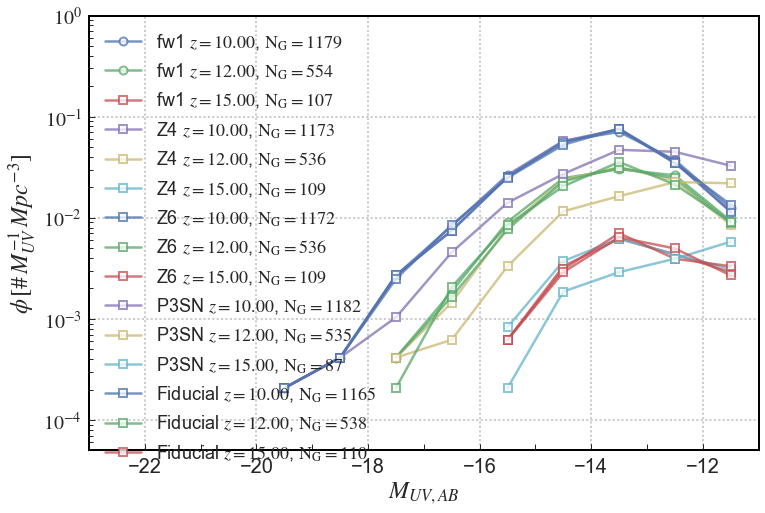

In [25]:
brightM = -23
limitM  = -11
magBins = np.linspace(brightM,limitM,-brightM+limitM+1) 

np.set_printoptions(precision=3)

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

print("Limiting absolute magnitude: {:d}".format(limitM))

rgForSFunc = np.arange(brightM,limitM, 0.1)

fig = plt.figure(figsize=(12,8))
ax = plt.axes()
# ax.set_axis_bgcolor('w')


m='o'
thezs = [15,12,10]
for dir in runs:
    for z in np.sort(thezs):

        # Convert observed magnitude to Absolute ...
        absMag, pop3Mag, nmAbsMag       = compMags(dir,z)
        Ng = len(absMag)
        print("Number of galaxies at z={} is {}".format(z,Ng))
        # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
        # both the improved Pop III luminosity and the classical

        nTempA, binsA = np.histogram(absMag,bins=magBins, density=False,
                                    weights=[1.0/simVol for i in absMag]) 
        ################################
        # Replace zero halos in a bin with
        # nan ... since we are undersampled
        ################################
        AllNonZero    = np.nonzero(nTempA)  # Define a mask of non-zero values

        # Find bin-centers
        binDeltaA = (binsA[0]-binsA[1])/2.0
        binCentersA = binsA[1::]+binDeltaA

        if z > 12:
            m='s'
        # So here we are only plotting non-zero values -- and connecting them with a line.
        # So there are dropouts in this data that we are ignorning! I think this is ok since
        # we are sampling a small volume and are gonna miss halos in the intermediate mags
        ax.plot(binCentersA[AllNonZero],nTempA[AllNonZero],ls='-',marker=m,  
                alpha=0.75, markerfacecolor="w",markeredgewidth=2.0,
                markersize=8,lw=2.5,label=dir+r' $z={:.2f}$, $\rm{{N}}_G={}$'.format(z,Ng))

        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.set_xlim([brightM,limitM])
        ax.yaxis.set_tick_params(which='major',width=1,length=6)
        ax.yaxis.set_tick_params(which='minor',width=1,length=4)
        ax.xaxis.set_tick_params(which='both',width=1,length=6)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
        ax.xaxis.set_minor_locator(ticker.MaxNLocator(nbins=-brightM+limitM+1))
        ax.get_yaxis().set_tick_params(which='both', direction='in')
        ax.get_xaxis().set_tick_params(which='both', direction='in')
        ax.set_ylim([5e-5,1])
        ax.set_xlabel('$M_{UV,AB}$',fontsize=24)
        ax.set_ylabel(r'$\phi\, [\#\, M_{UV}^{-1}\, Mpc^{-3}]$',fontsize=24)
        ax.grid(color='0.75', linestyle=':', linewidth=1.5)

    #     plt.gca().invert_xaxis()
        gc.collect()
    

ax.legend(loc=0, fontsize=18, numpoints=1 )
#plt.savefig("haloUVMag_All_scatter.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

In [25]:
logErrFix(10**bouwens15[3,1],bouwens15[3,2]),logErrFix(10**bouwens15[3,1],bouwens15[3,3])

(0.00016818495285944842, 0.00015769982919490588)

Convert to Abs Mag. DM = 46.99 @ z=7.0
7 [   1    2    8   39   86  215  574 1223 2017]


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


Convert to Abs Mag. DM = 47.20 @ z=8.0
8 [   0    2    5   18   59  163  498 1140 1937]
Convert to Abs Mag. DM = 47.38 @ z=9.0
9 [  0   1   0  14  44 138 443 801 435]
Convert to Abs Mag. DM = 47.54 @ z=10.0
10 [  0   0   1   2  12  41 120 255 366]
Convert to Abs Mag. DM = 47.80 @ z=12.0
12 [  0   0   0   0   1  10  41  99 172]
Convert to Abs Mag. DM = 48.12 @ z=15.0
15 [ 0  0  0  0  0  0  3 14 31]
Convert to Abs Mag. DM = 46.99 @ z=7.0
7 [  1   1  10  41  77 158 302 575 913]
Convert to Abs Mag. DM = 47.20 @ z=8.0
8 [  0   0   5  14  41 112 221 524 903]
Convert to Abs Mag. DM = 47.38 @ z=9.0
9 [  0   1   1  11  25  86 278 607 381]
Convert to Abs Mag. DM = 47.54 @ z=10.0
10 [  0   0   1   2   5  22  68 131 227]
Convert to Abs Mag. DM = 47.80 @ z=12.0
12 [ 0  0  0  0  2  3 16 56 79]
Convert to Abs Mag. DM = 48.12 @ z=15.0
15 [ 0  0  0  0  0  0  1  9 14]
Convert to Abs Mag. DM = 46.99 @ z=7.0
7 [   1    2    9   41   83  205  551 1191 2041]
Convert to Abs Mag. DM = 47.20 @ z=8.0
8 [   0   

14313

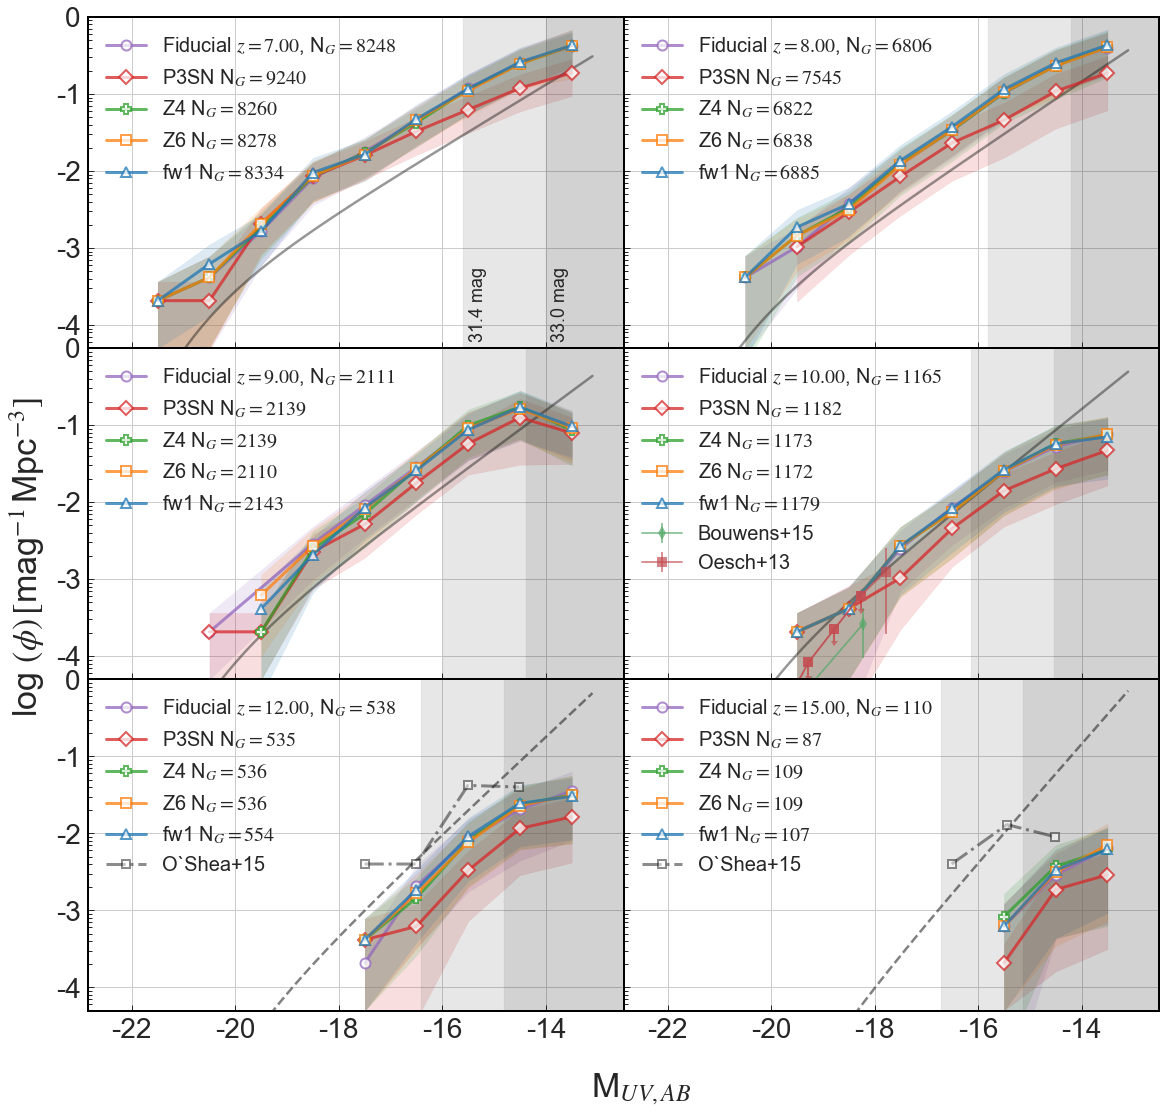

In [26]:
# Print LFs compared to Finkelstein projections... 
# Four plots in one figure

sns.set(style="whitegrid", font_scale=2,color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})
colors = ['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd'#,
# '#8c564b',
#  '#e377c2',
#  '#9467bd',
#  '#7f7f7f',
#  '#bcbd22',
#  '#17becf'
         ]
# colors = ['#1f77b4',
# '#1f77b4',
# '#1f77b4',
# '#1f77b4',
# '#1f77b4',
# '#1f77b4',
# '#1f77b4',
# '#1f77b4',
# '#1f77b4',
# '#1f77b4']
# colors = ['b','g','r','m','c','y']

plotSyms = ['o','D','P','s','^','*']
brightM = -22 # Plot range... 
limitM  = -13
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1+1) 
plotBins= np.linspace(-22,-14,9)

jwstUDC = 31.4
jwstUDC2 = 33.0

fig, axs = plt.subplots(nrows=3, ncols=2, sharex='col',sharey='row',figsize=(16,15))
done = False
for ps,c,dir in zip(plotSyms,reversed(colors),sorted(runs)):
    for z,ax in zip(np.sort([7,8,9,10,12,15]), axs.reshape(-1)):

        if z not in thezs:
            continue;
        # Convert observed magnitude to Absolute ...
        absMag, pop3Mag, nmAbsMag       = compMags(dir,z)

        # Get the JWST ultra-deep campaign limit
        jwstUDCM= jwstUDC - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2)
        jwstUDC2M= jwstUDC2 - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2)
#         print("JWST lim {:.1f}".format(jwstUDCM))
#         print("JWST lim {:.1f}".format(jwstUDC2M))
        Ng = len(absMag) # Number of galaxies at this z

        rgForSFunc = np.arange(brightM,limitM, 0.1) # Smooth Schechter (Finkelstein data) curve... 

        dx = np.diff(magBins)
#         print("Bin size is {}".format(dx[0]))

        # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
        # both the improved Pop III luminosity and the classical
        n, binsA = np.histogram(absMag,bins=magBins, density=False)
        nNM, binsANM = np.histogram(nmAbsMag,bins=magBins, density=False)
        print(z,n)

        n_orig = n
        n = n/dx/simVol
        nNM = nNM/dx/simVol


        ################################
        # Replace zero halos in a bin with
        # nan ... since we are undersampled
        ################################
        AllNonZero    = np.nonzero(n)  # Define a mask of non-zero values
        AllNonZeroNM  = np.nonzero(nNM)  # Define a mask of non-zero values

        # With Evans help
        sigma_nu_for_bins = sigma_nu(dir,z,plotBins)
#         print("sigma_nu for bins",sigma_nu_for_bins)
        # Without cosmic variance we'd have sqrt(1/n_orig) * n_orig/dx/simVol = sqrt(n_orig)/dx/SimVol
        err_w_var = np.sqrt(sigma_nu_for_bins**2 + 1/n_orig) * n_orig/dx/simVol # Error: sqrt term, signal: n/dx/simVol
#         print("Errors: ",err_w_var)
        err_w_var_dwn = err_w_var # In case err_w_var puts us less than 0
        err_w_var_dwn[n-err_w_var_dwn <= 0.0] = n[n-err_w_var_dwn <= 0] - 5e-5 # which extends error to the plot's lower limit
#         print("Corrected lower Errors: ",err_w_var_dwn)

        # Find bin-centers
        binDeltaA = (binsA[0]-binsA[1])/2.0
        binCentersA = binsA[1::]+binDeltaA

        if dir == "Fiducial":
            label = dir+r' $z={:.2f}$, N$_G={}$'.format(z,Ng)
        else:
            label = dir+r' N$_G={}$'.format(Ng)
        mec = mpl.colors.colorConverter.to_rgba(c, alpha=0.9)
        # So here we are only plotting non-zero values -- and connecting them with a line.
        # So there are dropouts in this data that we are ignorning! I think this is ok since
        # we are sampling a small volume and are gonna miss halos in the intermediate mags
        ax.plot(binCentersA[AllNonZero],n[AllNonZero],markeredgewidth=2.0,
                ls='-',marker=ps, c=c, alpha=0.75,markerfacecolor="w",
                markersize=10,lw=3.0,mec=mec,label=label)
        if z >= 16:
            ax.plot(binCentersA[AllNonZeroNM],nNM[AllNonZeroNM],markeredgewidth=2.0,
                ls='-',marker='^', c='C2', alpha=0.9,markerfacecolor="w",
                markersize=10,lw=3.0,mec='C2',label=r'Classical Pop III'.format(z,Ng))
            ax.fill_between(binCentersA[AllNonZeroNM],n[AllNonZeroNM]+err_w_var[AllNonZeroNM],
                            nNM[AllNonZeroNM]-err_w_var_dwn[AllNonZeroNM],
                            color='C2', alpha=0.2)
        ax.fill_between(binCentersA[AllNonZero],n[AllNonZero]+err_w_var[AllNonZero],
                        n[AllNonZero]-err_w_var_dwn[AllNonZero],
                        color=c, alpha=0.15)

        if not done:
            ax.axvspan( jwstUDCM, limitM+0.5, alpha=0.1, color='k')
            ax.axvspan( jwstUDC2M, limitM+0.5, alpha=0.1, color='k')
        if z in [7] and not done:
            ax.annotate('31.4 mag', xy = (0.5, 0.5), xytext = (jwstUDCM+0.1, 6e-5), xycoords='axes fraction',
                textcoords = 'data', ha = 'left', va = 'bottom',fontsize=18, rotation=90)
            ax.annotate('33.0 mag', xy = (0.5, 0.5), xytext = (jwstUDC2M+0.1, 6e-5), xycoords='axes fraction',
                textcoords = 'data', ha = 'left', va = 'bottom',fontsize=18, rotation=90)

        # Format plt
        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(logfmt)
        ax.set_xlim([brightM-0.85,limitM+0.5])
        ax.set_xticks(np.arange(brightM,limitM+1,2))
        ax.set_xticklabels([str(i) for i in np.arange(brightM,limitM+1,2)])
        ax.set_ylim([5e-5,1])
        ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1])
        ax.xaxis.set_tick_params(which='both',width=1,length=6,direction='in',labelsize=28)
        ax.yaxis.set_tick_params(which='major',width=1,length=6,direction='in',labelsize=28)
        ax.yaxis.set_tick_params(which='minor',width=1,length=4,direction='in')

        #     plt.gca().invert_xaxis()
        gc.collect()

        if z > 10 and (not done):
            ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k--',lw=2.5,alpha=0.55)
        elif not done:
            ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k-',lw=2.5,alpha=0.45)

        if z==10 and not done:
    #         print("To logErrFix:",(10**bouwens15[:,1],bouwens15[:,2]),(10**bouwens15[:,1],bouwens15[:,3]))

            ax.errorbar(bouwens15[:,0],10**bouwens15[:,1], yerr=[logErrFix(10**bouwens15[:,1],bouwens15[:,2]),
                                                             logErrFix(10**bouwens15[:,1],bouwens15[:,3])],
                        marker='d',c='C1',alpha=0.7, markersize=10, mec='None',
                        label=r'Bouwens+15')
            ax.errorbar(oesch13[:,0],10**oesch13[:,1], yerr=[logErrFix(10**oesch13[:,1],oesch13[:,2]),
                                                             logErrFix(10**oesch13[:,1],oesch13[:,3])],
                        marker='s',c='C2',alpha=0.7,markersize=10,mec='k',label=r'Oesch+13'.format(z,Ng))
            ax.errorbar(oesch13[2:7,0],10**oesch13[2:7,1], yerr=[logErrFix(10**oesch13[2:7,1],oesch13[2:7,2]),
                                                             logErrFix(10**oesch13[2:7,1],oesch13[2:7,3])],
                        marker='s',c='C2',alpha=0.7,markersize=10,mec='k',uplims=True)
        # Add O'Shea data if available
        if z in OShea and dir=='fw1':
            ax.plot(OShea[z][:,0][OShea[z][:,0] < -14],OShea[z][:,1][OShea[z][:,0] < -14],ls='-.',marker='s',
                    markeredgewidth=2.0,markerfacecolor="w",c='k', ms=8, lw=3.0,alpha=0.5, label='O`Shea+15')
        ax.legend(loc=2, fontsize=20, numpoints=1 )

    done = True

fig.text(0.55, 0.00,'M$_{UV,AB}$', ha='center',size=34, )
fig.text(0.00, 0.5, r'log $(\phi)\, [$mag$^{-1}\, $Mpc$^{-3}]$',size=34,
         va='center', rotation='vertical')
plt.subplots_adjust(left=0.07, bottom=0.08, right=1.0, top=1.0, wspace=.0, hspace=.0)
plt.savefig("haloUVMag_Summary_scatter6.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
gc.collect()

In [27]:
runs

['fw1', 'Z4', 'Z6', 'P3SN', 'Fiducial']

Convert to Abs Mag. DM = 46.99 @ z=7.0
7 [   1    2    8   39   86  215  574 1223 2017 1813 1062  512  322  198   61
   31]


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


Convert to Abs Mag. DM = 47.20 @ z=8.0
8 [   0    2    5   18   59  163  498 1140 1937 1649  732  245  132   73   38
   29]
Convert to Abs Mag. DM = 47.38 @ z=9.0
9 [  0   1   0  14  44 138 443 801 435 166  39  12   5   3   3   0]
Convert to Abs Mag. DM = 47.54 @ z=10.0
10 [  0   0   1   2  12  41 120 255 366 167  65  34  21  19  10  15]
Convert to Abs Mag. DM = 47.80 @ z=12.0
12 [  0   0   0   0   1  10  41  99 172 103  44  26   9  11   4   6]
Convert to Abs Mag. DM = 48.12 @ z=15.0
15 [ 0  0  0  0  0  0  3 14 31 24 13  9  4  4  2  3]
Convert to Abs Mag. DM = 46.99 @ z=7.0
7 [   1    1   10   41   77  158  302  575  913 1147 1182 1130 1497 1681  495
   30]
Convert to Abs Mag. DM = 47.20 @ z=8.0
8 [   0    0    5   14   41  112  221  524  903 1220 2055 1556  769   98   21
    5]
Convert to Abs Mag. DM = 47.38 @ z=9.0
9 [  0   1   1  11  25  86 278 607 381 299 185  94  47  66  43  15]
Convert to Abs Mag. DM = 47.54 @ z=10.0
10 [  0   0   1   2   5  22  68 131 227 217 158 143  87  78  41

OSError: [Errno 5] Input/output error: 'haloUVMag_Summary_scatter-extended.pdf'

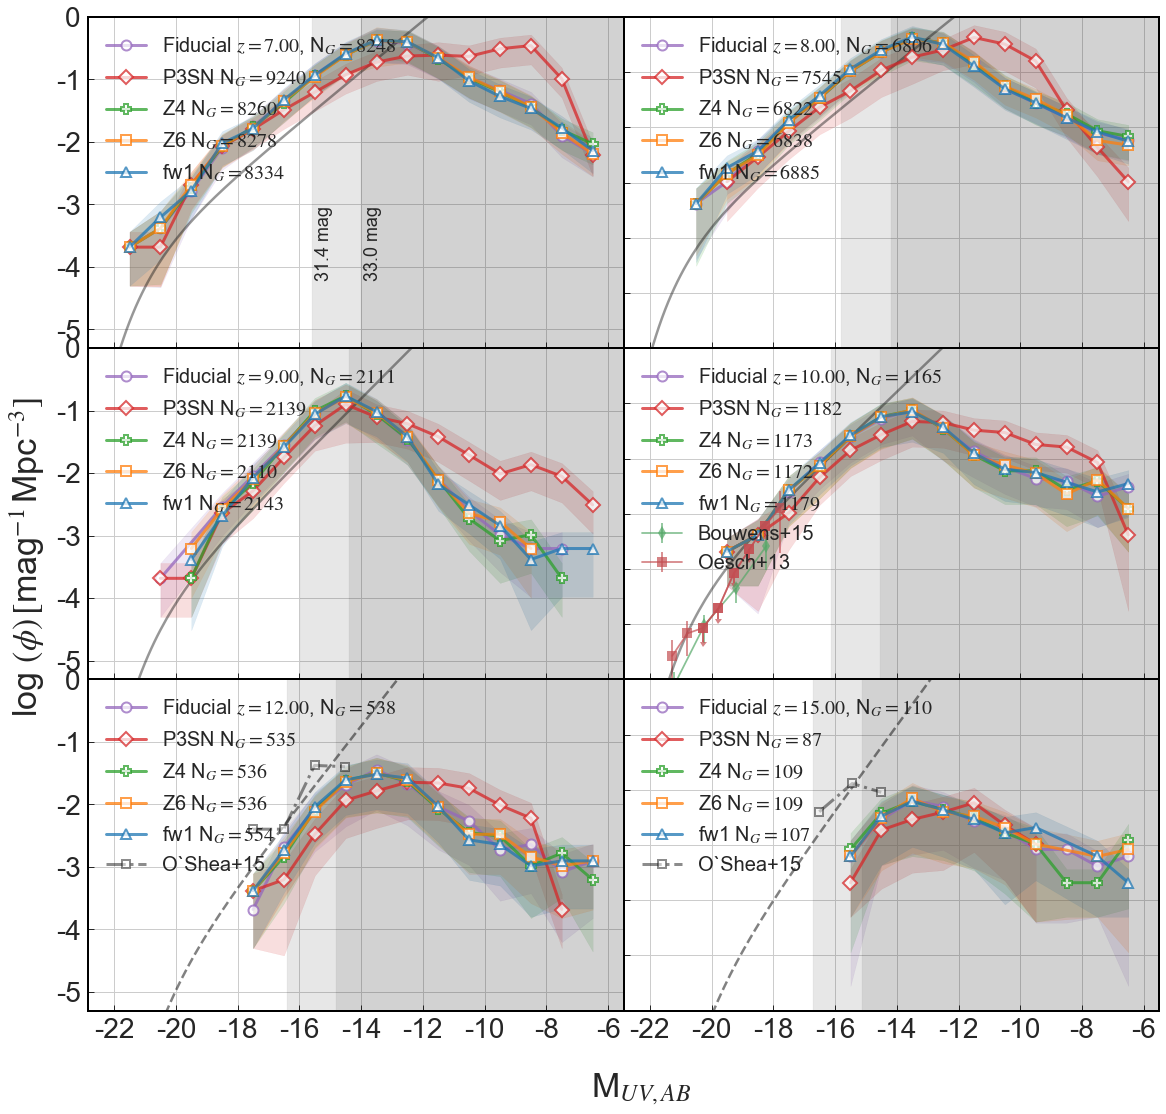

In [30]:
# Print LFs compared to Finkelstein projections... 
# Four plots in one figure

sns.set(style="whitegrid", font_scale=2,color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})
colors = ['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd'#,
         ]

plotSyms = ['o','D','P','s','^','*']
brightM = -22 # Plot range... 
limitM  = -6
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1+1) 
plotBins= np.linspace(-22,-7,16)

jwstUDC = 31.4
jwstUDC2 = 33.0

fig, axs = plt.subplots(nrows=3, ncols=2, sharex='col',sharey='row',figsize=(16,15))
done = False
for ps,c,dir in zip(plotSyms,reversed(colors),sorted(runs)):
    for z,ax in zip(np.sort([7,8,9,10,12,15]), axs.reshape(-1)):

        if z not in thezs:
            continue;
        # Convert observed magnitude to Absolute ...
        absMag, pop3Mag, nmAbsMag       = compMags(dir,z)

        # Get the JWST ultra-deep campaign limit
        jwstUDCM= jwstUDC - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2)
        jwstUDC2M= jwstUDC2 - 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2)
#         print("JWST lim {:.1f}".format(jwstUDCM))
#         print("JWST lim {:.1f}".format(jwstUDC2M))
        Ng = len(absMag) # Number of galaxies at this z

        rgForSFunc = np.arange(brightM,limitM, 0.1) # Smooth Schechter (Finkelstein data) curve... 

        dx = np.diff(magBins)
#         print("Bin size is {}".format(dx[0]))

        # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
        # both the improved Pop III luminosity and the classical
        n, binsA = np.histogram(absMag,bins=magBins, density=False)
        nNM, binsANM = np.histogram(nmAbsMag,bins=magBins, density=False)
        print(z,n)

        n_orig = n
        n = n/dx/simVol
        nNM = nNM/dx/simVol


        ################################
        # Replace zero halos in a bin with
        # nan ... since we are undersampled
        ################################
        AllNonZero    = np.nonzero(n)  # Define a mask of non-zero values
        AllNonZeroNM  = np.nonzero(nNM)  # Define a mask of non-zero values

        # With Evans help
        sigma_nu_for_bins = sigma_nu(dir,z,plotBins)
#         print("sigma_nu for bins",sigma_nu_for_bins)
        # Without cosmic variance we'd have sqrt(1/n_orig) * n_orig/dx/simVol = sqrt(n_orig)/dx/SimVol
        err_w_var = np.sqrt(sigma_nu_for_bins**2 + 1/n_orig) * n_orig/dx/simVol # Error: sqrt term, signal: n/dx/simVol
#         print("Errors: ",err_w_var)
        err_w_var_dwn = err_w_var # In case err_w_var puts us less than 0
        err_w_var_dwn[n-err_w_var_dwn <= 0.0] = n[n-err_w_var_dwn <= 0] - 5e-5 # which extends error to the plot's lower limit
#         print("Corrected lower Errors: ",err_w_var_dwn)

        # Find bin-centers
        binDeltaA = (binsA[0]-binsA[1])/2.0
        binCentersA = binsA[1::]+binDeltaA

        if dir == "Fiducial":
            label = dir+r' $z={:.2f}$, N$_G={}$'.format(z,Ng)
        else:
            label = dir+r' N$_G={}$'.format(Ng)
        mec = mpl.colors.colorConverter.to_rgba(c, alpha=0.9)
        # So here we are only plotting non-zero values -- and connecting them with a line.
        # So there are dropouts in this data that we are ignorning! I think this is ok since
        # we are sampling a small volume and are gonna miss halos in the intermediate mags
        ax.plot(binCentersA[AllNonZero],n[AllNonZero],markeredgewidth=2.0,
                ls='-',marker=ps, c=c, alpha=0.75,markerfacecolor="w",
                markersize=10,lw=3.0,mec=mec,label=label)
        if z >= 16:
            ax.plot(binCentersA[AllNonZeroNM],nNM[AllNonZeroNM],markeredgewidth=2.0,
                ls='-',marker='^', c='C2', alpha=0.9,markerfacecolor="w",
                markersize=10,lw=3.0,mec='C2',label=r'Classical Pop III'.format(z,Ng))
            ax.fill_between(binCentersA[AllNonZeroNM],n[AllNonZeroNM]+err_w_var[AllNonZeroNM],
                            nNM[AllNonZeroNM]-err_w_var_dwn[AllNonZeroNM],
                            color='C2', alpha=0.2)
        ax.fill_between(binCentersA[AllNonZero],n[AllNonZero]+err_w_var[AllNonZero],
                        n[AllNonZero]-err_w_var_dwn[AllNonZero],
                        color=c, alpha=0.15)

        if not done:
            ax.axvspan( jwstUDCM, limitM+0.5, alpha=0.1, color='k')
            ax.axvspan( jwstUDC2M, limitM+0.5, alpha=0.1, color='k')
        if z in [7] and not done:
            ax.annotate('31.4 mag', xy = (0.5, 0.5), xytext = (jwstUDCM+0.1, 6e-5), xycoords='axes fraction',
                textcoords = 'data', ha = 'left', va = 'bottom',fontsize=18, rotation=90)
            ax.annotate('33.0 mag', xy = (0.5, 0.5), xytext = (jwstUDC2M+0.1, 6e-5), xycoords='axes fraction',
                textcoords = 'data', ha = 'left', va = 'bottom',fontsize=18, rotation=90)

        # Format plt
        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(logfmt)
        ax.set_xlim([brightM-0.85,limitM+0.5])
        ax.set_xticks(np.arange(brightM,limitM+1,2))
        ax.set_xticklabels([str(i) for i in np.arange(brightM,limitM+1,2)])
        ax.set_ylim([5e-6,1])
        ax.set_yticks([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1])
        ax.xaxis.set_tick_params(which='both',width=1,length=6,direction='in',labelsize=28)
        ax.yaxis.set_tick_params(which='major',width=1,length=6,direction='in',labelsize=28)
        ax.yaxis.set_tick_params(which='minor',width=1,length=4,direction='in')

        #     plt.gca().invert_xaxis()
        gc.collect()

        if z > 10 and (not done):
            ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k--',lw=2.5,alpha=0.55)
        elif not done:
            ax.plot(rgForSFunc, schechterM_forFit(finkel[z], rgForSFunc),'k-',lw=2.5,alpha=0.45)

        if z==10 and not done:
    #         print("To logErrFix:",(10**bouwens15[:,1],bouwens15[:,2]),(10**bouwens15[:,1],bouwens15[:,3]))

            ax.errorbar(bouwens15[:,0],10**bouwens15[:,1], yerr=[logErrFix(10**bouwens15[:,1],bouwens15[:,2]),
                                                             logErrFix(10**bouwens15[:,1],bouwens15[:,3])],
                        marker='d',c='C1',alpha=0.7, markersize=10, mec='None',
                        label=r'Bouwens+15')
            ax.errorbar(oesch13[:,0],10**oesch13[:,1], yerr=[logErrFix(10**oesch13[:,1],oesch13[:,2]),
                                                             logErrFix(10**oesch13[:,1],oesch13[:,3])],
                        marker='s',c='C2',alpha=0.7,markersize=10,mec='k',label=r'Oesch+13'.format(z,Ng))
            ax.errorbar(oesch13[2:7,0],10**oesch13[2:7,1], yerr=[logErrFix(10**oesch13[2:7,1],oesch13[2:7,2]),
                                                             logErrFix(10**oesch13[2:7,1],oesch13[2:7,3])],
                        marker='s',c='C2',alpha=0.7,markersize=10,mec='k',uplims=True)
        # Add O'Shea data if available
        if z in OShea and dir=='fw1':
            ax.plot(OShea[z][:,0][OShea[z][:,0] < -14],OShea[z][:,1][OShea[z][:,0] < -14],ls='-.',marker='s',
                    markeredgewidth=2.0,markerfacecolor="w",c='k', ms=8, lw=3.0,alpha=0.5, label='O`Shea+15')
        ax.legend(loc=2, fontsize=20, numpoints=1 )

    done = True

fig.text(0.55, 0.00,'M$_{UV,AB}$', ha='center',size=34, )
fig.text(0.00, 0.5, r'log $(\phi)\, [$mag$^{-1}\, $Mpc$^{-3}]$',size=34,
         va='center', rotation='vertical')
plt.subplots_adjust(left=0.07, bottom=0.08, right=1.0, top=1.0, wspace=.0, hspace=.0)
plt.savefig("haloUVMag_Summary_scatter-extended.pdf",dpi=fig.dpi,bbox_inches='tight')
gc.collect()

In [47]:
# Print LFs compared to Finkelstein projections... 
# Four plots in one figure

brightM = -22 # Plot range... 
limitM  = -13
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1+1) 
plotBins= np.linspace(-22,-14,9)
dx = np.diff(magBins)

absMag, pop3Mag, nmAbsMag       = compMags('Fiducial',7)
n, binsA = np.histogram(absMag,bins=magBins, density=False)
n_orig = n
n = n/dx/simVol
good    = np.nonzero(n)  # Define a mask of non-zero values
fiducial = n[good]

absMag, pop3Mag, nmAbsMag       = compMags('P3SN',7)
n, binsA = np.histogram(absMag,bins=magBins, density=False)
n_orig = n
n = n/dx/simVol
good    = np.nonzero(n)  # Define a mask of non-zero values
p3SN = n[good]

gc.collect()

Convert to Abs Mag. DM = 46.99 @ z=7.0
Convert to Abs Mag. DM = 46.99 @ z=7.0


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


23399

In [49]:
fiducial-p3SN

array([  0.000e+00,   2.071e-04,  -4.142e-04,  -4.142e-04,   1.864e-03,
         1.181e-02,   5.634e-02,   1.342e-01,   2.287e-01])

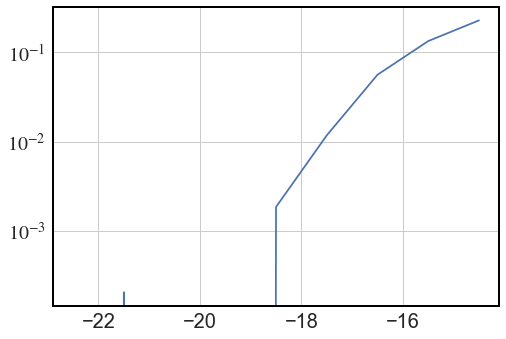

In [50]:
plt.plot(binCentersA[good],fiducial-p3SN[good])
plt.yscale('log')

In [36]:
# ##########################################################
# Normalizes the histogram's bar height by the bin width
# and co-moving volume of the simulation
# ##########################################################
def normBarHeight(bins, patches, cmvol, rotated=False):
    widths = np.diff(bins)
    for item,dx in zip(patches,widths):
#         print ("Starting height: %.5f bin width: %.2e"%(item.get_height(),dx))
        if not rotated:
            item.set_height(item.get_height()/dx/cmvol)
        else:
            item.set_width(item.get_width()/dx/cmvol)
#         print ("Ending width: %.5f"%item.get_width())
    return


In [37]:
np.logspace(-3,0.0,16),np.linspace(1e-3,1,18)

(array([ 0.001     ,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
         0.01      ,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
         0.1       ,  0.15848932,  0.25118864,  0.39810717,  0.63095734,  1.        ]),
 array([ 0.001     ,  0.05976471,  0.11852941,  0.17729412,  0.23605882,
         0.29482353,  0.35358824,  0.41235294,  0.47111765,  0.52988235,
         0.58864706,  0.64741176,  0.70617647,  0.76494118,  0.82370588,
         0.88247059,  0.94123529,  1.        ]))

In [60]:
runs

['fw1', 'Z4', 'Z6', 'P3SN', 'Fiducial']

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 46.99 @ z=7.0
Pop III flux fraction is 0.01163 at z=7
Working on z=7
Number of galaxies 8334
Largest bin value: 0.000, smallest -3.3138672203691533


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:75: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:76: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.02422 at z=8
Working on z=8
Number of galaxies 6885
Largest bin value: 0.000, smallest -3.0867156639448825
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.23651 at z=9
Working on z=9
Number of galaxies 2143
Largest bin value: 0.000, smallest -2.9180303367848803
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.06646 at z=10
Working on z=10
Number of galaxies 1179
Largest bin value: 0.000, smallest -2.4424797690644486
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.14437 at z=12
Working on z=12
Number of galaxies 554
Largest bin value: 0.000, smallest -2.164352855784437
Convert to Abs Mag. DM = 48.12 @ z=15.0
Pop III flux fraction is 0.35323 at z=15
Working on z=15
Number of galaxies 107
Largest bin value: 0.000, smallest -1.4771212547196624
FINISHED with z=7-15
Convert to Abs Mag. DM = 46.99 @ z=7.0
Pop III flux fraction is 0.01163 at z=7
Working on z=7
**************

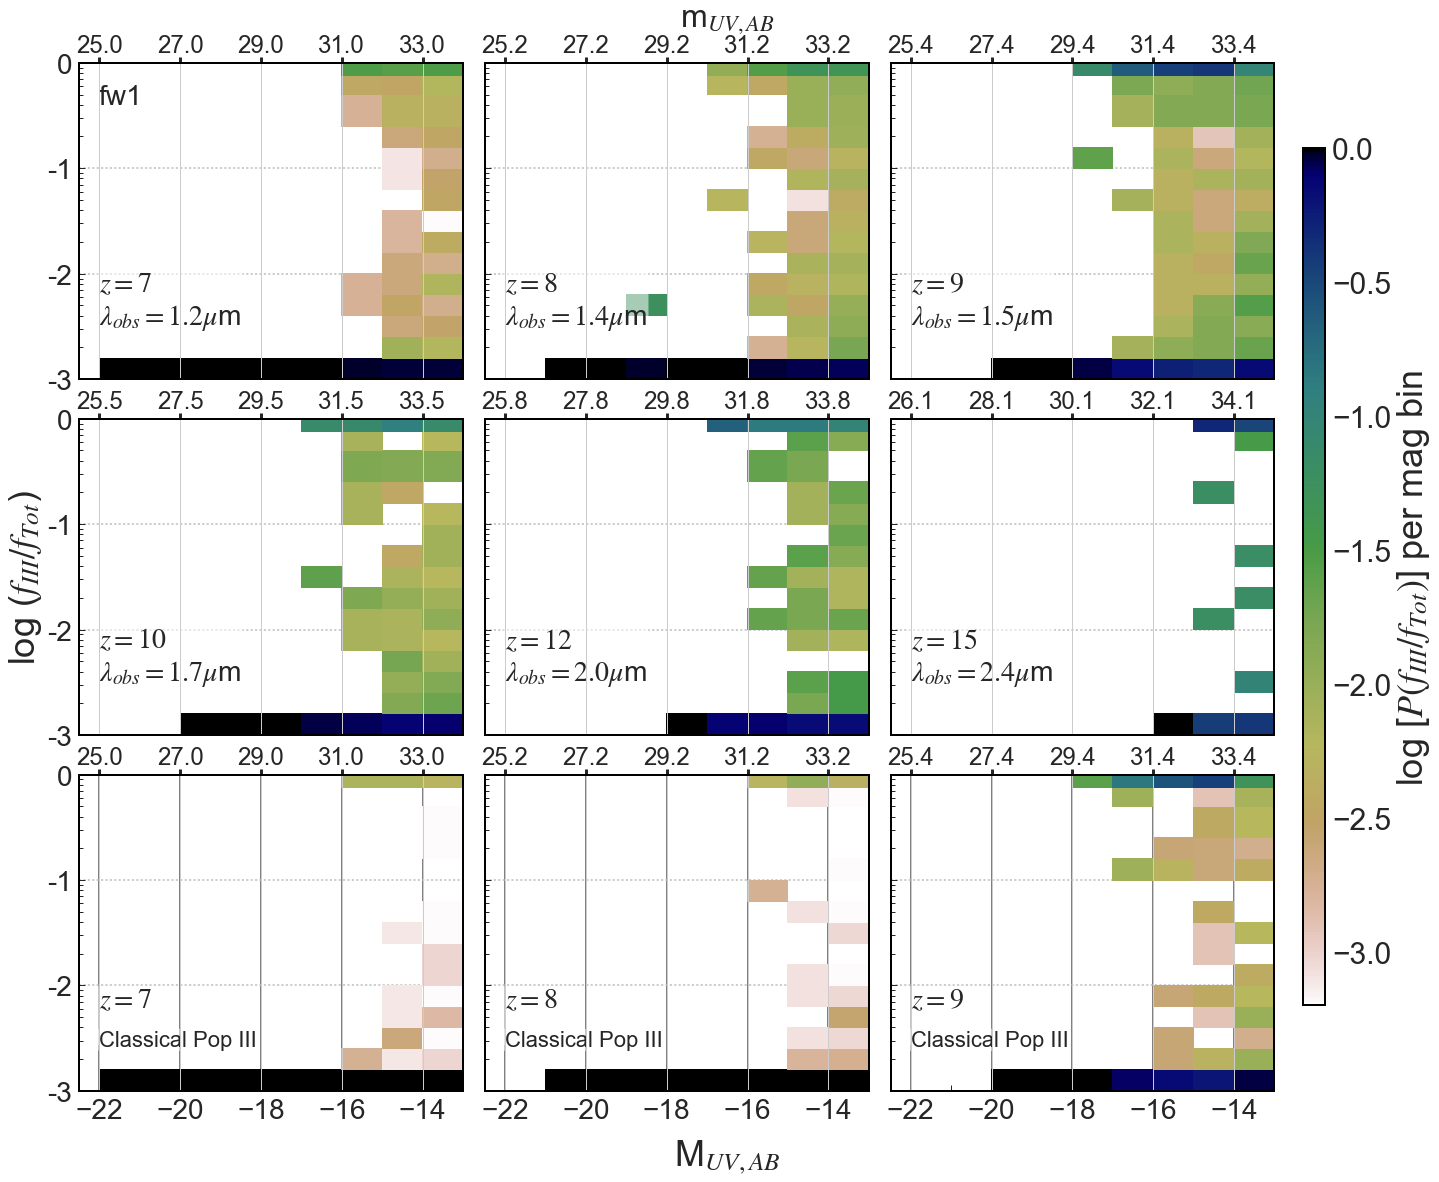

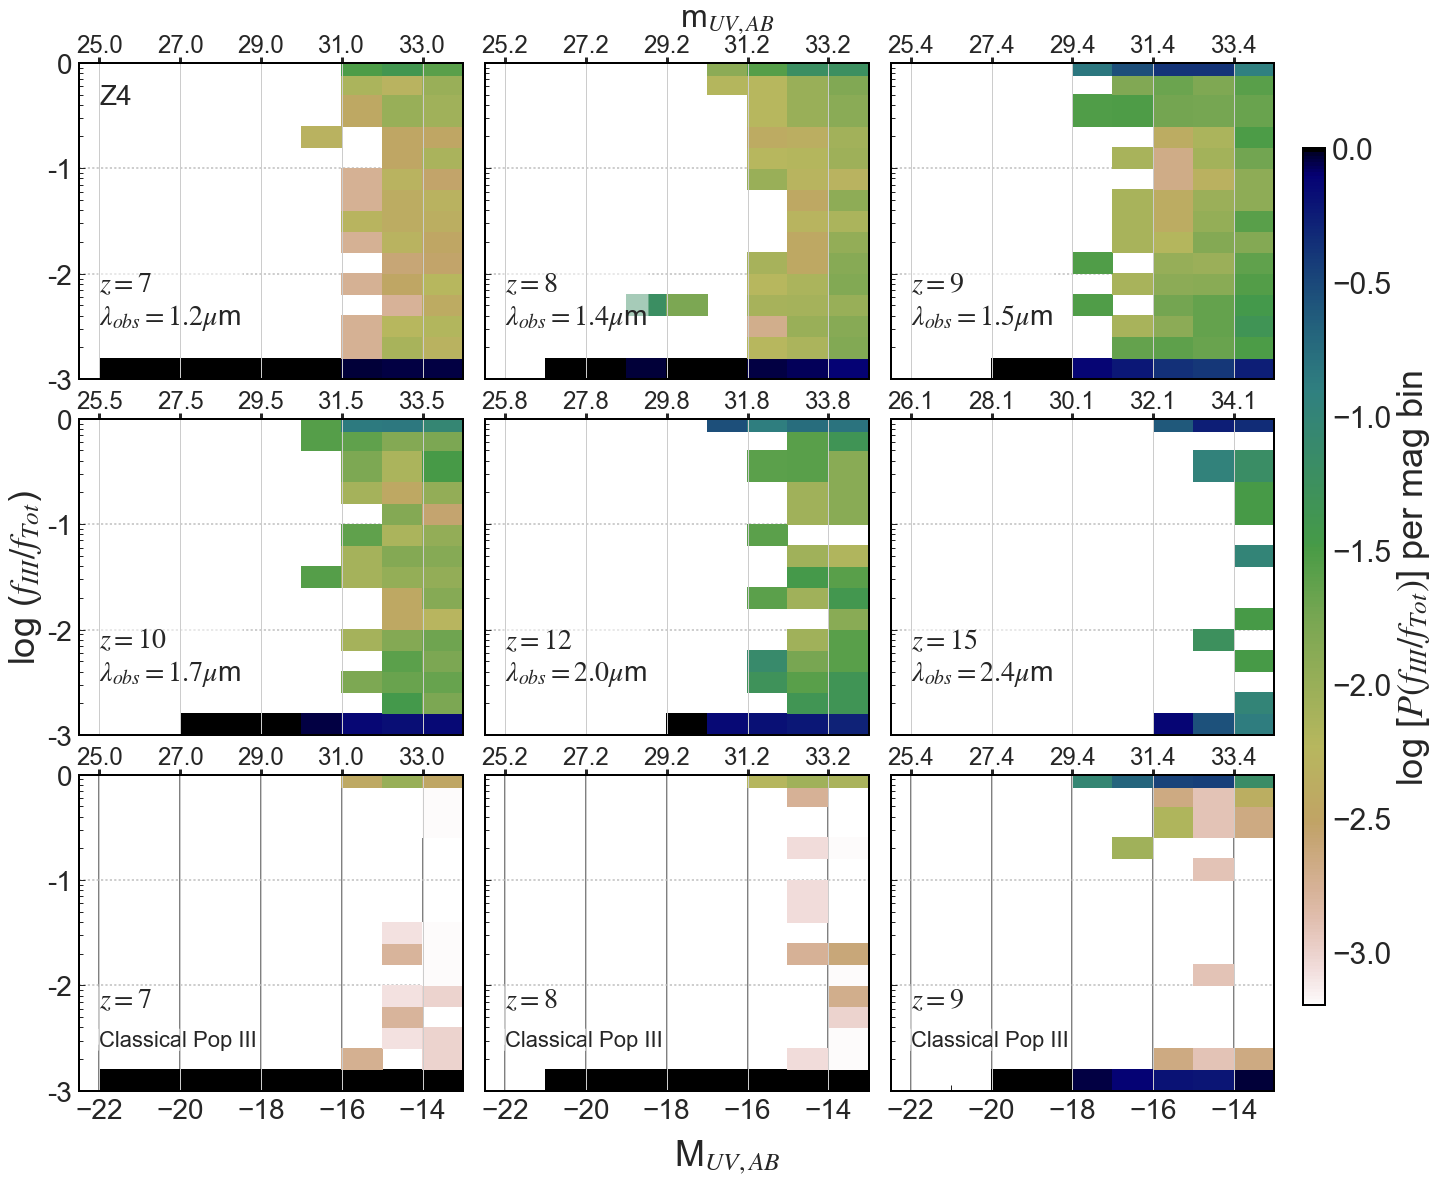

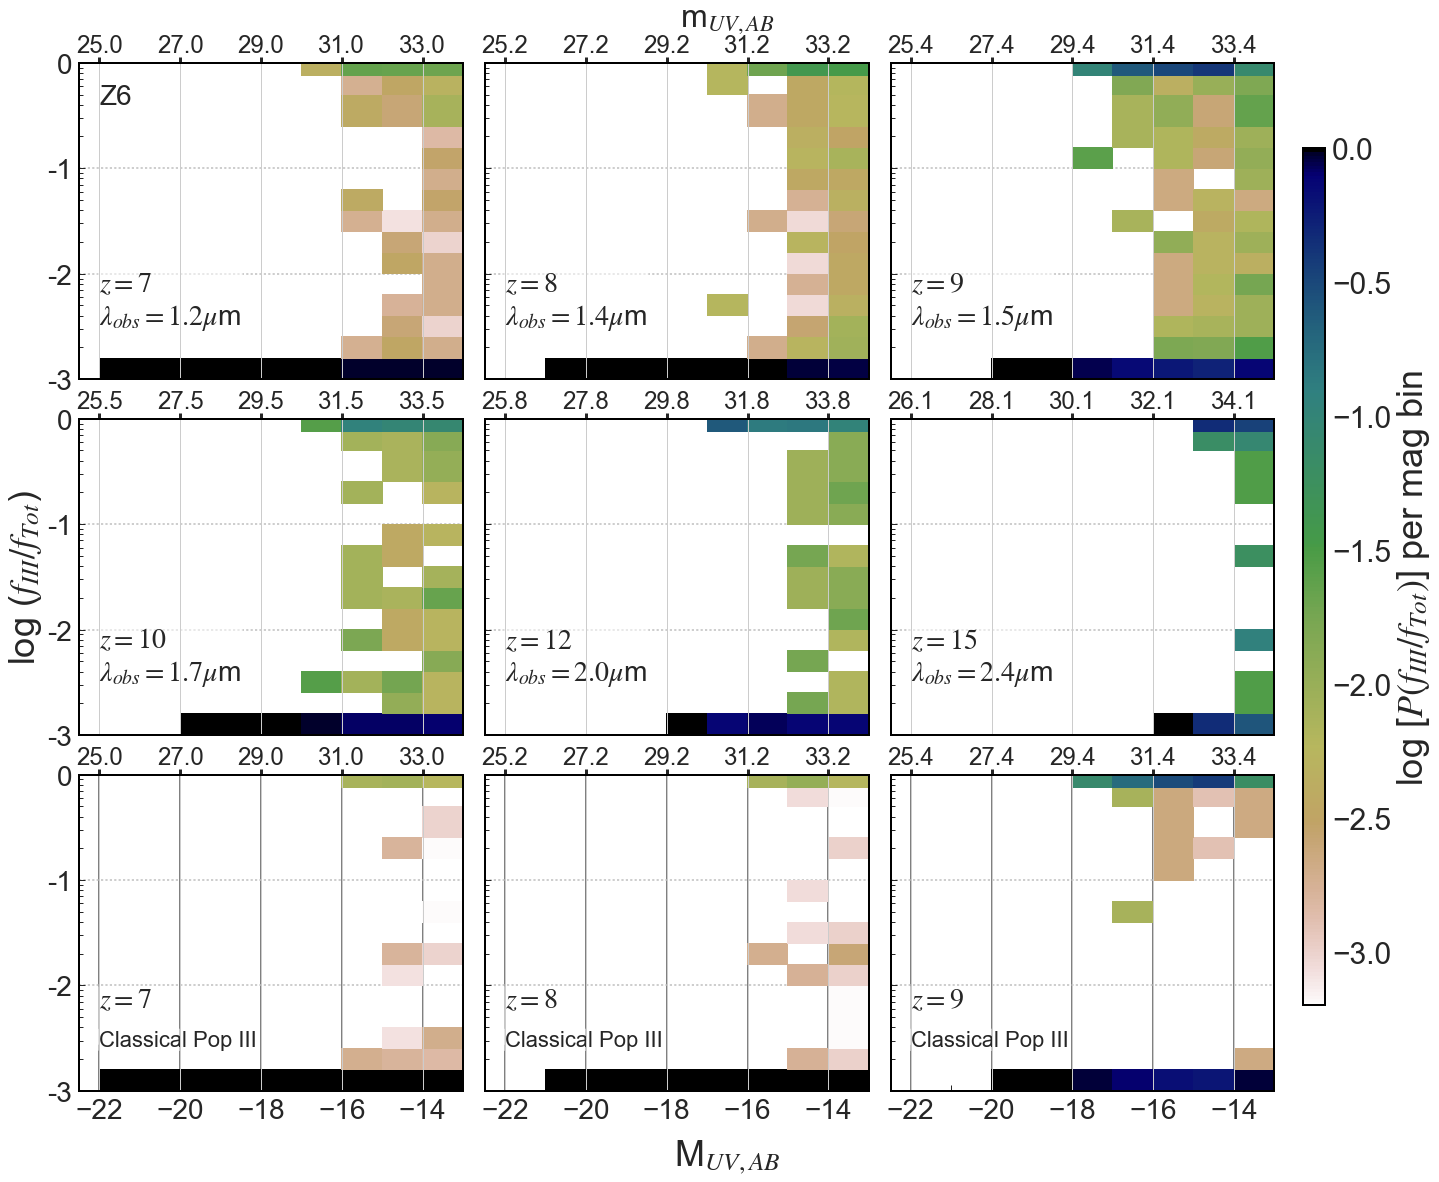

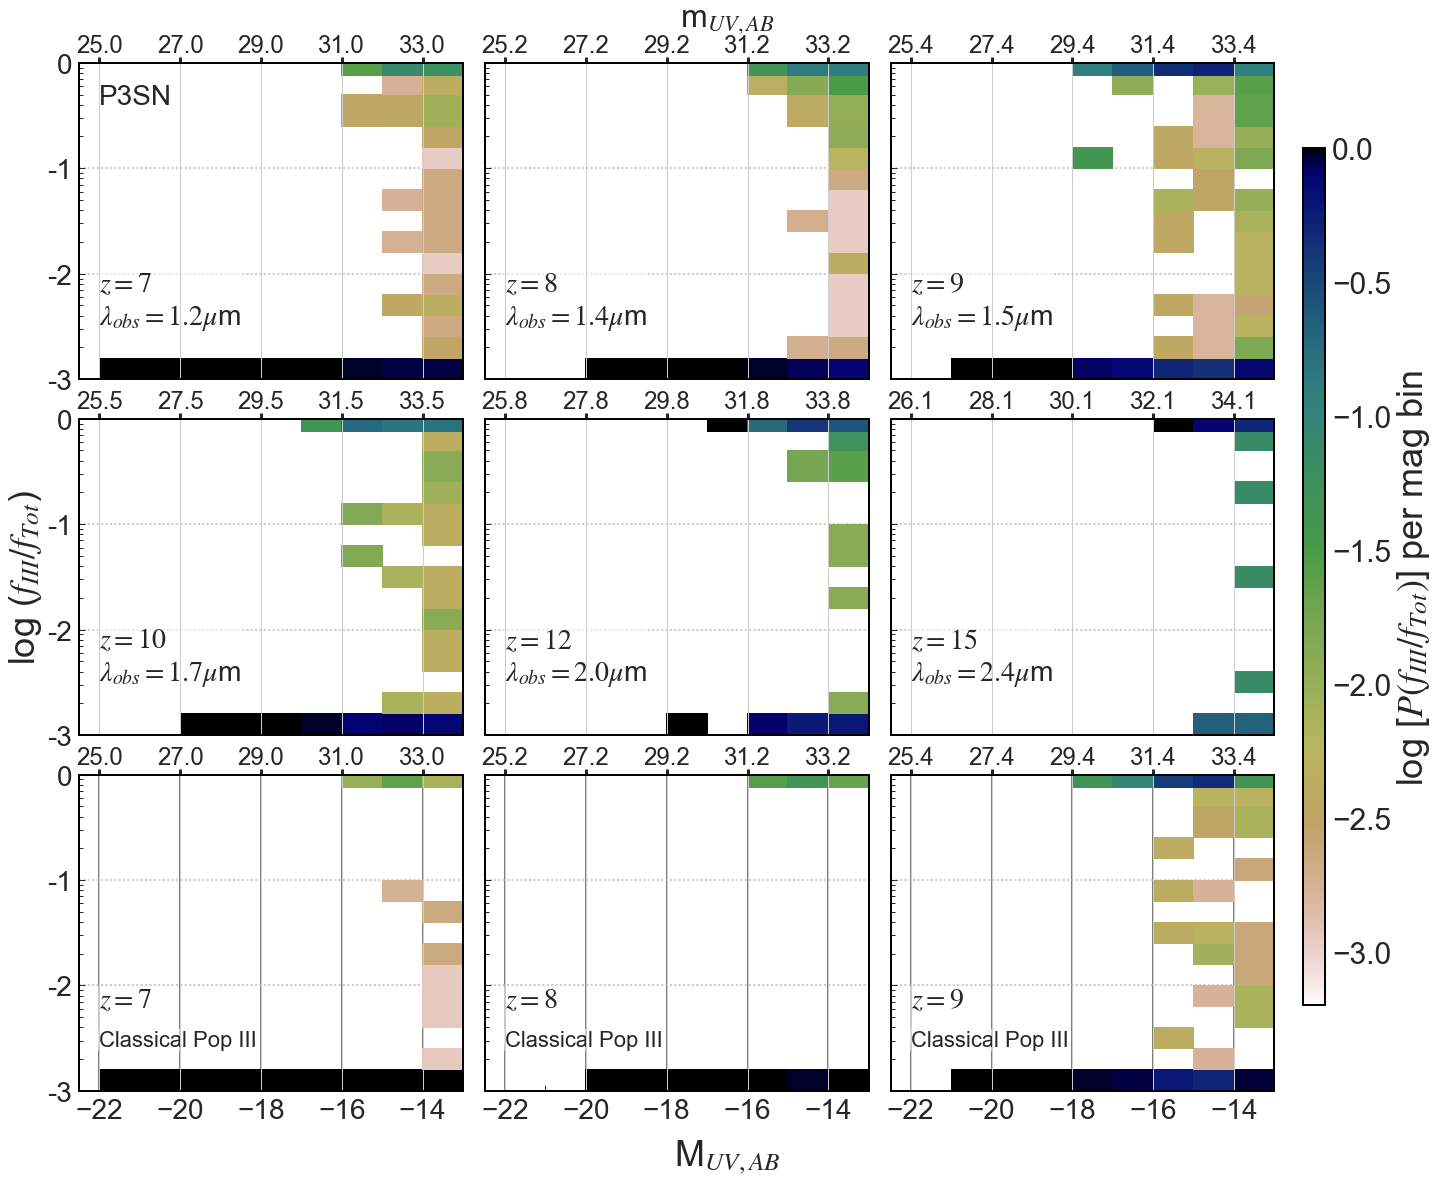

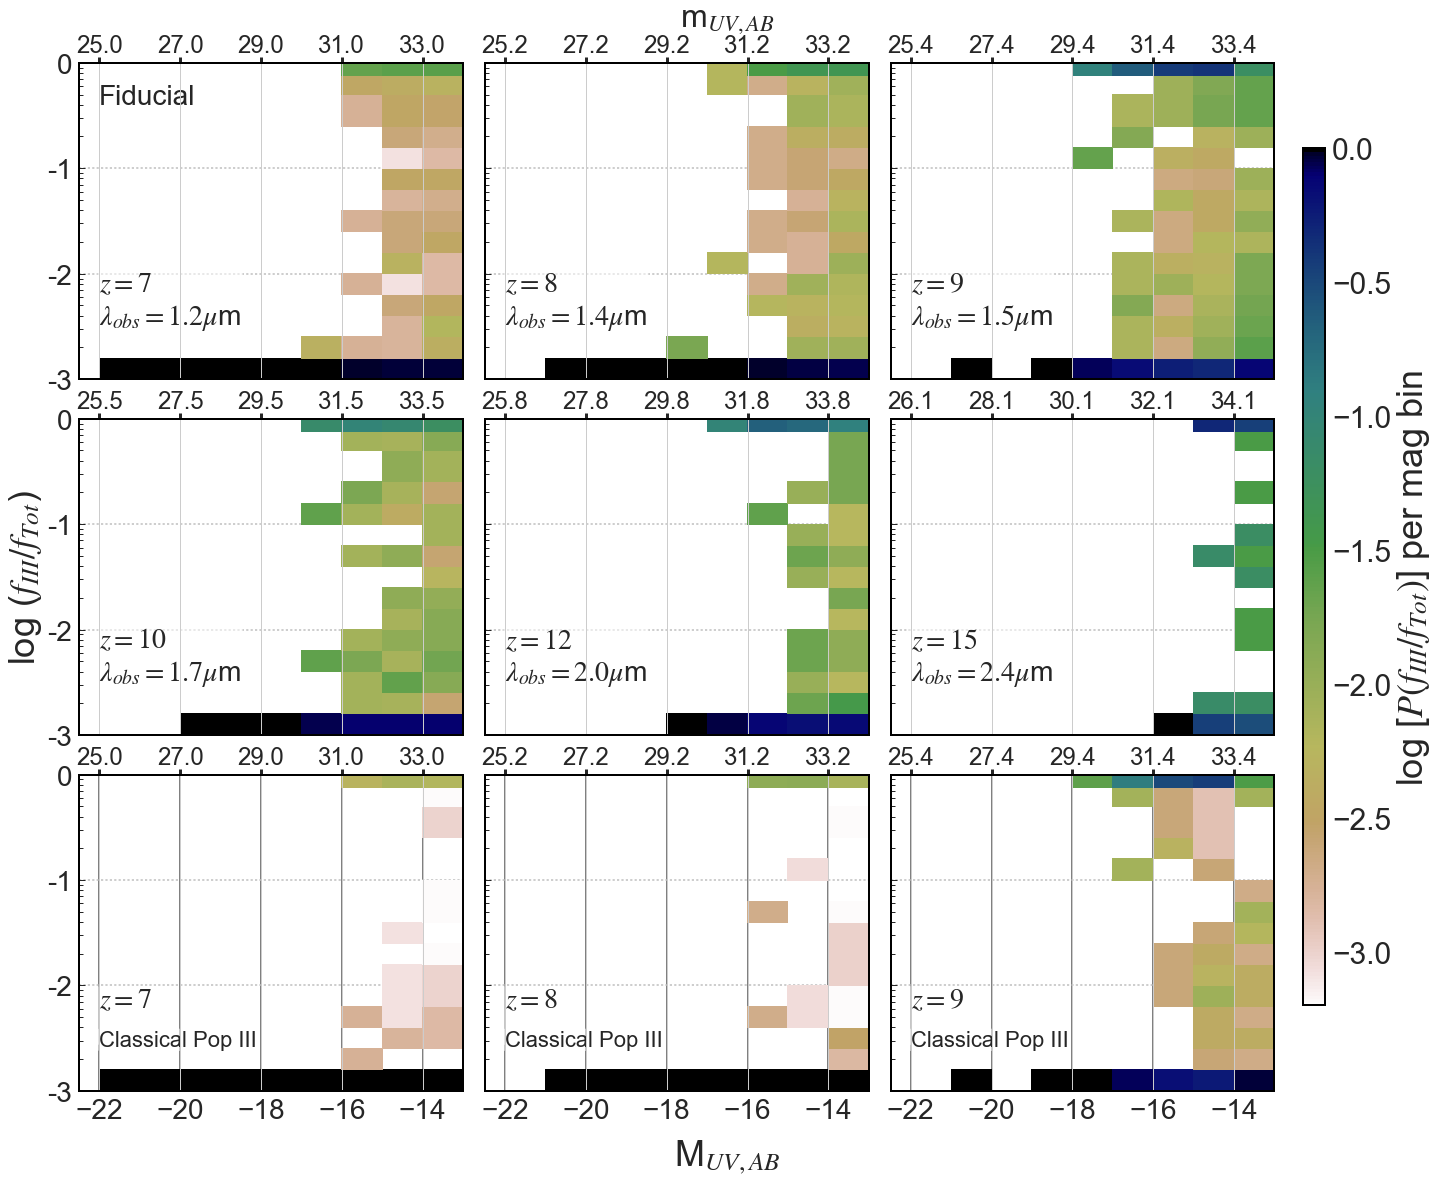

In [63]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
for dir in runs:
    fig, axs = plt.subplots(nrows=3, ncols=3, sharex='col',sharey='row',figsize=(20,17))
    for z,ax in zip([7,8,9,10,12,15,7,8,9], axs.flat):

        if z not in thezs:
            continue

        # Convert observed magnitude to Absolute ...
        absMag, pop3Mag, nmAbsMag   = compMags(dir,z)
        # Map 0 Pop 3 flux to 1e-3... 
        pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
        p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
        print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
        pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

        print("Working on z={}".format(z))
        # If we are back to z = 8,9,10 then generate plots for NO Mixing
        if doNMnow:
            print("************************************************************")
            print("Working on the NON MIXING flux fractions for or galaxies ...")
            print("************************************************************")
            pop3Fraction = haloData[dir][z]['1500A_P3NM']/haloData[dir][z]['1500A_NM']
            p3ff[z] = haloData[dir][z]['1500A_P3NM'].sum()/haloData[dir][z]['1500A_NM'].sum()
    #         print("Pop III flux fraction is {:.5f} at z={}".format(p3ffNM[z],z))
            pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
            absMag = nmAbsMag ## Do plots for NO MIXING version of data... 
            print("z={} overall mixing p3ff={:.3f}, no mixing p3ff={:.3f}".format(z,p3ffMix[z],p3ff[z]))
            print("z={} PopIII mixing/no mixing={:.3f}".format(z,haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A_P3NM'].sum()))

        Ng = len(absMag) # Number of galaxies at this z
        print("Number of galaxies {}".format(Ng))
        # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
        # both the improved Pop III luminosity and the classical

        # Note that we are reversing x,y here since pcolormesh interprets them backwards!
        nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
        # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
        # normed : bool, optional
        #        If False, returns the number of samples in each bin. If True, returns the bin density 
        #        bin_count / sample_count / bin_area.

        X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

        # Mask out 0 values before taking log10... 
        H = np.ma.masked_where(nTempA==0.0, nTempA)
        for i in range(len(H[0,:])):     # Column index i, over len of row 0
            colTot = np.sum(H[:,i])
            for j in range(len(H[:,0])): # Row index j, over len of column 0
                H[:,i][j] = H[:,i][j]/colTot
        H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
        print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
        # Create the plot
        im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )

        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.yaxis.set_tick_params(which='major',width=1,length=6)
        ax.yaxis.set_tick_params(which='minor',width=1,length=4)
        ax.xaxis.set_tick_params(which='both',width=1,length=6)
        ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
        minorLocator = ticker.MultipleLocator(1)
        ax.xaxis.set_minor_locator(minorLocator)
        ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
        ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
        ax.yaxis.set_major_formatter(logfmt)
        ax.set_xlim([brightM-0.5,limitM])
        ax.set_ylim([1e-3,1.0])
        ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
        ax.grid(which='major', axis='x', color='0.5', linestyle='-', linewidth=2.0)


        if doNMnow:
            ax.annotate('$z={}$\n'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                    xytext = (0.052, 0.15), xycoords='axes fraction',
                    bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                    textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
            ax.annotate('Classical Pop III'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                    xytext = (0.052, 0.13), xycoords='axes fraction',
                    bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                    textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=22)
            ax.xaxis.set_visible(True)
        else:
            if z == 7:
                ax.annotate('{}'.format(dir), xy = (0.5, 0.5), 
                    xytext = (0.052, 0.85), xycoords='axes fraction',
                    bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                    textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
                
            ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                    xytext = (0.052, 0.15), xycoords='axes fraction',
                    bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                    textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
            ax.xaxis.set_visible(False)
    #         ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 1))
    #         minorLocator = ticker.MultipleLocator(1)
    #         ax.xaxis.set_minor_locator(minorLocator)
    #         ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

        # Top x-axis labels ... m_ab
        ax2 = ax.twiny()
        ax2.set_xlim([brightM-0.5,limitM]) # required...
        axXtics = ax.get_xticks()
        ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
        ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
        ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
        ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
        ax2.get_xaxis().set_tick_params(labelsize=24)

        # plt.gca().invert_xaxis()
        gc.collect()
        ####
        #### If we just finished z=16, do z=8,9,10 for 
        #### no mixing case
        ####
        if z == 15:
            print("FINISHED with z=7-15")
            doNMnow = True

    plt.subplots_adjust(left=0.05, bottom=0.08, right=.88, top=0.92, wspace=.057, hspace=.125)

    fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
    fig.text(0.5, 0.02,'M$_{UV,AB}$', ha='center',size=36 )
    fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

    # Create the colorbar
    cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)

    cbar.ax.tick_params(labelsize=30) 
    #cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
    cbar.set_label("log [$P(f_{III}/f_{Tot})$] per mag bin",fontsize=36)
    plt.savefig("PopIII_fraction-Histograms-all9-{}.pdf".format(dir),dpi=fig.dpi,bbox_inches='tight')
    doNMnow = False
    gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 46.99 @ z=7.0
Pop III flux fraction is 0.01163 at z=7
Working on z=7
Number of galaxies 8334
Largest bin value: 0.000, smallest -3.3138672203691533


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:72: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:73: RuntimeWarning: divide by zero encountered in log10


Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.02422 at z=8
Working on z=8
Number of galaxies 6885
Largest bin value: 0.000, smallest -3.0867156639448825
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.23651 at z=9
Working on z=9
Number of galaxies 2143
Largest bin value: 0.000, smallest -2.9180303367848803
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.06646 at z=10
Working on z=10
Number of galaxies 1179
Largest bin value: 0.000, smallest -2.4424797690644486
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.14437 at z=12
Working on z=12
Number of galaxies 554
Largest bin value: 0.000, smallest -2.164352855784437
Convert to Abs Mag. DM = 48.12 @ z=15.0
Pop III flux fraction is 0.35323 at z=15
Working on z=15
Number of galaxies 107
Largest bin value: 0.000, smallest -1.4771212547196624
Convert to Abs Mag. DM = 46.99 @ z=7.0
Pop III flux fraction is 0.01531 at z=7
Working on z=7
Number of galaxies 8260
Largest bin

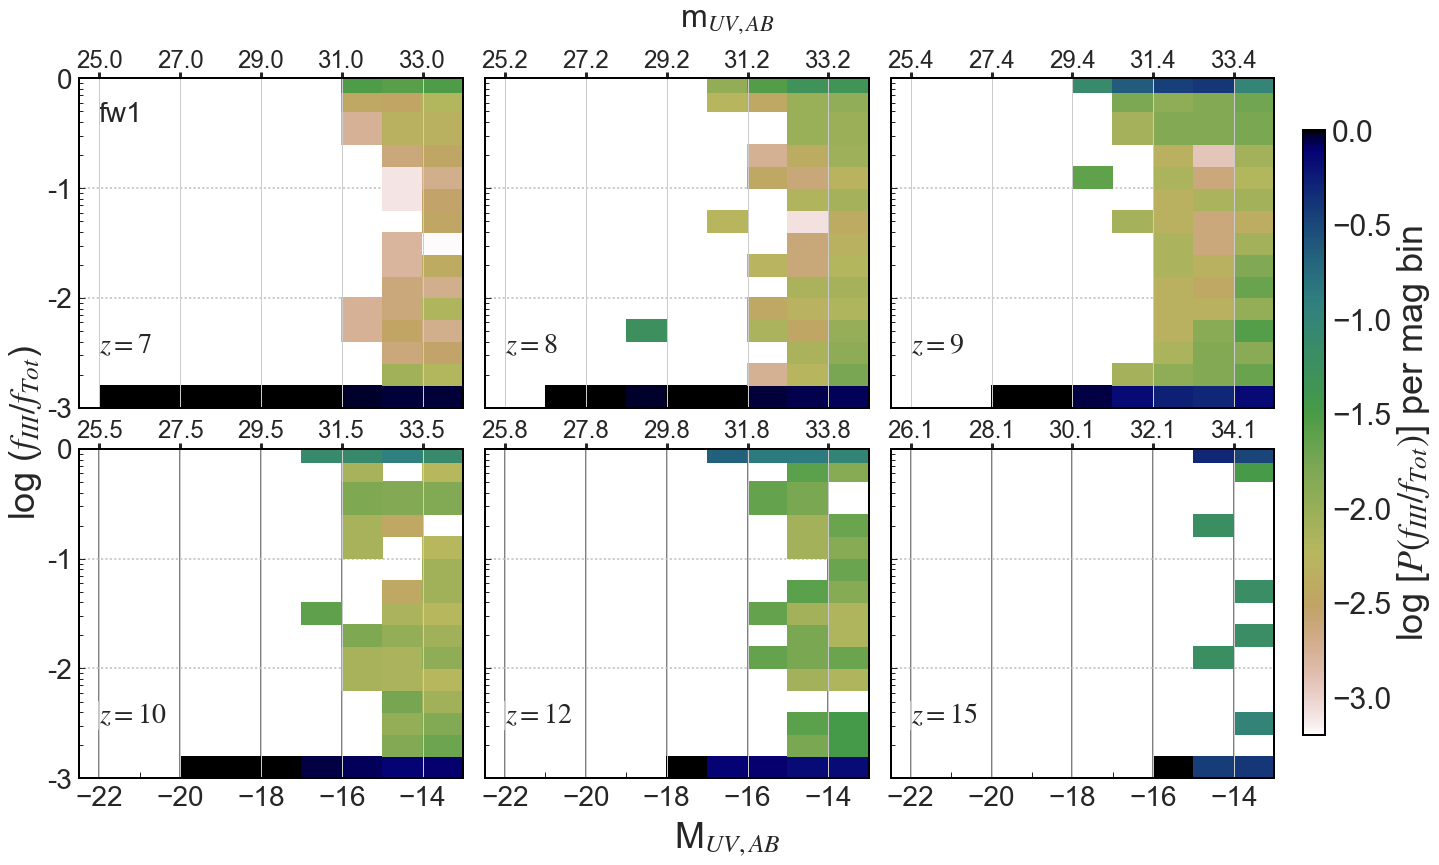

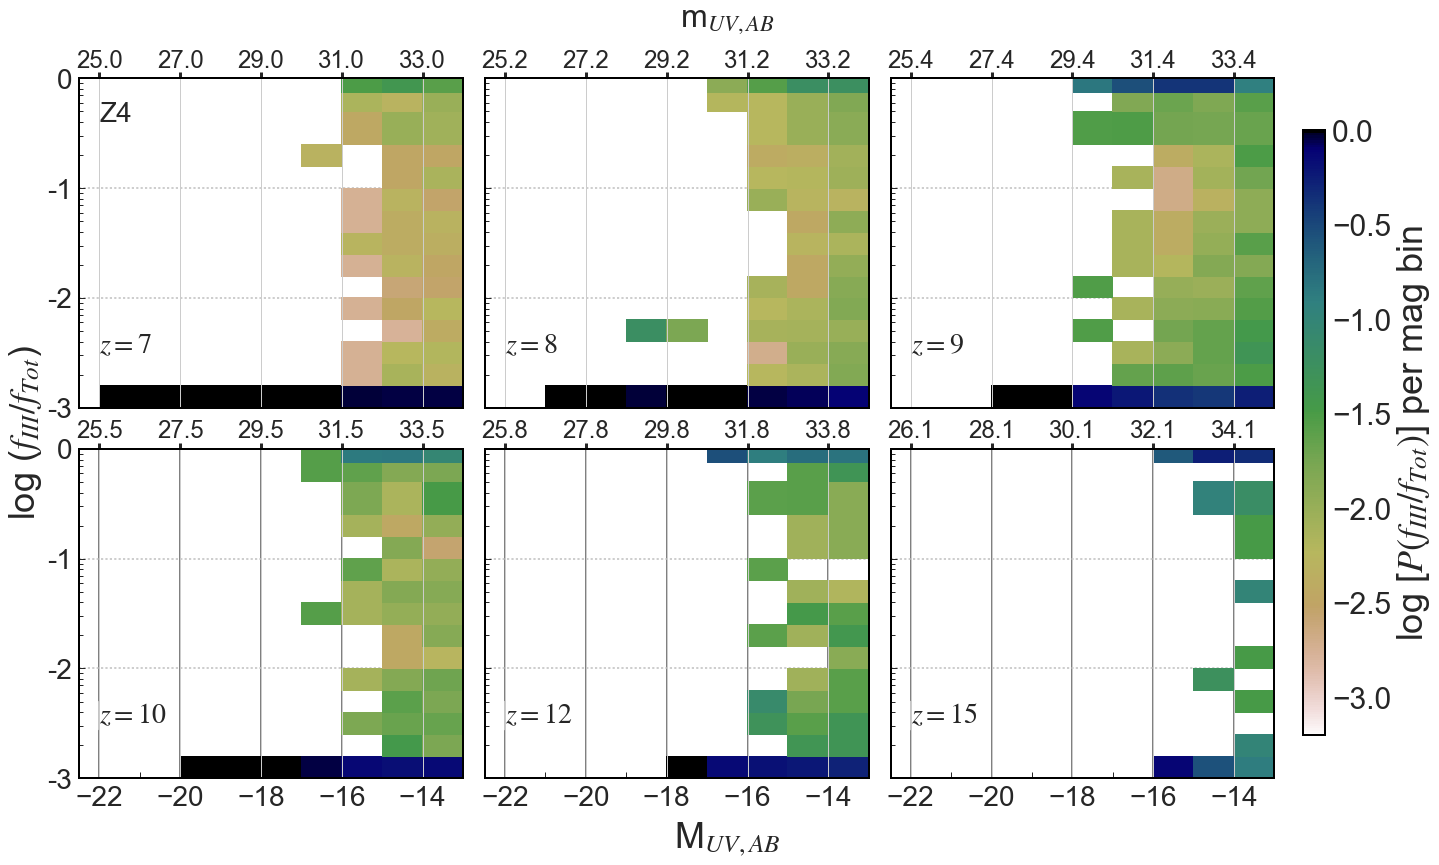

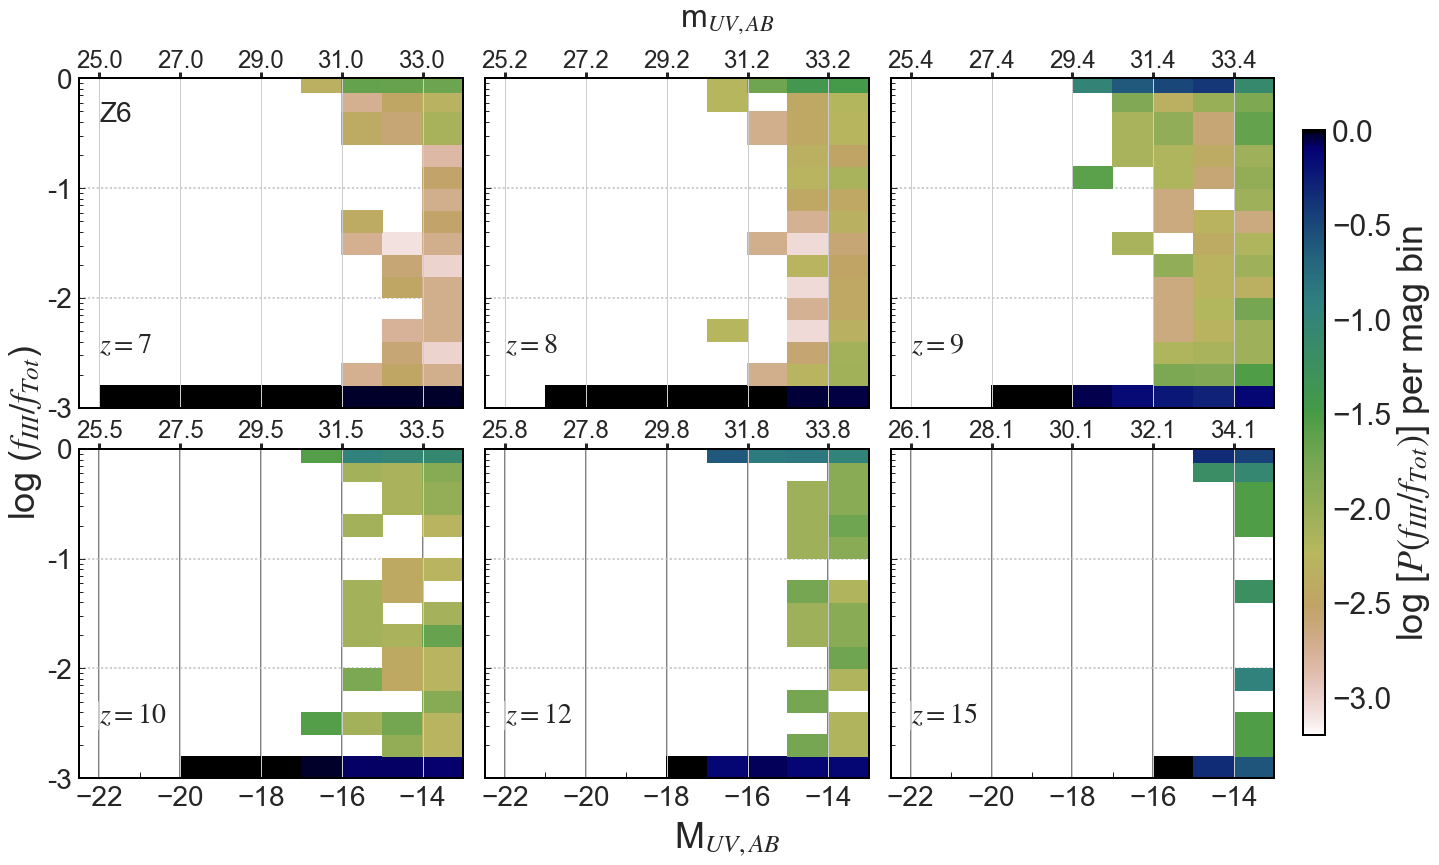

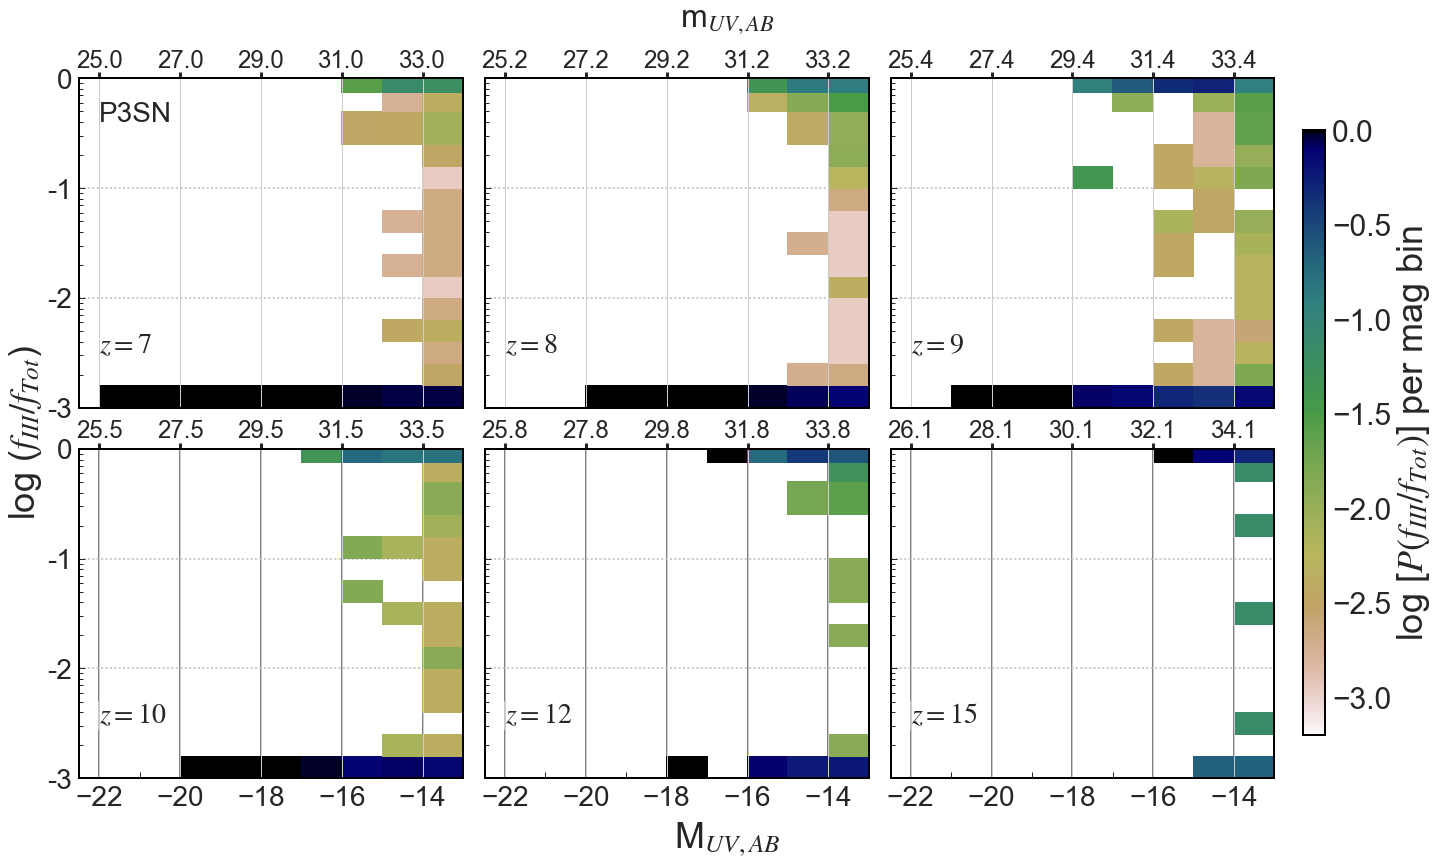

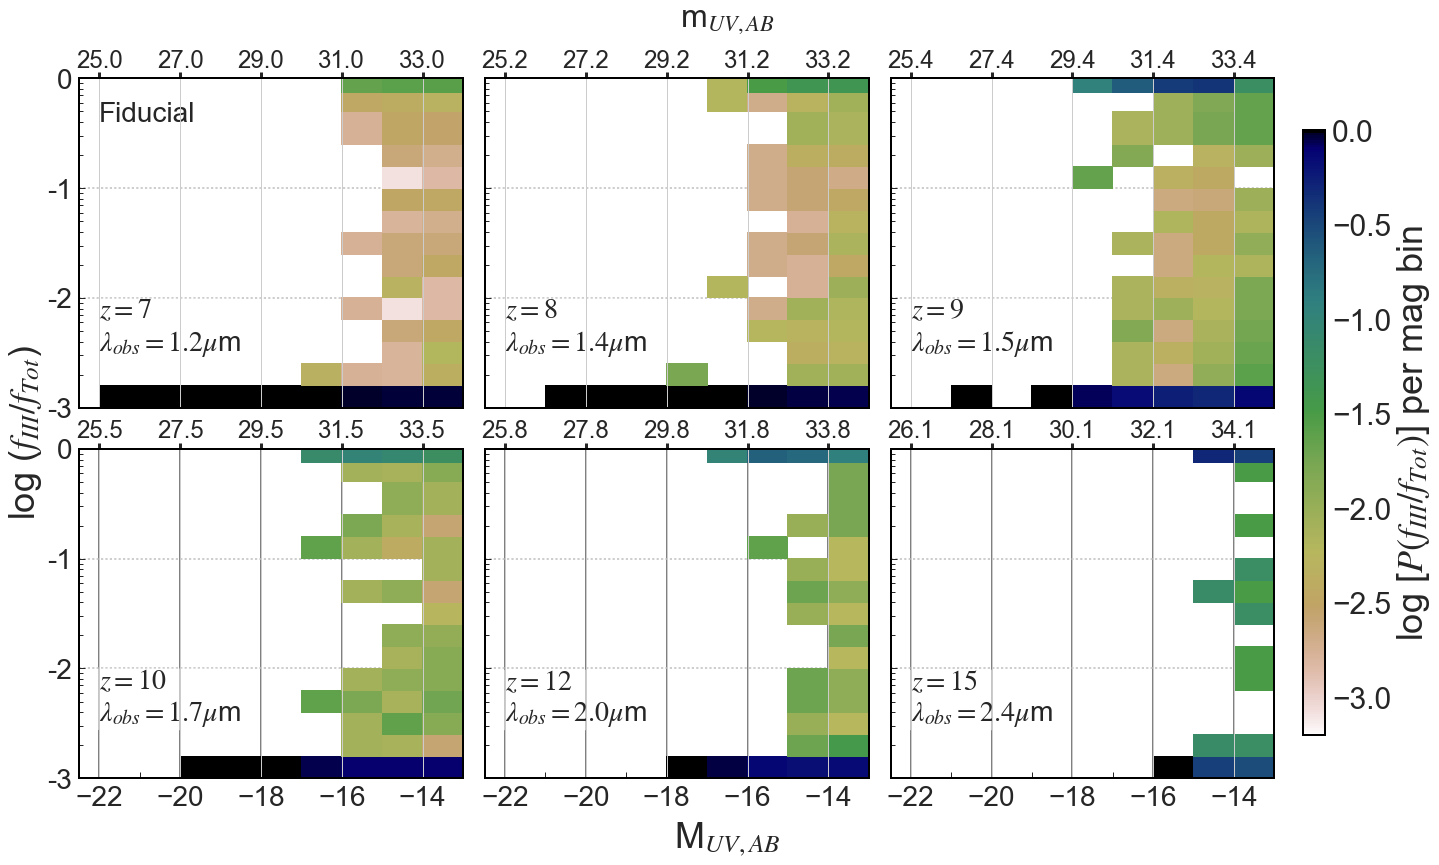

In [70]:
# Normalize the probability in each row such that it totals to 1.0


#
# No classical Pop III
#

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))


baseline = 'Fiducial'


p3ff ={}
p3ffMix = {}
doNMnow = False
for dir in ['fw1', 'Z4', 'Z6', 'P3SN','Fiducial']:
    fig, axs = plt.subplots(nrows=2, ncols=3, sharex='col',sharey='row',figsize=(20,12))
    for z,ax in zip([7,8,9,10,12,15], axs.flat):

        if z not in thezs:
            continue

        # Convert observed magnitude to Absolute ...
        absMag, pop3Mag, nmAbsMag   = compMags(dir,z)
        # Map 0 Pop 3 flux to 1e-3... 
        pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
        p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
        print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
        pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

        print("Working on z={}".format(z))
        # If we are back to z = 8,9,10 then generate plots for NO Mixing
        Ng = len(absMag) # Number of galaxies at this z
        print("Number of galaxies {}".format(Ng))
        # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
        # both the improved Pop III luminosity and the classical

        # Note that we are reversing x,y here since pcolormesh interprets them backwards!
        nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
        # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
        # normed : bool, optional
        #        If False, returns the number of samples in each bin. If True, returns the bin density 
        #        bin_count / sample_count / bin_area.

        X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

        # Mask out 0 values before taking log10... 
        H = np.ma.masked_where(nTempA==0.0, nTempA)
        for i in range(len(H[0,:])):     # Column index i, over len of row 0
            colTot = np.sum(H[:,i])
            for j in range(len(H[:,0])): # Row index j, over len of column 0
                H[:,i][j] = H[:,i][j]/colTot
        H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
        print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
        # Create the plot
        im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )

        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.yaxis.set_tick_params(which='major',width=1,length=6)
        ax.yaxis.set_tick_params(which='minor',width=1,length=4)
        ax.xaxis.set_tick_params(which='both',width=1,length=6)
        ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
        minorLocator = ticker.MultipleLocator(1)
        ax.xaxis.set_minor_locator(minorLocator)
        ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
        ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
        ax.yaxis.set_major_formatter(logfmt)
        ax.set_xlim([brightM-0.5,limitM])
        ax.set_ylim([1e-3,1.0])
        ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
        ax.grid(which='major', axis='x', color='0.5', linestyle='-', linewidth=2.0)

        if dir == 'Fiducial':
            ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
        else:
            ax.annotate('$z={}$'.format(z), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
        if z >= 10:
            ax.xaxis.set_visible(True)
        else:
            ax.xaxis.set_visible(False)
        if z == 7:
            ax.annotate('{}'.format(dir), xy = (0.5, 0.5), 
                xytext = (0.052, 0.85), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)

        
        # Top x-axis labels ... m_ab
        ax2 = ax.twiny()
        ax2.set_xlim([brightM-0.5,limitM]) # required...
        axXtics = ax.get_xticks()
        ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
        ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
        ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
        ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
        ax2.get_xaxis().set_tick_params(labelsize=24)

        # plt.gca().invert_xaxis()
        gc.collect()

    plt.subplots_adjust(left=0.05, bottom=0.1, right=.88, top=0.91, wspace=.057, hspace=.125)

    fig.text(0.5, 0.97,'m$_{UV,AB}$', ha='center',size=32 )
    fig.text(0.5, 0.02,'M$_{UV,AB}$', ha='center',size=36 )
    fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

    # Create the colorbar
    cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)

    cbar.ax.tick_params(labelsize=30) 
    #cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
    cbar.set_label("log [$P(f_{III}/f_{Tot})$] per mag bin",fontsize=36)
    plt.savefig("PopIII_fraction-Hist{}.pdf".format(dir),dpi=fig.dpi,bbox_inches='tight')
    doNMnow = False
    gc.collect()

# Plot delta's


In [57]:
thezs=[7,8,9,10,12,15]

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.80 @ z=12.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.14437 at z=12
Working on z=12
Number of galaxies 554
fw1
[[   0.    0.    0.    0.    2.    7.   35.   82.  103.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    5.]
 [   0.    0.    0.    0.    0.    0.    0.    3.    5.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    1.]
 [   0.    0.    0.    0.    0.    0.    1.    2.    3.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    1.]
 [   0.    0.    0.    0.    0.    0.    1.    1.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    3.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    3.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    3.]
 [   0.    0.    0.    0.    0.    0.    1.    2.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    3.    2.]
 [   

/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 538 but corresponding boolean dimension is 87
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 110 but corresponding boolean dimension is 554


Convert to Abs Mag. DM = 47.80 @ z=12.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.18043 at z=12
Working on z=12
Number of galaxies 536
Z4
[[  0.   0.   0.   0.   2.   5.  26.  69.  81.]
 [  0.   0.   0.   0.   0.   0.   0.   5.   7.]
 [  0.   0.   0.   0.   0.   0.   2.   3.   7.]
 [  0.   0.   0.   0.   0.   0.   3.   2.   4.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   4.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   2.]
 [  0.   0.   0.   0.   0.   0.   1.   1.   6.]
 [  0.   0.   0.   0.   0.   0.   0.   4.   4.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   1.]
 [  0.   0.   0.   0.   0.   0.   1.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   2.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   2.]
 [  0.   0.   0.   0.   0.   0.   1.   3.   2.]
 [  0.   0.   0.   0.   0.   0.   0.   3.   7.]
 [  0.   0.   0.   0.   0.   2.   5.  20.  24.]]
Convert to Abs Mag. DM = 48.12 @ z=15.0
Convert to Abs Mag. DM = 48.12 @ z=15.0
Pop III flux fraction is 0.46939 at 

/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 538 but corresponding boolean dimension is 107
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 110 but corresponding boolean dimension is 536


Convert to Abs Mag. DM = 47.80 @ z=12.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.14070 at z=12
Working on z=12
Number of galaxies 536
Z6
[[   0.    0.    0.    0.    2.    6.   32.   84.  115.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    3.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    3.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    2.]
 [   0.    0.    0.    0.    0.    2.  

/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 538 but corresponding boolean dimension is 109


Convert to Abs Mag. DM = 47.80 @ z=12.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.31085 at z=12
Working on z=12
Number of galaxies 535
P3SN
[[  0.   0.   0.   0.   2.   0.  13.  33.  48.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   2.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   4.]
 [  0.   0.   0.   0.   0.   3.   3.  22.  21.]]
Convert to Abs Mag. DM = 48.12 @ z=15.0
Convert to Abs Mag. DM = 48.12 @ z=15.0
Pop III flux fraction is 0.59389 a

/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 110 but corresponding boolean dimension is 535


Convert to Abs Mag. DM = 47.80 @ z=12.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.16505 at z=12
Working on z=12
Number of galaxies 538
Fiducial
[[   0.    0.    0.    0.    1.    9.   31.   68.  122.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    6.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    3.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    2.    2.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    1.]
 [   0.    0.    0.    0.    0.    0.    1.    0.    1.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    3.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    3.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    3.]
 [   0.    0.    0.    0.    0.  

/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 110 but corresponding boolean dimension is 538


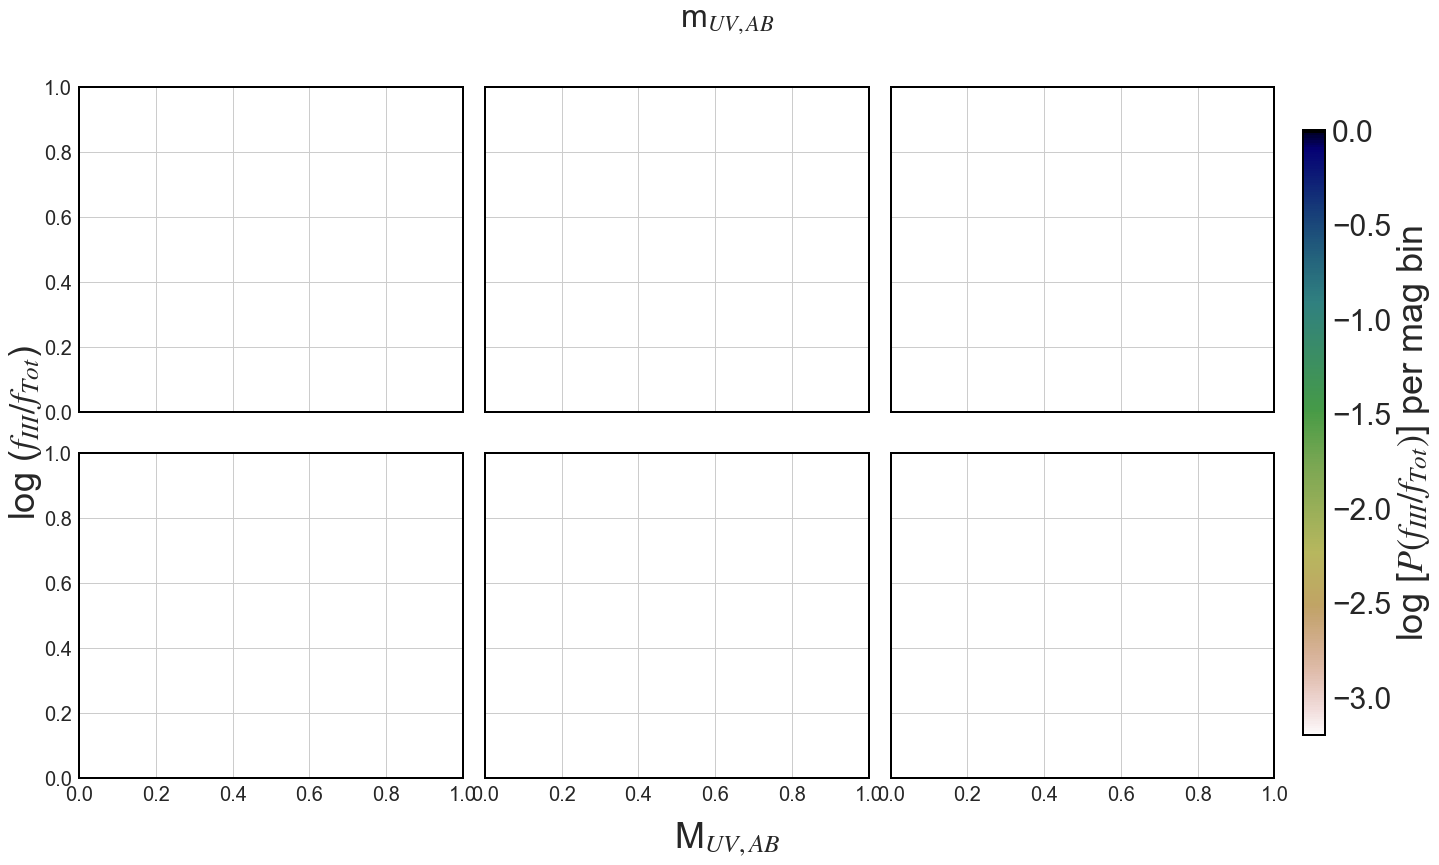

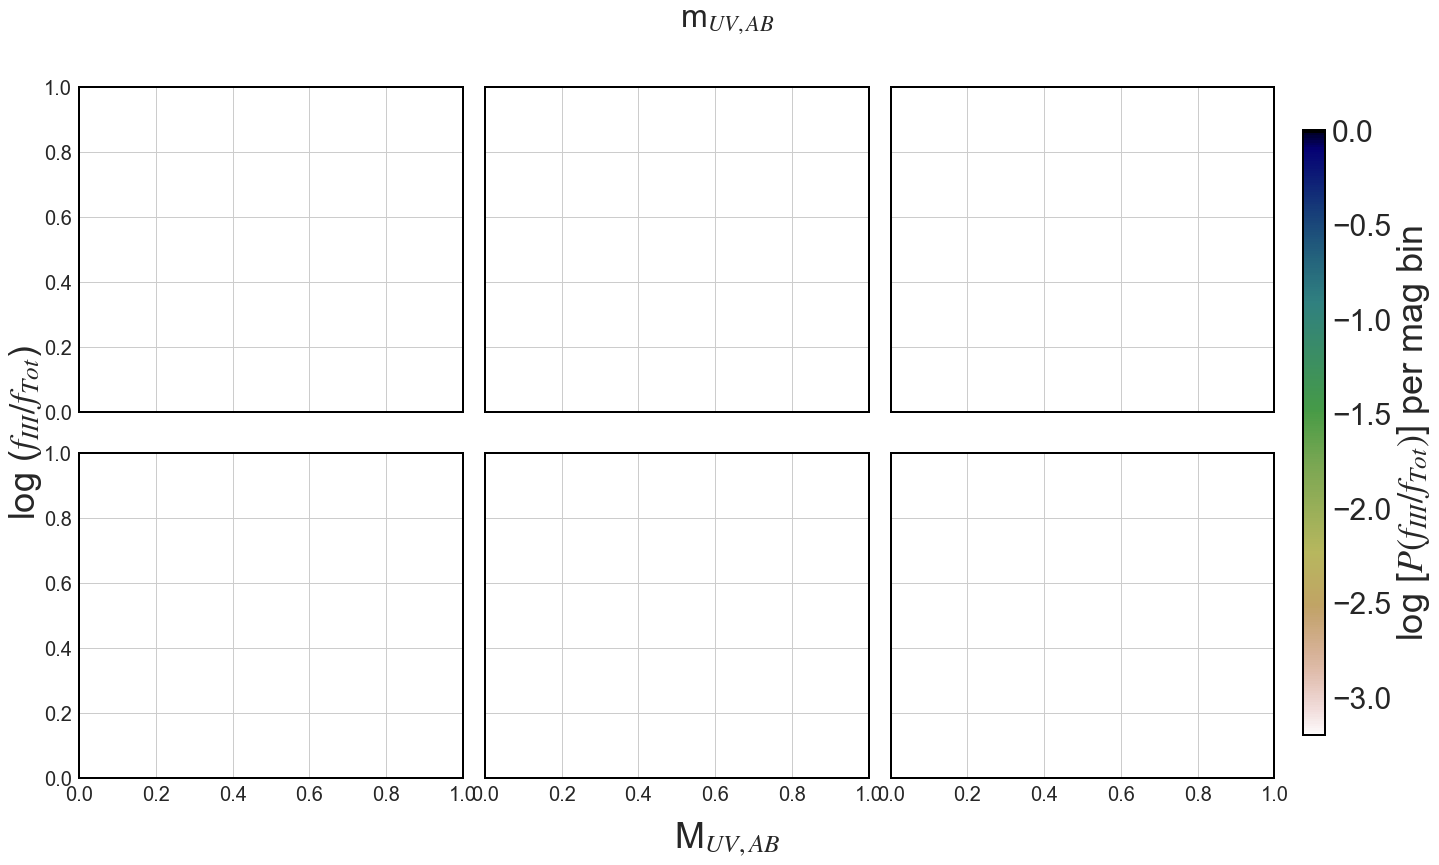

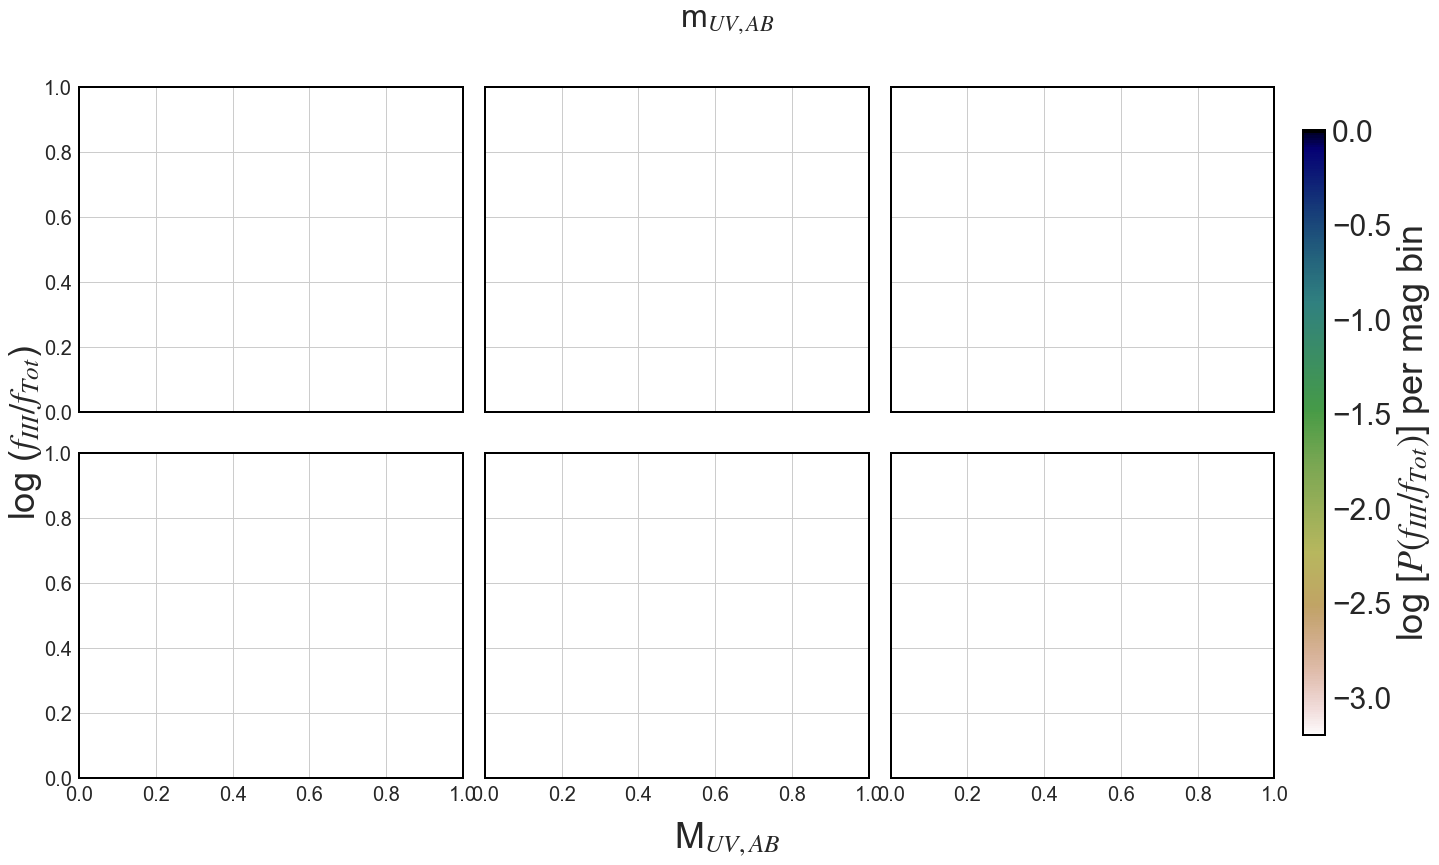

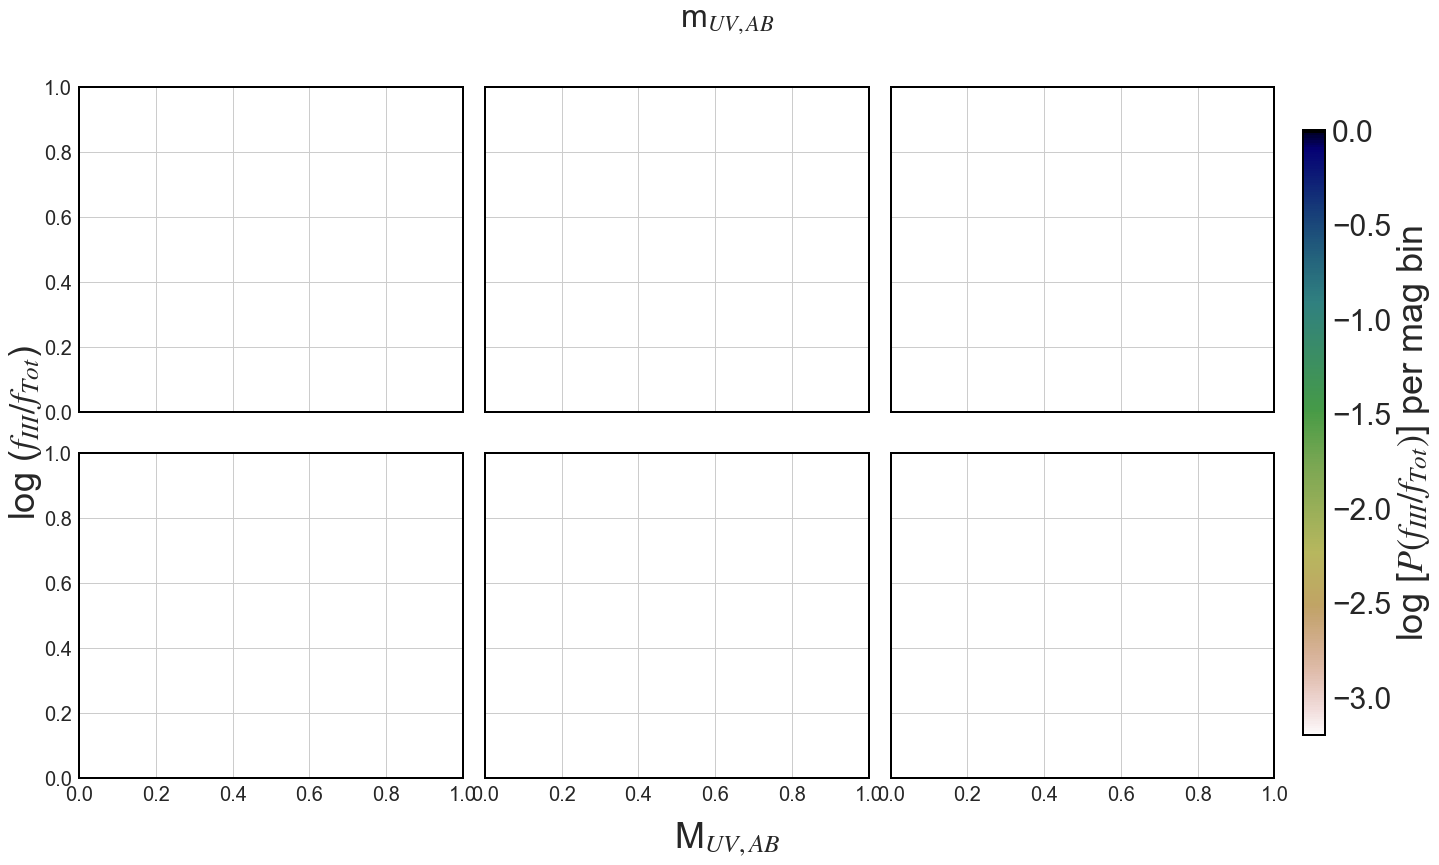

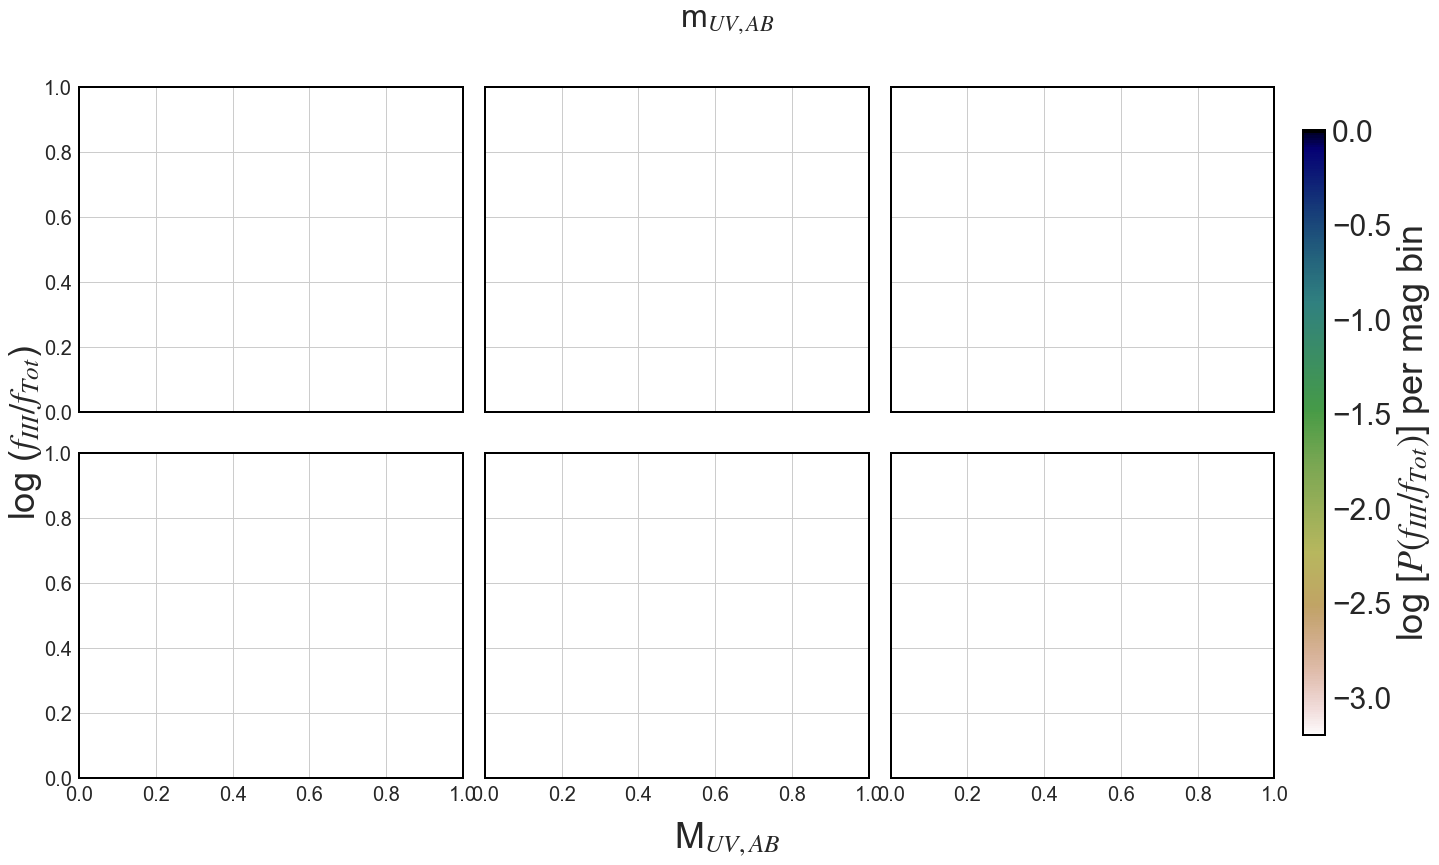

In [73]:
# Normalize the probability in each row such that it totals to 1.0


#
# Plot DIFFERENCES in Pop III flux ... How to display???? 
#

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))


baseline = 'Fiducial'


p3ff ={}
p3ffFid = {}
doNMnow = False
# for dir in ['fw1', 'Z4', 'Z6', 'P3SN']:
for dir in ['fw1', 'Z4', 'Z6', 'P3SN','Fiducial']:
    fig, axs = plt.subplots(nrows=2, ncols=3, sharex='col',sharey='row',figsize=(20,12))
#     for z,ax in zip([7,8,9,10,12,15], axs.flat):
    for z,ax in zip([12,15], axs.flat):

        if z not in thezs:
            continue
            
        # Compute baseline
        absMagFid, pop3MagFid, nmAbsMagFid   = compMags(baseline,z)
        # Map 0 Pop 3 flux to 1e-3... 
        pop3FractionFid = haloData[baseline][z]['1500A_P3']/haloData[baseline][z]['1500A']
        p3ffFid[z] = haloData[baseline][z]['1500A_P3'].sum()/haloData[baseline][z]['1500A'].sum()
        pop3FractionFid[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        ################

        # Convert observed magnitude to Absolute ...
        absMag, pop3Mag, nmAbsMag   = compMags(dir,z)
        # Map 0 Pop 3 flux to 1e-3... 
        pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
        p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
        print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
        pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

        print("Working on z={}".format(z))
        # If we are back to z = 8,9,10 then generate plots for NO Mixing
        Ng = len(absMag) # Number of galaxies at this z
        print("Number of galaxies {}".format(Ng))
        # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
        # both the improved Pop III luminosity and the classical

        # Note that we are reversing x,y here since pcolormesh interprets them backwards!
        nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
#         nTempAFid, binsxFid, binsyFid = np.histogram2d(pop3FractionFid,absMagFid,bins=[fracBins,magBins],normed=False)
    
#         nTempA = nTempA-nTempAFid
        print(dir)
        print(nTempA)
        continue
        
        X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

        # Mask out 0 values before taking log10... 
        H = np.ma.masked_where(nTempA==0.0, nTempA)
        for i in range(len(H[0,:])):     # Column index i, over len of row 0
            colTot = np.sum(H[:,i])
            for j in range(len(H[:,0])): # Row index j, over len of column 0
                H[:,i][j] = H[:,i][j]/colTot
        H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
        print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
        # Create the plot
        im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )

        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.yaxis.set_tick_params(which='major',width=1,length=6)
        ax.yaxis.set_tick_params(which='minor',width=1,length=4)
        ax.xaxis.set_tick_params(which='both',width=1,length=6)
        ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
        minorLocator = ticker.MultipleLocator(1)
        ax.xaxis.set_minor_locator(minorLocator)
        ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
        ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
        ax.yaxis.set_major_formatter(logfmt)
        ax.set_xlim([brightM-0.5,limitM])
        ax.set_ylim([1e-3,1.0])
        ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
        ax.grid(which='major', axis='x', color='0.5', linestyle='-', linewidth=2.0)


        ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
        if z >= 10:
            ax.xaxis.set_visible(True)
        else:
            ax.xaxis.set_visible(False)
        if z == 7:
            ax.annotate('{}'.format(dir), xy = (0.5, 0.5), 
                xytext = (0.052, 0.85), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)

        
        # Top x-axis labels ... m_ab
        ax2 = ax.twiny()
        ax2.set_xlim([brightM-0.5,limitM]) # required...
        axXtics = ax.get_xticks()
        ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
        ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
        ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
        ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
        ax2.get_xaxis().set_tick_params(labelsize=24)

        # plt.gca().invert_xaxis()
        gc.collect()

    plt.subplots_adjust(left=0.05, bottom=0.1, right=.88, top=0.9, wspace=.057, hspace=.125)

    fig.text(0.5, 0.97,'m$_{UV,AB}$', ha='center',size=32 )
    fig.text(0.5, 0.02,'M$_{UV,AB}$', ha='center',size=36 )
    fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')
    
    # Create the colorbar
    cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)

    cbar.ax.tick_params(labelsize=30) 
    #cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
    cbar.set_label("log [$P(f_{III}/f_{Tot})$] per mag bin",fontsize=36)
#     plt.savefig("PopIII_fraction-Hist-diff-{}.pdf".format(dir),dpi=fig.dpi,bbox_inches='tight')
    doNMnow = False
    gc.collect()

In [76]:
np.array([0.11363636363636363, 0.19083969465648856, 0.17682926829268292, 0.05319148936170213/2]).sum()

0.50790107126638617

In [29]:
magBins

array([-22., -21., -20., -19., -18., -17., -16., -15., -14., -13.])

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.01515 at z=8
Working on z=8
Number of galaxies 4563
Largest bin value: 0.000, smallest -2.741151598851785
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.11445 at z=9
Working on z=9
Number of galaxies 1468
Largest bin value: 0.000, smallest -2.6720978579357175


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:58: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Working on z=10
Number of galaxies 1021
Largest bin value: 0.000, smallest -2.54282542695918
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.07623 at z=11
Working on z=11
Number of galaxies 687
Largest bin value: 0.000, smallest -2.2095150145426308
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.14715 at z=12
Working on z=12
Number of galaxies 451
Largest bin value: 0.000, smallest -2.1986570869544226
Convert to Abs Mag. DM = 47.92 @ z=13.0


KeyError: 13

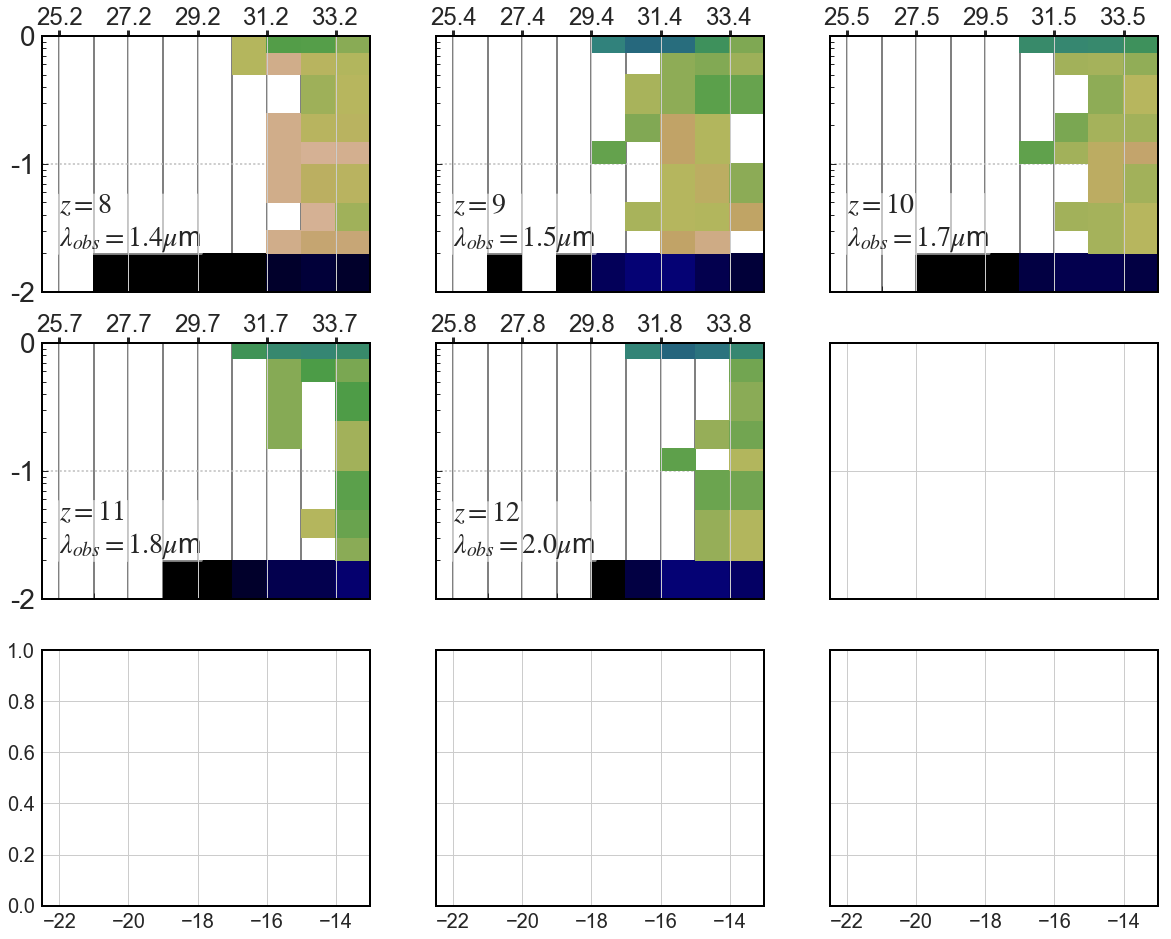

In [32]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-2,0,13)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [ 0.01, 0.02, 0.03, 0.05, 0.1,  0.15,  0.25,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
fig, axs = plt.subplots(nrows=3, ncols=3, sharex='col',sharey='row',figsize=(20,16))
for z,ax in zip([8,9,10,11,12,13,14,15,16], axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 0.01] = 0.01  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing

    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([0.01,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)
    
    ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)


    # plt.gca().invert_xaxis()
    gc.collect()
    
plt.subplots_adjust(left=0.05, bottom=0.08, right=.88, top=0.92, wspace=.057, hspace=.125)

fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
fig.text(0.5, 0.04,'M$_{UV,AB}$', ha='center',size=36 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=30) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
plt.savefig("PopIII_fraction-Histograms-all9-noClassic-largeOnly.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.11445 at z=9
Working on z=9
Number of galaxies 1468
Largest bin value: 0.000, smallest -2.6720978579357175


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:71: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Working on z=10
Number of galaxies 1021
Largest bin value: 0.000, smallest -2.54282542695918
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.07623 at z=11
Working on z=11
Number of galaxies 687
Largest bin value: 0.000, smallest -2.367355921026019
FINISHED with z=8-12
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.11445 at z=9
Working on z=9
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=9 overall mixing p3ff=0.114, no mixing p3ff=0.042
z=9 PopIII mixing/no mixing=2.860
Number of galaxies 1468
Largest bin value: 0.000, smallest -2.678518379040114
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Working on z=10
************************************************************
Working on the NON MIXING flux f

18976

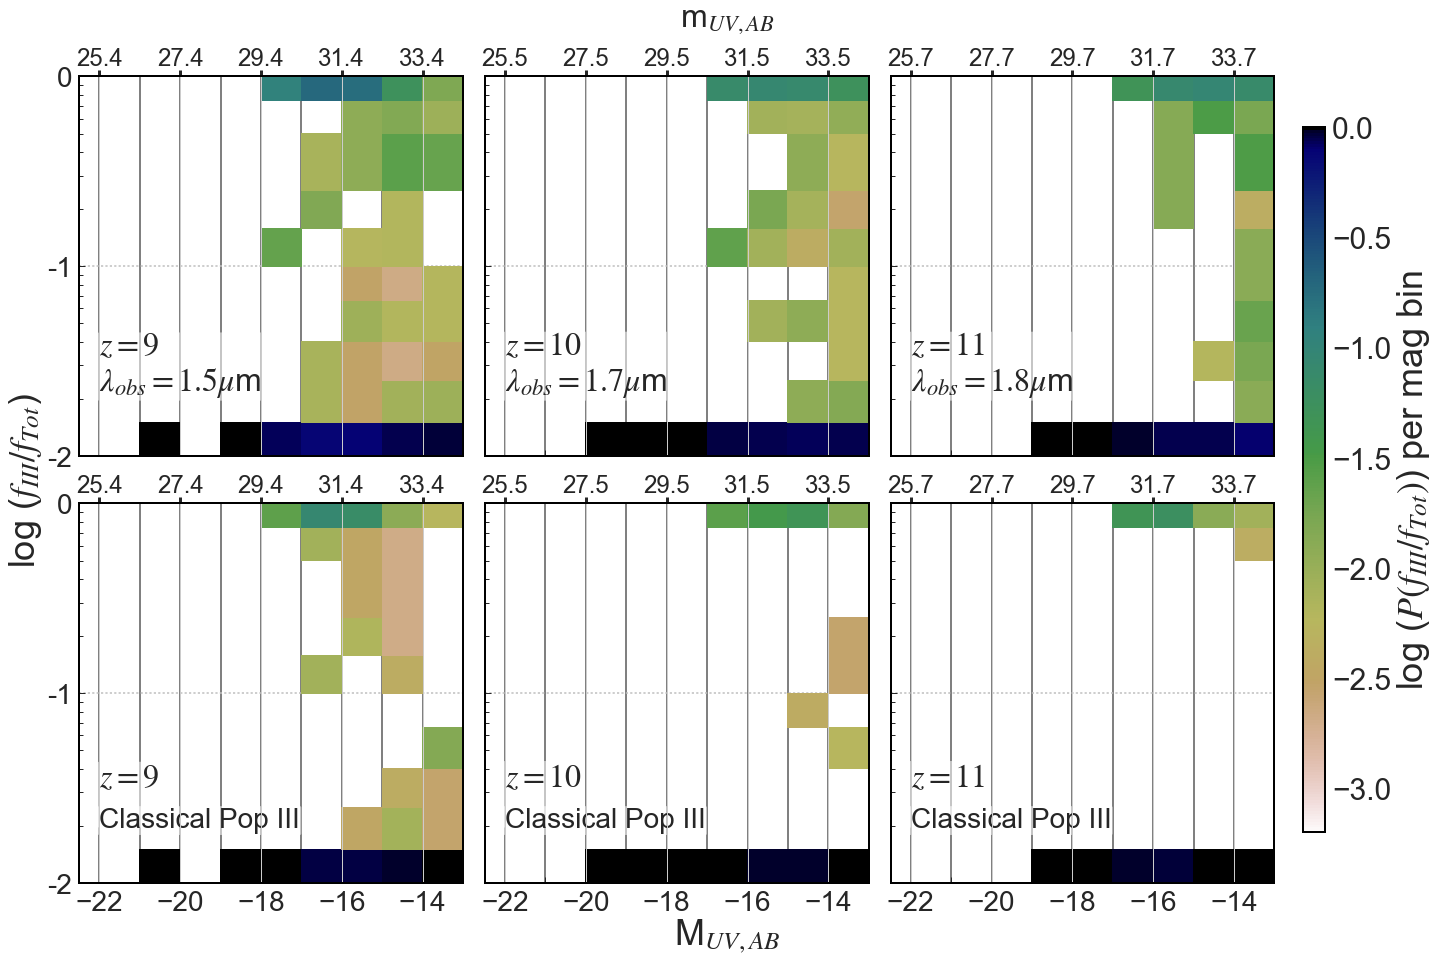

In [33]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [ 0.01,  0.015,  0.025,  0.040,  0.066,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
fig, axs = plt.subplots(nrows=2, ncols=3, sharex='col',sharey='row',figsize=(20,14))
z_range = np.array([9,10,11,9,10,11])
for z,ax in zip(z_range, axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-2] = 1e-2  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing
    if doNMnow:
        print("************************************************************")
        print("Working on the NON MIXING flux fractions for or galaxies ...")
        print("************************************************************")
        pop3Fraction = haloData[dir][z]['1500A_P3NM']/haloData[dir][z]['1500A_NM']
        p3ff[z] = haloData[dir][z]['1500A_P3NM'].sum()/haloData[dir][z]['1500A_NM'].sum()
#         print("Pop III flux fraction is {:.5f} at z={}".format(p3ffNM[z],z))
        pop3Fraction[pop3Fraction < 1e-2] = 1e-2  # Map Pop 3 flux < 1e-3 to 1e-3
        absMag = nmAbsMag ## Do plots for NO MIXING version of data... 
        print("z={} overall mixing p3ff={:.3f}, no mixing p3ff={:.3f}".format(z,p3ffMix[z],p3ff[z]))
        print("z={} PopIII mixing/no mixing={:.3f}".format(z,haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A_P3NM'].sum()))
        
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-2,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    if doNMnow:
        ax.annotate('$z={}$\n'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)
        ax.annotate('Classical Pop III'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.13), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
    else:
        ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)

    
    ####
    #### If we just finished z=16, do z=8,9,10 for 
    #### no mixing case
    ####
    if z == z_range.max():
        print("FINISHED with z=8-12")
        doNMnow = True

plt.subplots_adjust(left=0.05, bottom=0.1, right=.88, top=0.90, wspace=.057, hspace=.125)

fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
fig.text(0.5, 0.04,'M$_{UV,AB}$', ha='center',size=36 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=30) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
plt.savefig("PopIII_fraction-Histograms-3.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.01515 at z=8
Working on z=8
Number of galaxies 4563
Largest bin value: 0.000, smallest -2.741151598851785


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:60: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Working on z=10
Number of galaxies 1021
Largest bin value: 0.000, smallest -2.54282542695918
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.14715 at z=12
Working on z=12
Number of galaxies 451
Largest bin value: 0.000, smallest -2.1986570869544226
Convert to Abs Mag. DM = 48.03 @ z=14.0
Pop III flux fraction is 0.26543 at z=14
Working on z=14
Number of galaxies 174
Largest bin value: -0.176, smallest -1.662757831681574
Convert to Abs Mag. DM = 48.12 @ z=15.0
Pop III flux fraction is 0.31926 at z=15
Working on z=15
Number of galaxies 94
Largest bin value: 0.000, smallest -1.4471580313422192
Convert to Abs Mag. DM = 48.21 @ z=16.0
Pop III flux fraction is 0.30913 at z=16
Working on z=16
Number of galaxies 52
Largest bin value: 0.000, smallest -1.146128035678238


13617

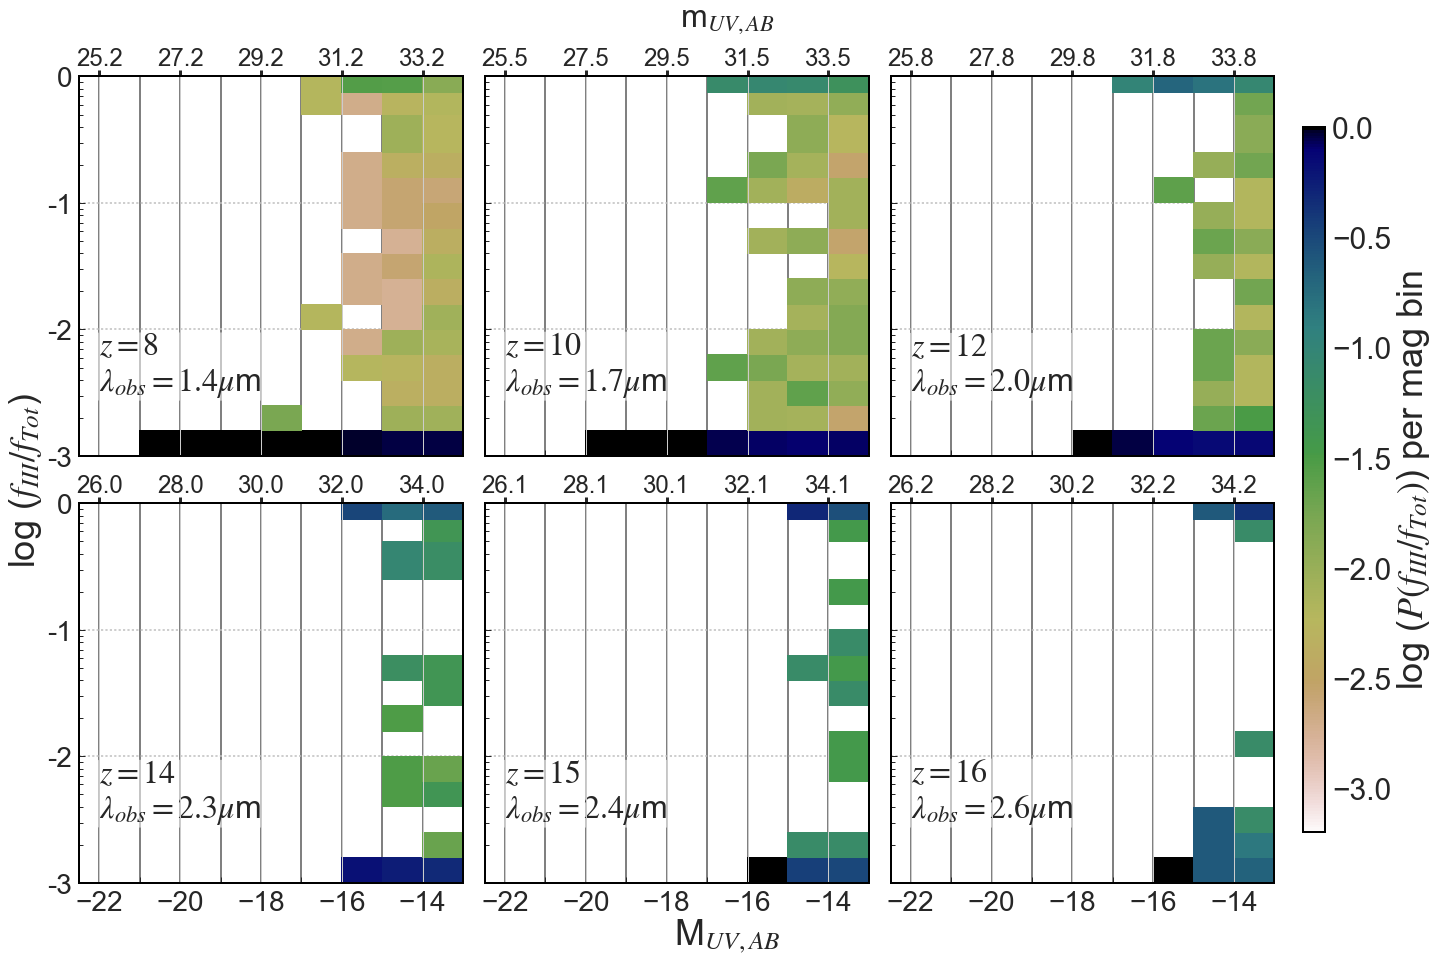

In [34]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
fig, axs = plt.subplots(nrows=2, ncols=3, sharex='col',sharey='row',figsize=(20,14))
for z,ax in zip([8,10,12,14,15,16], axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing

    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-3,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)
    
    ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)


    # plt.gca().invert_xaxis()
    gc.collect()
    
plt.subplots_adjust(left=0.05, bottom=0.1, right=.88, top=0.90, wspace=.057, hspace=.125)

fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
fig.text(0.5, 0.04,'M$_{UV,AB}$', ha='center',size=36 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=30) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
plt.savefig("PopIII_fraction-Histograms-all6-noClassic.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.01515 at z=8
Working on z=8
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=8 overall mixing p3ff=0.015, no mixing p3ff=0.003
z=8 PopIII mixing/no mixing=4.720
Number of galaxies 4563
Largest bin value: 0.000, smallest -3.218535505216528
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.11445 at z=9
Working on z=9
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=9 overall mixing p3ff=0.114, no mixing p3ff=0.042
z=9 PopIII mixing/no mixing=2.860
Number of galaxies 1468
Largest bin value: 0.000, smallest -2.678518379040114


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:71: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Working on z=10
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=10 overall mixing p3ff=0.055, no mixing p3ff=0.023
z=10 PopIII mixing/no mixing=2.410
Number of galaxies 1021
Largest bin value: 0.000, smallest -2.545307116465824


12358

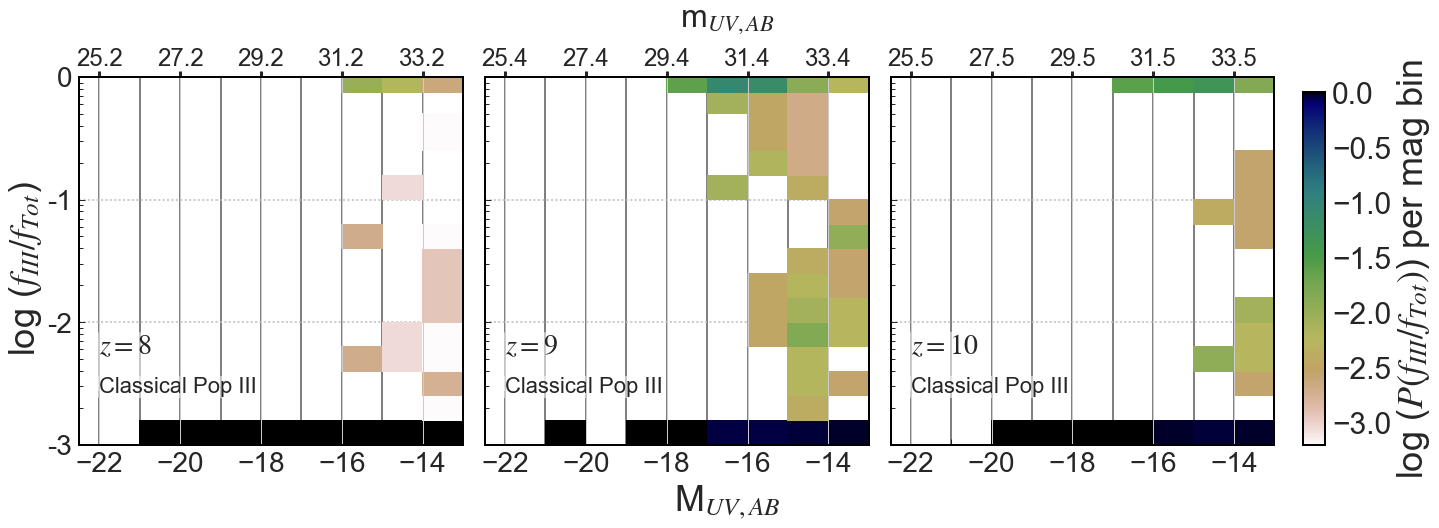

In [35]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = True
fig, axs = plt.subplots(nrows=1, ncols=3, sharex='col',sharey='row',figsize=(20,7))
for z,ax in zip([8,9,10], axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing
    if doNMnow:
        print("************************************************************")
        print("Working on the NON MIXING flux fractions for or galaxies ...")
        print("************************************************************")
        pop3Fraction = haloData[dir][z]['1500A_P3NM']/haloData[dir][z]['1500A_NM']
        p3ff[z] = haloData[dir][z]['1500A_P3NM'].sum()/haloData[dir][z]['1500A_NM'].sum()
#         print("Pop III flux fraction is {:.5f} at z={}".format(p3ffNM[z],z))
        pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        absMag = nmAbsMag ## Do plots for NO MIXING version of data... 
        print("z={} overall mixing p3ff={:.3f}, no mixing p3ff={:.3f}".format(z,p3ffMix[z],p3ff[z]))
        print("z={} PopIII mixing/no mixing={:.3f}".format(z,haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A_P3NM'].sum()))
        
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-3,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    if doNMnow:
        ax.annotate('$z={}$\n'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
        ax.annotate('Classical Pop III'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.13), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=22)
    else:
        ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)


plt.subplots_adjust(left=0.05, bottom=0.15, right=.88, top=0.88, wspace=.057, hspace=.125)

fig.text(0.5, 0.98,'m$_{UV,AB}$', ha='center',size=32 )
fig.text(0.5, 0.02,'M$_{UV,AB}$', ha='center',size=36 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=30) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
plt.savefig("PopIII_fraction-Histograms-Classic.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.11445 at z=9
Working on z=9
Number of galaxies 1468
Largest bin value: 0.000, smallest -2.6720978579357175
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Working on z=10
Number of galaxies 1021
Largest bin value: 0.000, smallest -2.54282542695918


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:72: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.07623 at z=11
Working on z=11
Number of galaxies 687
Largest bin value: 0.000, smallest -2.367355921026019
FINISHED with z=8-12
Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.11445 at z=9
Working on z=9
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=9 overall mixing p3ff=0.114, no mixing p3ff=0.042
z=9 PopIII mixing/no mixing=2.860
Number of galaxies 1468
Largest bin value: 0.000, smallest -2.678518379040114
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Working on z=10
************************************************************
Working on the NON MIXING flux fractions for or galaxies ...
************************************************************
z=10 overall mixing p3ff=0.055, no mixing p3ff=0.023
z=10 PopIII mixing/no mixing=2.

4541

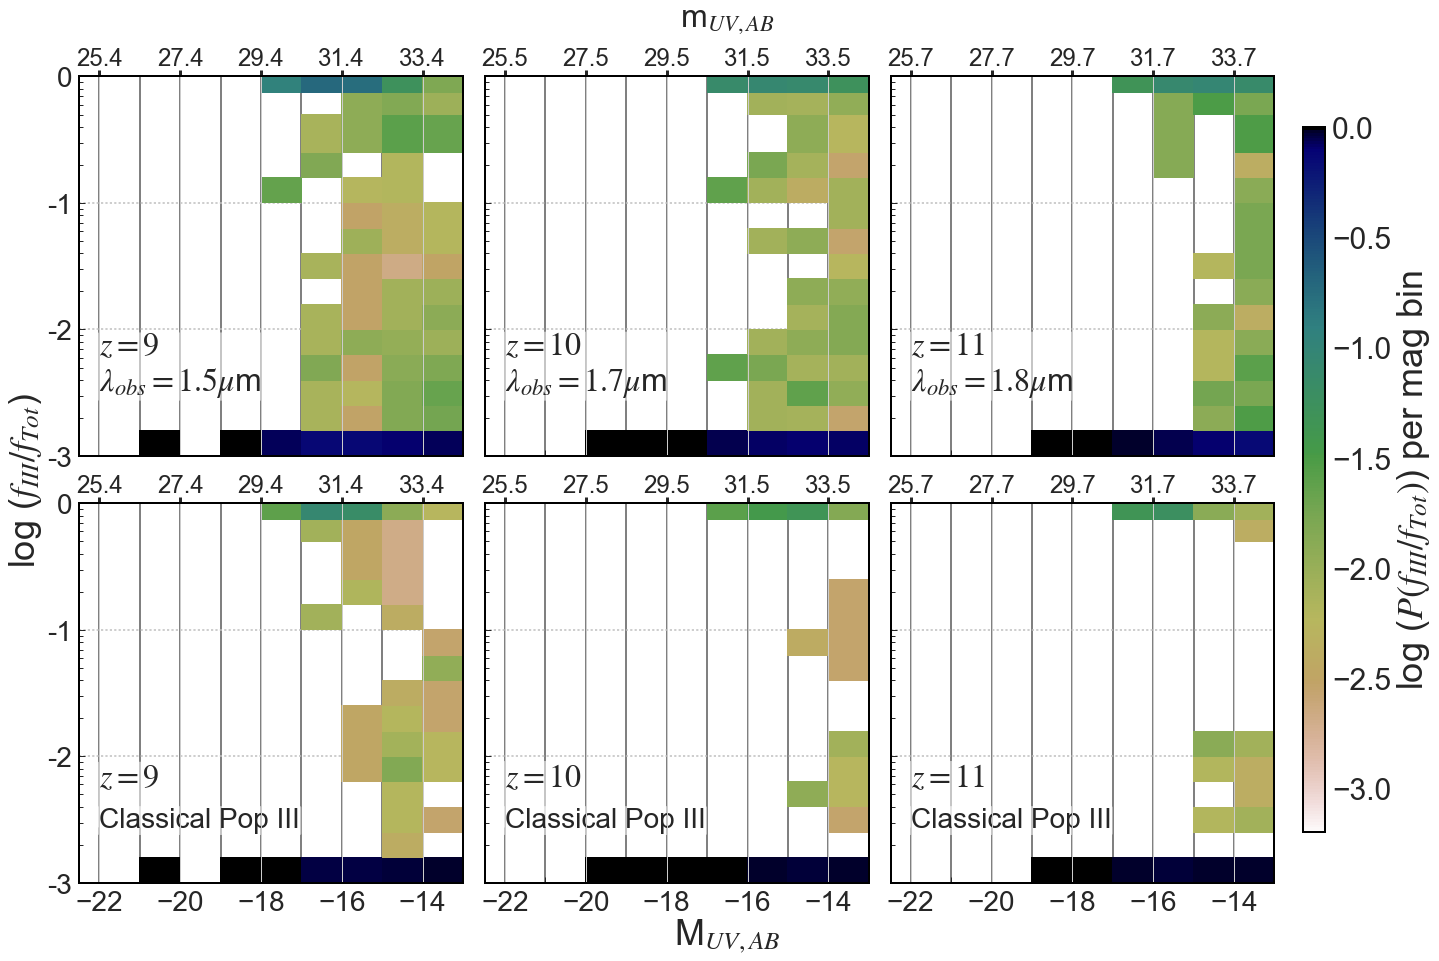

In [36]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
fig, axs = plt.subplots(nrows=2, ncols=3, sharex='col',sharey='row',figsize=(20,14))
z_range = np.array([9,10,11,9,10,11])
for z,ax in zip(z_range, axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing
    if doNMnow:
        print("************************************************************")
        print("Working on the NON MIXING flux fractions for or galaxies ...")
        print("************************************************************")
        pop3Fraction = haloData[dir][z]['1500A_P3NM']/haloData[dir][z]['1500A_NM']
        p3ff[z] = haloData[dir][z]['1500A_P3NM'].sum()/haloData[dir][z]['1500A_NM'].sum()
#         print("Pop III flux fraction is {:.5f} at z={}".format(p3ffNM[z],z))
        pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        absMag = nmAbsMag ## Do plots for NO MIXING version of data... 
        print("z={} overall mixing p3ff={:.3f}, no mixing p3ff={:.3f}".format(z,p3ffMix[z],p3ff[z]))
        print("z={} PopIII mixing/no mixing={:.3f}".format(z,haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A_P3NM'].sum()))
        
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-3,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    if doNMnow:
        ax.annotate('$z={}$\n'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)
        ax.annotate('Classical Pop III'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.13), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)
    else:
        ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=32)

    
    ####
    #### If we just finished z=16, do z=8,9,10 for 
    #### no mixing case
    ####
    if z == z_range.max():
        print("FINISHED with z=8-12")
        doNMnow = True

plt.subplots_adjust(left=0.05, bottom=0.1, right=.88, top=0.90, wspace=.057, hspace=.125)

fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
fig.text(0.5, 0.04,'M$_{UV,AB}$', ha='center',size=36 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=30) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
plt.savefig("PopIII_fraction-Histograms-compare.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.01515 at z=8
Working on z=8
Number of galaxies 4563
Largest bin value: 0.000, smallest -2.741151598851785


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:60: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.11445 at z=9
Working on z=9
Number of galaxies 1468
Largest bin value: 0.000, smallest -2.6720978579357175
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Working on z=10
Number of galaxies 1021
Largest bin value: 0.000, smallest -2.54282542695918
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.07623 at z=11
Working on z=11
Number of galaxies 687
Largest bin value: 0.000, smallest -2.367355921026019
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.14715 at z=12
Working on z=12
Number of galaxies 451
Largest bin value: 0.000, smallest -2.1986570869544226
Convert to Abs Mag. DM = 47.92 @ z=13.0


KeyError: 13

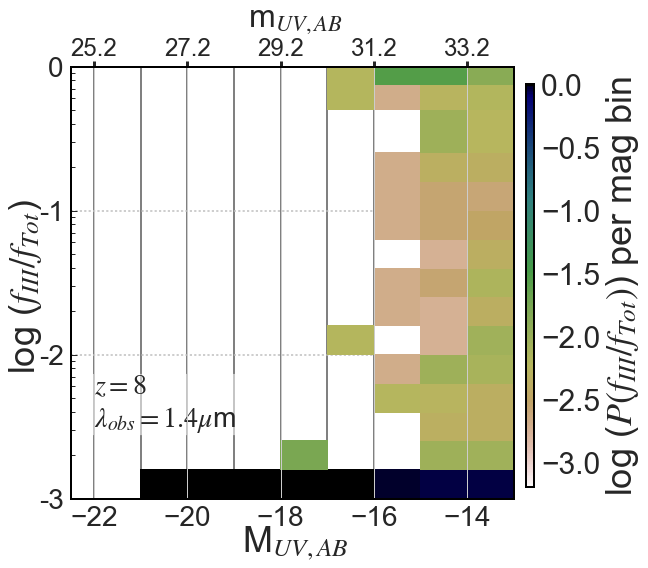

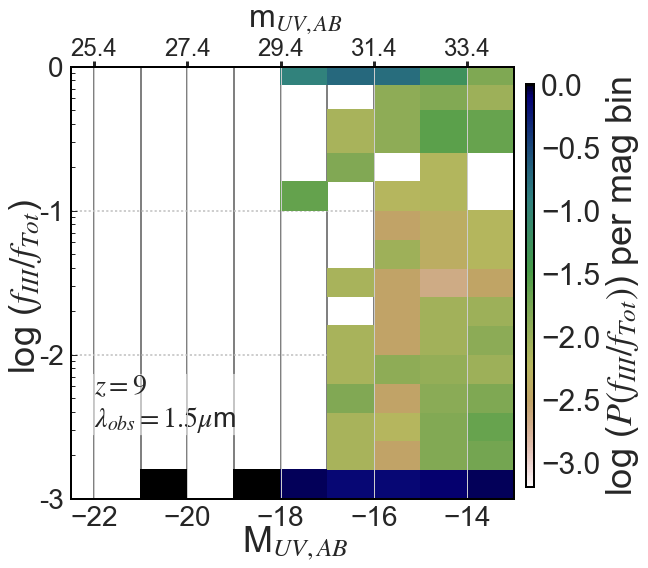

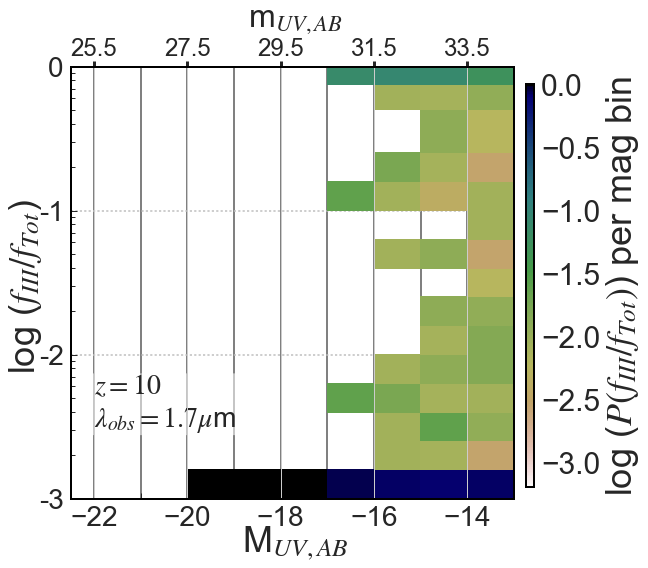

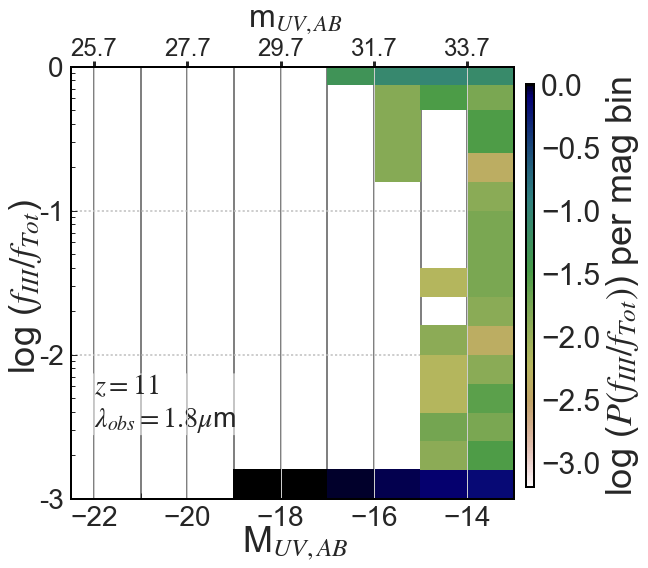

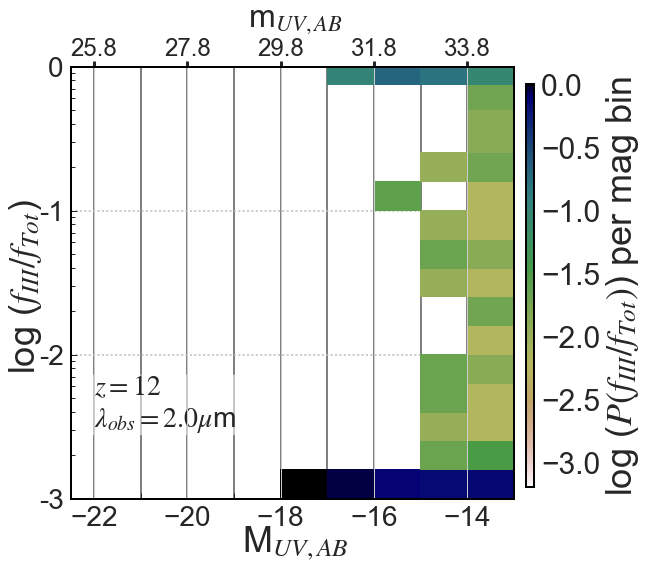

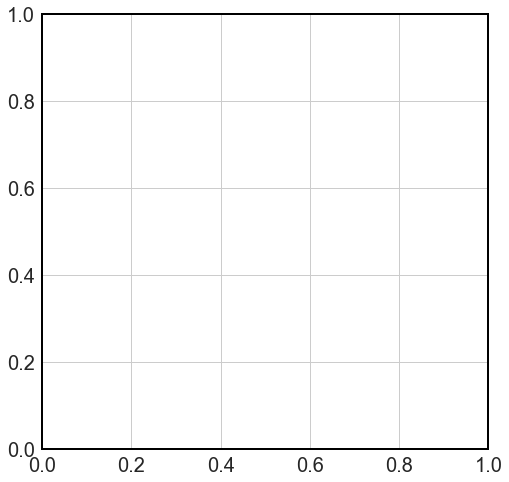

In [37]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
# fracBins = np.linspace(1e-3,9e-3,9).tolist() +np.linspace(1e-2,9e-2,9).tolist() +np.linspace(1e-1,1e-0,9).tolist()
print("Limiting absolute magnitude: {}".format(limitM))

p3ff ={}
p3ffMix = {}
doNMnow = False
for z in [8,9,10,11,12,13,14,15,16]:

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex='col',sharey='row',figsize=(8,8))
    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    p3ffMix[z] = p3ff[z] # Make a copy so we can print both mixing and no-mix

    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing

    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-3.2, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=28)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-3,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(which='major',width=3,length=6,direction='out',pad=0)
    ax2.get_xaxis().set_tick_params(labelsize=24)
    
    ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$m'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.052, 0.15), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.55},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=28)


    # plt.gca().invert_xaxis()
    gc.collect()
    
    plt.subplots_adjust(left=0.11, bottom=0.13, right=.88, top=0.88, wspace=.057, hspace=.125)

    fig.text(0.5, 0.95,'m$_{UV,AB}$', ha='center',size=32 )
    fig.text(0.5, 0.04,'M$_{UV,AB}$', ha='center',size=36 )
    fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=36,va='center', rotation='vertical')

    # Create the colorbar
    cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)

    cbar.ax.tick_params(labelsize=30) 
    #cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
    cbar.set_label("log ($P(f_{III}/f_{Tot})$) per mag bin",fontsize=36)
    plt.savefig("PopIII_fraction-Histograms-{:.1f}.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
    del fig, ax

gc.collect()

In [38]:
pd.set_option('precision', 3)
pd.set_option('display.latex.escape',False)
p3fracTab

NameError: name 'p3fracTab' is not defined

In [39]:
print(p3fracTab.to_latex(index=False))

NameError: name 'p3fracTab' is not defined

In [40]:
np.set_printoptions(precision=3)
print(10**H)

[[-- -- -- -- 1.0 0.9 0.775 0.7157894736842105 0.7468354430379747]
 [-- -- -- -- -- -- -- 0.021052631578947368 0.03164556962025316]
 [-- -- -- -- -- -- -- 0.010526315789473682 0.006329113924050633]
 [-- -- -- -- -- -- -- 0.021052631578947368 0.006329113924050633]
 [-- -- -- -- -- -- -- 0.021052631578947368 0.012658227848101267]
 [-- -- -- -- -- -- -- -- 0.006329113924050633]
 [-- -- -- -- -- -- -- -- 0.018987341772151896]
 [-- -- -- -- -- -- -- 0.010526315789473682 0.006329113924050633]
 [-- -- -- -- -- -- -- 0.021052631578947368 0.012658227848101267]
 [-- -- -- -- -- -- -- 0.010526315789473682 0.006329113924050633]
 [-- -- -- -- -- -- 0.025000000000000005 -- 0.006329113924050633]
 [-- -- -- -- -- -- -- 0.010526315789473682 0.018987341772151896]
 [-- -- -- -- -- -- -- -- 0.012658227848101267]
 [-- -- -- -- -- -- -- -- 0.018987341772151896]
 [-- -- -- -- -- 0.1 0.20000000000000004 0.15789473684210523
  0.08860759493670885]]


In [41]:
len(pop3Fraction[pop3Fraction> 0.75])/len(pop3Fraction)

0.11529933481152993

Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.01515 at z=8
Working on z=8
Number of galaxies 4563
Largest bin value: 0.000, smallest -2.741151598851785


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:75: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.11445 at z=9
Working on z=9
Number of galaxies 1468
Largest bin value: 0.000, smallest -2.6720978579357175
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Working on z=10
Number of galaxies 1021
Largest bin value: 0.000, smallest -2.54282542695918
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.07623 at z=11
Working on z=11
Number of galaxies 687
Largest bin value: 0.000, smallest -2.367355921026019
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.14715 at z=12
Working on z=12
Number of galaxies 451
Largest bin value: 0.000, smallest -2.1986570869544226
Convert to Abs Mag. DM = 47.92 @ z=13.0


KeyError: 13

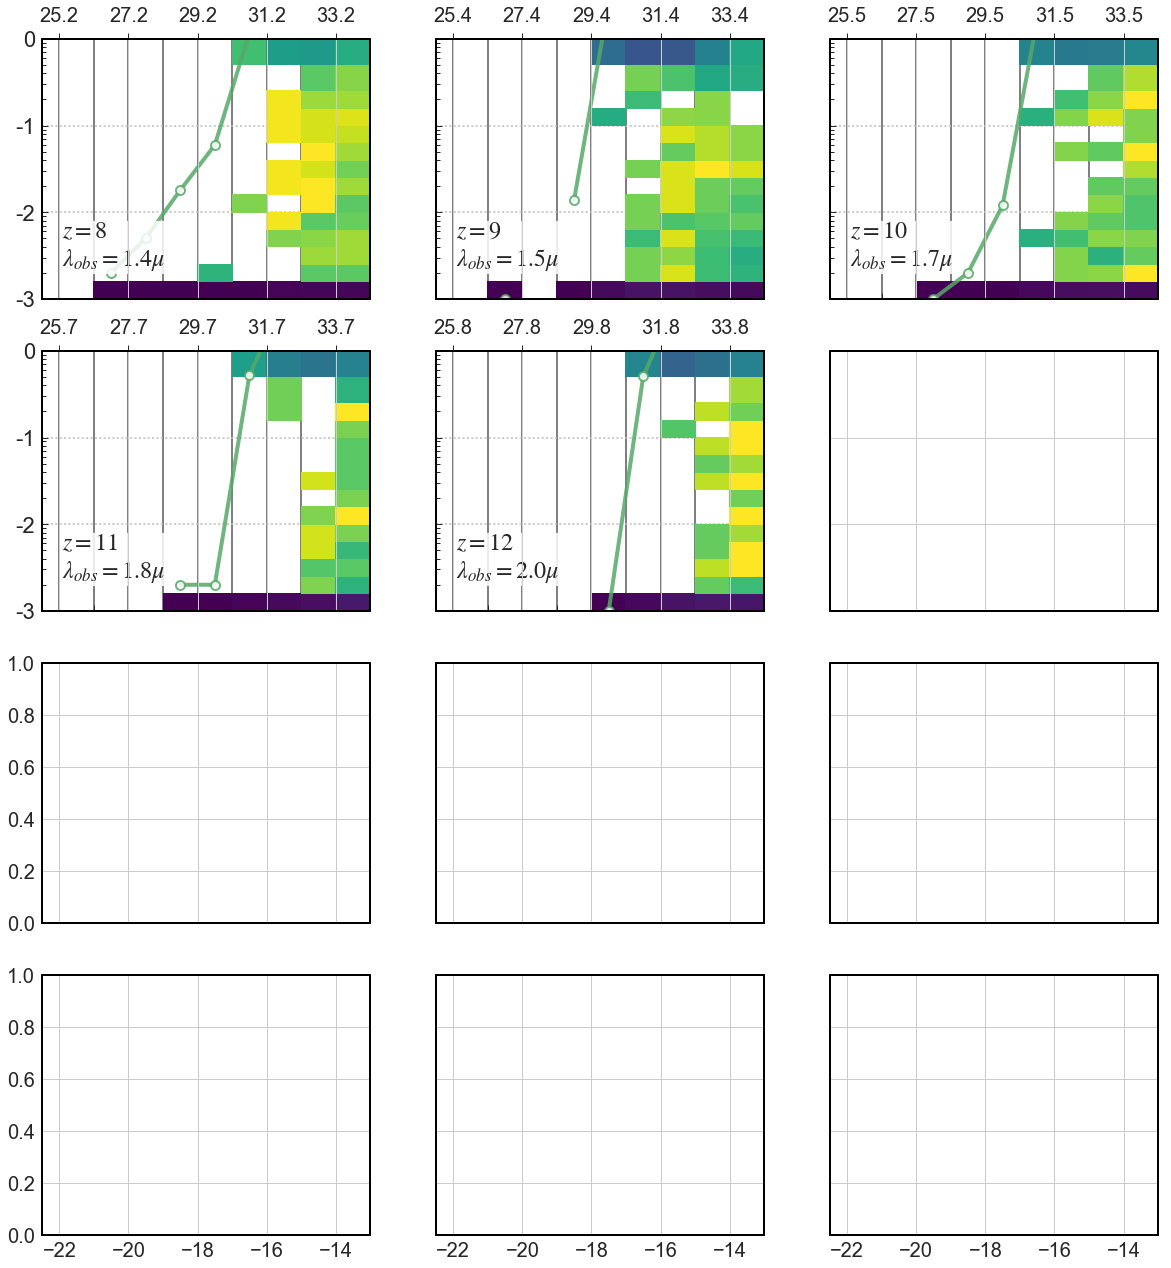

In [42]:
# Normalize the probability in each row such that it totals to 1.0
# Also normalize by bin area FIRST *******************************
# TOP BIN in 50% Pop III flux...

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

brightM = -22
limitM  = brightM+9
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   1.0]
binCentersA = magBins[:-1] + np.diff(magBins)/2.0
print("Limiting absolute magnitude: {}".format(limitM))
aveZ ={}
p3ff ={}
doNMnow = False
fig, axs = plt.subplots(nrows=4, ncols=3, sharex='col',sharey='row',figsize=(20,22))
for z,ax in zip([8,9,10,11,12,13,14,15,16,8,9,10], axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    p3ff[z] = haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum()
    print("Pop III flux fraction is {:.5f} at z={}".format(p3ff[z],z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        
    print("Working on z={}".format(z))
    # If we are back to z = 8,9,10 then generate plots for NO Mixing
    if doNMnow:
        print("************************************************************")
        print("Working on the NON MIXING flux fractions for or galaxies ...")
        print("************************************************************")
        pop3Fraction = haloData[dir][z]['1500A_P3NM']/haloData[dir][z]['1500A_NM']
        p3ff[z] = haloData[dir][z]['1500A_P3NM'].sum()/haloData[dir][z]['1500A_NM'].sum()
#         print("Pop III flux fraction is {:.5f} at z={}".format(p3ffNM[z],z))
        pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
        absMag = nmAbsMag ## Do plots for NO MIXING version of data... 
    
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    dx = np.diff(magBins)
    dy = np.diff(fracBins) 
    area = dx[:,None] * dy # compute the area of each bin using broadcasting
    aveZatz = np.ma.MaskedArray([np.sum(H[:,i]*fracBins[:-1]) ## bin center
                                 for i in range(len(H[0,:]))],fill_value=0)
    aveZ[z] = aveZatz # Save average Z per mass bin in a dict.
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.viridis_r ))#, vmin=-3, vmax=0) )
    
    ax.plot(binCentersA,aveZ[z],markeredgewidth=2.0,
            ls='-',marker='o', c='C7', alpha=0.85, markerfacecolor="w",
            markersize=9, lw=4.0, mec='C7', label="mean")

    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
    ax.set_ylim([1e-3,1.0])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.xaxis.set_tick_params(direction='out')
    ax2.xaxis.set_tick_params(which='major',width=1,length=6,direction='out')
    ax2.get_xaxis().set_tick_params(labelsize=20)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    if doNMnow:
        ax.annotate('$z={}$\nClassic Pop III'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.06, 0.1), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.85},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=24)
    else:
        ax.annotate('$z={}$\n$\lambda_{{obs}}={:.1f} \mu$'.format(z,0.15*(1+z)+0.0001), xy = (0.5, 0.5), 
                xytext = (0.06, 0.1), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.85},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=24)

    
    ####
    #### If we just finished z=16, do z=8,9,10 for 
    #### no mixing case
    ####
    if z == 16:
        print("FINISHED with z=8-16")
        doNMnow = True

plt.subplots_adjust(left=0.05, bottom=0.08, right=.88, top=0.92, wspace=.057, hspace=.125)

fig.text(0.5, 0.95,'$m_{UV,AB}$', ha='center',size=30 )
fig.text(0.5, 0.04,'$M_{UV,AB}$', ha='center',size=30 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=30,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=24) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log $P(f_{III}/f_{Tot})$ @ $M_{AB}$",fontsize=30)
plt.savefig("PopIII_fraction-Histograms-all-50TopBin.pdf",dpi=fig.dpi,bbox_inches='tight')

gc.collect()

## Print out a table of P3 fractions in the 75 and 50% bins... 

** Remember to add the contributions of bins when discussing, say, f_III fraction > 50% includes
the prob from the 75% bin... **

In [43]:
brightM = -22
limitM  = brightM+9

In [44]:
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
print(magBins)

[-22. -21. -20. -19. -18. -17. -16. -15. -14. -13.]


### Build tables showing f_III/f_tot = f(z,M_AB)

In [45]:
np.set_printoptions(linewidth=105)

In [46]:
# Normalize the probability in each row such that it totals to 1.0

brightM = -20
limitM  = -14
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0] # Force bins at 50% and 75% flux
print(["{}".format(i) for i in magBins])

headers = np.concatenate(([['z'],magBins[1:]]))
df75 = pd.DataFrame( columns=headers)
df50 = pd.DataFrame( columns=headers)

mat75 = np.array([])
mat50 = np.array([])
errors75 = []
ii = 0;
for z in np.sort([8,9,10,11,12,13,14,15,16]):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction                      = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    obsmag = mag(haloData[dir][z]['1500A']) # Compute the observational UV mag: m_AB
    
    Ng = len(absMag) # Number of galaxies at this z
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    n, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(n==0.0, n)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot # H is not a fraction (probability)

    # Compute error bound
    # REMEMBER, n is upside-down! Last row is > 75%
    errors75.append(np.array([np.sqrt(n[-1,i])/np.sum(n[:,i]) for i in range(len(n[0,:]))]))
    #     print("errors: ",errors75)
    #     print([np.sum(n[:,i]) for i in range(len(n[0,:]))])
    # Create arrays where fraction is greater than 50% and 75% ... 
    # REMEMBER: have to add the 73% bin to the 50% if we want combined P(>.50)
    H = np.ma.filled(H, fill_value=0.0)

    #########################################################################
    ##### Extract the "top two" rows ... these are bins 53% and 73% #########
    ##### if you change fracBins this changes!!!! ***************************
    ##### Also, the rows are actually at the BOTTOM of the matrix.. not the top
    #########################################################################
    gt50 = H[-2,:]
    gt75 = H[-1,:]
#     print("z={}, H (> 53 and 73% respectively): \n{}\n{}".format(z,["{:.4f}".format(x) for x in gt50+gt75],
#                                                                             ["{:.4f}".format(x) for x in gt75]))
    df75.loc[ii] = np.concatenate(([z],gt75))
    df50.loc[ii] = np.concatenate(([z],gt50+gt75)) ## Sum the fraction > .73 and .53 < frac < .73
    if z == 8: # first one
        print(gt75)
        # Build a new matrix with P3 frac vs M_AB 
        mat75 = np.append(mat75,gt75)
        mat50 = np.append(mat50,gt50+gt75)
    else:
        mat75 = np.vstack((mat75,gt75)) # A matrix (for plotting) of the table
        mat50 = np.vstack((mat50,gt50+gt75)) # a matrix of the table... 
    ii += 1
gc.collect()
# df75.index = range(8,16)
# df50.index = range(8,16)
print("> 75 and 50% respectively")
print (df75.to_string(index=False))
print (df50.to_string(index=False))
errors75=np.array(np.nan_to_num(errors75))

['-20.0', '-19.0', '-18.0', '-17.0', '-16.0', '-15.0', '-14.0']
Convert to Abs Mag. DM = 47.20 @ z=8.0
[ 0.     0.     0.     0.006  0.028  0.028]
Convert to Abs Mag. DM = 47.38 @ z=9.0
Convert to Abs Mag. DM = 47.54 @ z=10.0
Convert to Abs Mag. DM = 47.68 @ z=11.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Convert to Abs Mag. DM = 47.92 @ z=13.0


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:48: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


KeyError: 13

In [47]:
# Normalize the probability in each row such that it totals to 1.0

#
# NO MIXING data 
#

brightM = -20
limitM  = -14
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0] # Force bins at 50% and 75% flux
print(["{}".format(i) for i in magBins])

headers = np.concatenate(([['z'],magBins[1:]]))
df75 = pd.DataFrame( columns=headers)
df50 = pd.DataFrame( columns=headers)

mat75 = np.array([])
mat50 = np.array([])
errors75 = []
ii = 0;
for z in np.sort([8,9,10,11,12,13,14,15,16]):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction                      = haloData[dir][z]['1500A_P3NM']/haloData[dir][z]['1500A_NM']
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    obsmag = mag(haloData[dir][z]['1500A_NM']) # Compute the observational UV mag: m_AB
    
    Ng = len(absMag) # Number of galaxies at this z
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    n, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(n==0.0, n)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot # H is not a fraction (probability)

    # Compute error bound
    # REMEMBER, n is upside-down! Last row is > 75%
    errors75.append(np.array([np.sqrt(n[-1,i])/np.sum(n[:,i]) for i in range(len(n[0,:]))]))
    #     print("errors: ",errors75)
    #     print([np.sum(n[:,i]) for i in range(len(n[0,:]))])
    # Create arrays where fraction is greater than 50% and 75% ... 
    # REMEMBER: have to add the 73% bin to the 50% if we want combined P(>.50)
    H = np.ma.filled(H, fill_value=0.0)

    #########################################################################
    ##### Extract the "top two" rows ... these are bins 53% and 73% #########
    ##### if you change fracBins this changes!!!! ***************************
    ##### Also, the rows are actually at the BOTTOM of the matrix.. not the top
    #########################################################################
    gt50 = H[-2,:]
    gt75 = H[-1,:]
#     print("z={}, H (> 53 and 73% respectively): \n{}\n{}".format(z,["{:.4f}".format(x) for x in gt50+gt75],
#                                                                             ["{:.4f}".format(x) for x in gt75]))
    df75.loc[ii] = np.concatenate(([z],gt75))
    df50.loc[ii] = np.concatenate(([z],gt50+gt75)) ## Sum the fraction > .73 and .53 < frac < .73
    if z == 8: # first one
        print(gt75)
        # Build a new matrix with P3 frac vs M_AB 
        mat75 = np.append(mat75,gt75)
        mat50 = np.append(mat50,gt50+gt75)
    else:
        mat75 = np.vstack((mat75,gt75)) # A matrix (for plotting) of the table
        mat50 = np.vstack((mat50,gt50+gt75)) # a matrix of the table... 
    ii += 1
gc.collect()
# df75.index = range(8,16)
# df50.index = range(8,16)
print("> 75 and 50% respectively -- NO MIXING CASE")
print (df75.to_string(index=False))
print (df50.to_string(index=False))
errors75=np.array(np.nan_to_num(errors75))

['-20.0', '-19.0', '-18.0', '-17.0', '-16.0', '-15.0', '-14.0']
Convert to Abs Mag. DM = 47.20 @ z=8.0
[ 0.     0.     0.     0.     0.01   0.008]
Convert to Abs Mag. DM = 47.38 @ z=9.0
Convert to Abs Mag. DM = 47.54 @ z=10.0
Convert to Abs Mag. DM = 47.68 @ z=11.0
Convert to Abs Mag. DM = 47.80 @ z=12.0
Convert to Abs Mag. DM = 47.92 @ z=13.0


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


KeyError: 13

In [48]:
# Prit out the errors for each entry
errors75, df75.values[:,1:]

([array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.005,  0.003]),
  array([   nan,  0.   ,  0.039,  0.024,  0.014,  0.005]),
  array([ 0.   ,  0.   ,  0.   ,  0.034,  0.019,  0.013]),
  array([   nan,  0.   ,  0.   ,  0.048,  0.028,  0.009]),
  array([   nan,    nan,  0.   ,  0.1  ,  0.043,  0.026])],
 array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.01 ,  0.008],
        [ 0.   ,  0.   ,  0.068,  0.076,  0.064,  0.011],
        [ 0.   ,  0.   ,  0.   ,  0.049,  0.042,  0.044],
        [ 0.   ,  0.   ,  0.   ,  0.048,  0.056,  0.012],
        [ 0.   ,  0.   ,  0.   ,  0.1  ,  0.075,  0.063]]))

In [49]:
errors75[8],df75.values[8,1:]

IndexError: list index out of range

In [50]:
np.where(errors75[8]> 1.0 - df75.values[8,1:])[0] # Where is the error such that it puts us over 1.0

IndexError: list index out of range

In [51]:
upErr = np.copy(errors75)
dnErr = np.copy(errors75)
for i in range(9):
    fixUp = np.where(errors75[i]> 1.0 - df75.values[i,1:])[0] # Where is the error such that it puts us over 1.0 
    if len(fixUp):
        upErr[i][fixUp] = (1.0 - df75.values[i,1:])[fixUp] # Skip that index column, start at 1...
    fixDn = np.where(df75.values[i,1:] - errors75[i] < 0.0)[0] # Where is the error such that it puts us over 1.0 
    if len(fixDn):
        dnErr[i][fixDn] = (df75.values[i,1:])[fixDn] 
    

IndexError: list index out of range

In [52]:
np.set_printoptions(precision=3)
print(upErr,"\n",dnErr)

[[ 0.     0.     0.     0.     0.005  0.003]
 [   nan  0.     0.039  0.024  0.014  0.005]
 [ 0.     0.     0.     0.034  0.019  0.013]
 [   nan  0.     0.     0.048  0.028  0.009]
 [   nan    nan  0.     0.1    0.043  0.026]] 
 [[ 0.     0.     0.     0.     0.005  0.003]
 [   nan  0.     0.039  0.024  0.014  0.005]
 [ 0.     0.     0.     0.034  0.019  0.013]
 [   nan  0.     0.     0.048  0.028  0.009]
 [   nan    nan  0.     0.1    0.043  0.026]]


In [53]:
errors75

[array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.005,  0.003]),
 array([   nan,  0.   ,  0.039,  0.024,  0.014,  0.005]),
 array([ 0.   ,  0.   ,  0.   ,  0.034,  0.019,  0.013]),
 array([   nan,  0.   ,  0.   ,  0.048,  0.028,  0.009]),
 array([   nan,    nan,  0.   ,  0.1  ,  0.043,  0.026])]

In [54]:
pd.set_option('precision', 3)
# print(df75.ix[:,[-20":"-14"]].to_latex(index=False)) # Just just the cols we need
print(df75.to_latex(index=False)) # Just just the cols we need

\begin{tabular}{rrrrrrr}
\toprule
    z &  -19.0 &  -18.0 &  -17.0 &  -16.0 &  -15.0 &  -14.0 \\
\midrule
  8.0 &    0.0 &    0.0 &  0.000 &  0.000 &  0.010 &  0.008 \\
  9.0 &    0.0 &    0.0 &  0.068 &  0.076 &  0.064 &  0.011 \\
 10.0 &    0.0 &    0.0 &  0.000 &  0.049 &  0.042 &  0.044 \\
 11.0 &    0.0 &    0.0 &  0.000 &  0.048 &  0.056 &  0.012 \\
 12.0 &    0.0 &    0.0 &  0.000 &  0.100 &  0.075 &  0.063 \\
\bottomrule
\end{tabular}



In [55]:
cm = sns.light_palette("green", as_cmap=True)

s = df75.style.background_gradient(cmap=cm)
s

In [56]:
df75

z  -19.0  -18.0  -17.0  -16.0  -15.0  -14.0
0   8.0    0.0    0.0  0.000  0.000  0.010  0.008
1   9.0    0.0    0.0  0.068  0.076  0.064  0.011
2  10.0    0.0    0.0  0.000  0.049  0.042  0.044
3  11.0    0.0    0.0  0.000  0.048  0.056  0.012
4  12.0    0.0    0.0  0.000  0.100  0.075  0.063

In [57]:
df50

z  -19.0  -18.0  -17.0  -16.0  -15.0  -14.0
0   8.0    0.0    0.0  0.000  0.000  0.010  0.008
1   9.0    0.0    0.0  0.091  0.076  0.070  0.011
2  10.0    0.0    0.0  0.000  0.049  0.042  0.044
3  11.0    0.0    0.0  0.000  0.048  0.056  0.019
4  12.0    0.0    0.0  0.000  0.100  0.075  0.063

In [58]:
np.set_printoptions(linewidth=120)
np.set_printoptions(precision=4)

In [59]:
print((mat50-mat75).max())
mat50-mat75

0.0227272727273


array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.0227,  0.    ,  0.0061,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.0062],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ]])

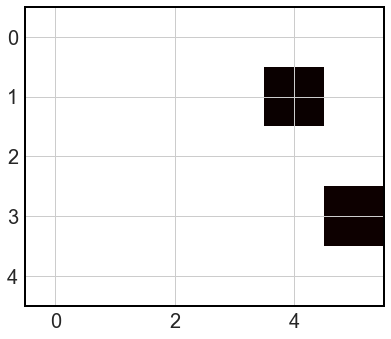

In [60]:
plt.imshow(np.ma.masked_where(mat50-mat75==0,mat50-mat75),cmap=mpl.cm.hot)

min val = 0.008166969147005444


TypeError: Dimensions of C (5, 4) are incompatible with X (4) and/or Y (10); see help(pcolormesh)

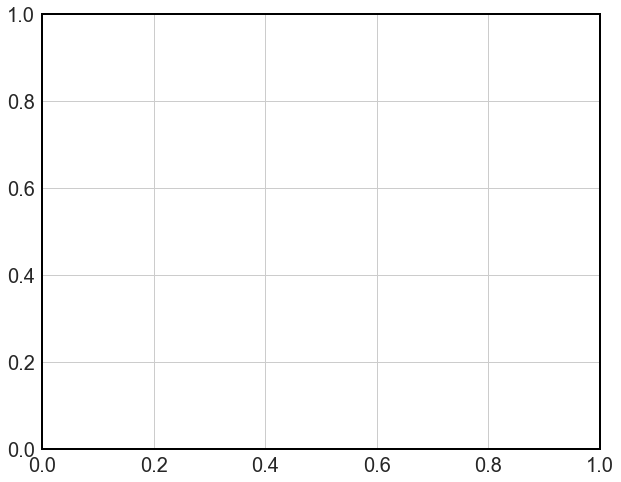

In [61]:
fig      = plt.figure(figsize=(10, 8))
ax       = plt.axes()

mat75m = np.ma.masked_where(mat75==0, mat75)

X, Y = np.meshgrid(magBins[:-1], range(7,17))  # Create a grid over the range of bins for the plot
X, Y = np.meshgrid(magBins[2:-1], range(7,17))  # Create a grid over the range of bins for the plot

print("min val = {}".format(mat75m.min()))

# im = (ax.pcolormesh(X, Y, m75m, cmap=mpl.cm.YlGnBu, vmin=-2.4, vmax=0) )
im = (ax.pcolormesh(X, Y, mat75m[:,2:], cmap=mpl.cm.YlGnBu, vmin=1e-2, vmax=1) )

ax.set_xlabel('$M_{UV,AB}$',fontsize=24)
# ax.set_xticks(magBins)
ax.set_ylabel('redshift',fontsize=24)
ax.set_yticklabels(zs+1)
ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
ax.grid(which='both', axis='x', color='0.75', linestyle=':', linewidth=1.5)

# Create the colorbar
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("P(>0.75)",fontsize=24)

plt.savefig("ProbvsRedshift.pdf",dpi=fig.dpi,bbox_inches='tight')


min val = 0.008166969147005444


TypeError: Dimensions of C (5, 4) are incompatible with X (4) and/or Y (10); see help(pcolormesh)

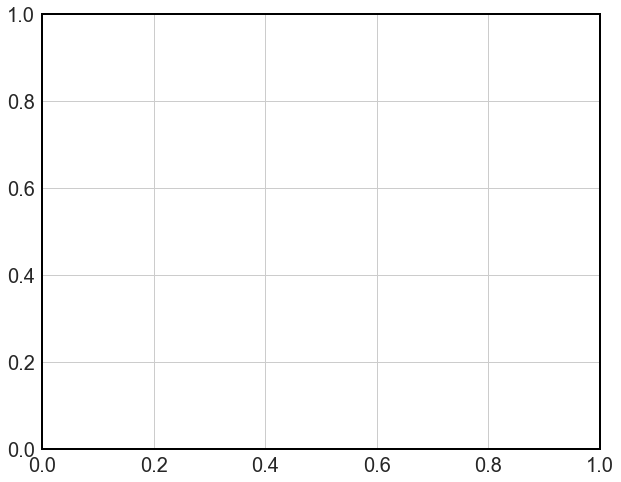

In [62]:
zs = np.arange(7,17)
fig      = plt.figure(figsize=(10, 8))
ax       = plt.axes()

mat50m = np.ma.masked_where(mat50==0, mat50)

m50m = np.log10(mat50m)
print("min val = {}".format(mat50m.min()))

X, Y = np.meshgrid(magBins[2:-1], range(7,17))  # Create a grid over the range of bins for the plot

# im = (ax.pcolormesh(X, Y, m50m, cmap=mpl.cm.YlGnBu, vmin=-2.3, vmax=0) )
im = (ax.pcolormesh(X, Y, mat50m[:,2:], cmap=mpl.cm.YlGnBu, vmin=1e-2, vmax=1) )

ax.set_xlabel('$M_{UV,AB}$',fontsize=24)
ax.set_ylabel('redshift',fontsize=24)
ax.set_yticklabels(zs+1)
ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
ax.grid(which='both', axis='x', color='0.75', linestyle=':', linewidth=1.5)

# Create the colorbar
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("P(>0.50)",fontsize=24)



In [ ]:
fig      = plt.figure(figsize=(10, 8))
ax       = plt.axes()

mat75m = np.ma.masked_where(mat75==0, mat75)

X, Y = np.meshgrid(magBins[:-1], range(7,17))  # Create a grid over the range of bins for the plot
X, Y = np.meshgrid(magBins[2:-1], range(7,17))  # Create a grid over the range of bins for the plot

m75m = np.log10(mat75m)
print("min val = {}".format(mat75m.min()))

# im = (ax.pcolormesh(X, Y, m75m, cmap=mpl.cm.YlGnBu, vmin=-2.4, vmax=0) )
im = (ax.pcolormesh(X, Y, mat75m[:,2:], cmap=mpl.cm.YlGnBu, vmin=1e-2, vmax=1) )

ax.set_xlabel('$M_{UV,AB}$',fontsize=24)
# ax.set_xticks(magBins)
ax.set_ylabel('redshift',fontsize=24)
ax.set_yticklabels(zs+1)
ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
ax.grid(which='both', axis='x', color='0.75', linestyle=':', linewidth=1.5)

# Create the colorbar
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("P(>0.75)",fontsize=24)

plt.savefig("ProbvsRedshift.pdf",dpi=fig.dpi,bbox_inches='tight')


z=8

\> 53%

['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0017', '0.0122', '0.0137', '0.0116', '0.0166']

\> 73%

['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0514', '0.1443', '0.1291', '0.0486', '0.0315', '0.0190']


Limiting absolute magnitude: -13
Convert to Abs Mag. DM = 47.20 @ z=8.0
Pop III flux fraction is 0.01515 at z=8
Number of galaxies 4563
Largest bin value: 0.000, smallest -2.741151598851785


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:52: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


Convert to Abs Mag. DM = 47.38 @ z=9.0
Pop III flux fraction is 0.11445 at z=9
Number of galaxies 1468
Largest bin value: 0.000, smallest -2.6720978579357175
Convert to Abs Mag. DM = 47.54 @ z=10.0
Pop III flux fraction is 0.05494 at z=10
Number of galaxies 1021
Largest bin value: 0.000, smallest -2.54282542695918
Convert to Abs Mag. DM = 47.68 @ z=11.0
Pop III flux fraction is 0.07623 at z=11
Number of galaxies 687
Largest bin value: 0.000, smallest -2.367355921026019
Convert to Abs Mag. DM = 47.80 @ z=12.0
Pop III flux fraction is 0.14715 at z=12
Number of galaxies 451
Largest bin value: 0.000, smallest -2.1986570869544226
Convert to Abs Mag. DM = 48.03 @ z=14.0
Pop III flux fraction is 0.26543 at z=14
Number of galaxies 174
Largest bin value: -0.176, smallest -1.662757831681574
Convert to Abs Mag. DM = 48.12 @ z=15.0
Pop III flux fraction is 0.31926 at z=15
Number of galaxies 94
Largest bin value: 0.000, smallest -1.4471580313422192
Convert to Abs Mag. DM = 48.21 @ z=16.0
Pop III fl

16089

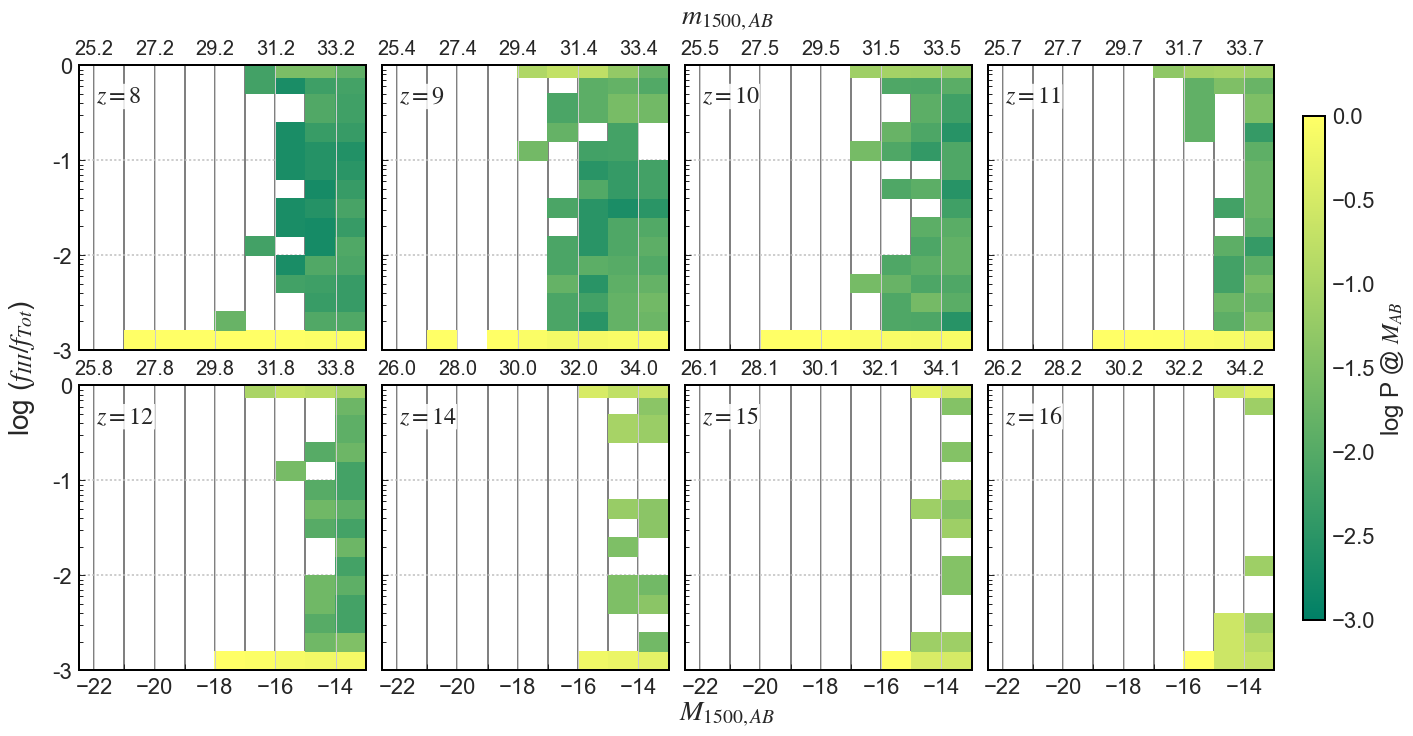

In [63]:
# Normalize the probability in each row such that it totals to 1.0

sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

# Plot the fraction of Pop III magnitude vs M_AB NORMALIZED...

rgForSFunc = np.arange(brightM,limitM, 0.1)

brightM = -22
limitM  = brightM+9
magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
print("Limiting absolute magnitude: {}".format(limitM))

fig, axs = plt.subplots(nrows=2, ncols=4, sharex='col',sharey='row',figsize=(20,10))
for z,ax in zip(np.sort([8,9,10,11,12,14,15,16]), axs.flat):

    # Convert observed magnitude to Absolute ...
    absMag, pop3Mag, nmAbsMag   = compMags(z)
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction                      = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    print("Pop III flux fraction is {:.5f} at z={}".format(haloData[dir][z]['1500A_P3'].sum()/haloData[dir][z]['1500A'].sum(),z))
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    

    
    Ng = len(absMag) # Number of galaxies at this z
    print("Number of galaxies {}".format(Ng))
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,absMag,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in absMag] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.

    X, Y = np.meshgrid(magBins, fracBins)  # Create a grid over the range of bins for the plot

    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot
    H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
    print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
    # Create the plot
    im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.summer, vmin=-3, vmax=0) )
    
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(which='major',width=1,length=6)
    ax.yaxis.set_tick_params(which='minor',width=1,length=4)
    ax.xaxis.set_tick_params(which='both',width=1,length=6)
    ax.xaxis.set_ticks(np.arange(brightM,limitM+1, 2))
    minorLocator = ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.get_yaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.get_xaxis().set_tick_params(which='both', direction='in',labelsize=22)
    ax.yaxis.set_major_formatter(logfmt)
    ax.set_xlim([brightM-0.5,limitM])
#     ax.set_ylim([9e-4,1.05])
    ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
    ax.grid(which='both', axis='x', color='0.5', linestyle='-', linewidth=2.0)

    # Top x-axis labels ... m_ab
    ax2 = ax.twiny()
    ax2.set_xlim([brightM-0.5,limitM]) # required...
    axXtics = ax.get_xticks()
    ax2.set_xticks(axXtics)   # Set the location of the tics same as for ax
    ax2Xs = getMag(axXtics,z) # Convert M_ab -> m_ab
    ax2.set_xticklabels(["{:.1f}".format(i) for i in ax2Xs])
    ax2.get_xaxis().set_tick_params(labelsize=20)

    # plt.gca().invert_xaxis()
    gc.collect()
    
    ax.annotate('$z={}$'.format(z), xy = (0.5, 0.5), xytext = (0.06, 0.85), xycoords='axes fraction',
                bbox = {'boxstyle': 'round,pad=0.05', 'fc': 'w', 'ec': 'None', 'alpha': 0.85},
                textcoords = 'axes fraction', ha = 'left', va = 'bottom',fontsize=24)

plt.subplots_adjust(left=0.05, bottom=0.08, right=.88, top=0.92, wspace=.057, hspace=.125)

fig.text(0.5, 0.977,'$m_{1500,AB}$', ha='center',size=28 )
fig.text(0.5, 0.01,'$M_{1500,AB}$', ha='center',size=28 )
fig.text(0.00, 0.5, r'log ($f_{III}/f_{Tot}$)',size=28,va='center', rotation='vertical')

# Create the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("log P @ $M_{AB}$",fontsize=24)
#plt.savefig("PopIII_fraction_{}-Histograms-all.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')

gc.collect()

### Build tables showing f_III/f_tot = f(z,M_AB)

In [64]:
# Normalize the probability in each row such that it totals to 1.0

brightM = 25
limitM  = 37
rgForSFunc = np.arange(brightM,limitM, 0.1)

magBins = np.linspace(brightM,limitM,(-brightM+limitM)*1 + 1) 
fracBins = np.logspace(-3,0,23)
# Contrived bin spacing such that the top bin represents .75-1.0 Pop III fraction
# and the next bin down represents .5-0.75 ...
fracBins = [0.001,  0.00158489,  0.00251189,  0.00398107,  0.00630957,
             0.01,  0.01584893,  0.02511886,  0.03981072,  0.06309573,
             0.1,  0.15848932,  0.25118864,
             0.5,   0.75,   1.0]
print(["{}".format(i) for i in magBins])

headers = np.concatenate(([['z'],magBins[1:]]))
dfom75 = pd.DataFrame( columns=headers)
dfom50 = pd.DataFrame( columns=headers)

matom75 = np.array([])
matom50 = np.array([])
ii = 0;
for z in np.sort([8,9,10,11,12,13,14,15,16]):

    # Convert flux to m ...
    mags = mag(haloData[dir][z]['1500A'])
    # Map 0 Pop 3 flux to 1e-3... 
    pop3Fraction                      = haloData[dir][z]['1500A_P3']/haloData[dir][z]['1500A']
    pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
    
    Ng = len(mags) # Number of galaxies at this z
    # GENERATE THE HISTOGRAM and HISTOGRAM DATA in the array 'n' for
    # both the improved Pop III luminosity and the classical

    # Note that we are reversing x,y here since pcolormesh interprets them backwards!
    nTempA, binsx, binsy = np.histogram2d(pop3Fraction,mags,bins=[fracBins,magBins],normed=False)
    # could use weights=[1/simVol for i in mags] to normalize by vol here... 
    # normed : bool, optional
    #        If False, returns the number of samples in each bin. If True, returns the bin density 
    #        bin_count / sample_count / bin_area.


    # Mask out 0 values before taking log10... 
    H = np.ma.masked_where(nTempA==0.0, nTempA)
#     H = np.ma.masked_where(nTempA<=1.0, nTempA)
    if z==15:
        print("counts",H[-1,:])
        print("counts\n",H)
    for i in range(len(H[0,:])):     # Column index i, over len of row 0
        colTot = np.sum(H[:,i])
        for j in range(len(H[:,0])): # Row index j, over len of column 0
            H[:,i][j] = H[:,i][j]/colTot  ## IF colTot == 1 or 2, we likely have very bad statistics **************
    # Create arrays where fraction is greater than 50% and 75% ... 
    # REMEMBER: have to add the 75% bin to the 50% if we want combined P(>.50)
#     H = np.ma.filled(H, fill_value=0.0)
    if z==15:
        print("prob",H[-1,:])
    #########################################################################
    ##### Extract the "top two" rows ... these are bins 50% and 75% #########
    ##### if you change fracBins this changes!!!! ***************************
    #########################################################################
    gtom50 = H[-2,:]
    gtom75 = H[-1,:]
#     print("z={}, H (> 75%): \n{}".format(z,["{:.4f}".format(x) for x in gtom75]))
    dfom75.loc[ii] = np.concatenate(([z],gtom75))
    dfom50.loc[ii] = np.concatenate(([z],gtom50+gtom75)) ## Sum the fraction > .75 and .50 < frac < .75
    if z == 8: # first one
#         print(gtom75)
        # Build a new matrix with P3 frac vs M_AB 
        matom75 = np.append(matom75,gtom75)
        matom50 = np.append(matom50,gtom50+gtom75)
    else:
        matom75 = np.vstack((matom75,gtom75)) # A matrix (for plotting) of the table
        matom50 = np.vstack((matom50,gtom50+gtom75)) # a matrix of the table... 
    ii += 1
gc.collect()
# df75.index = range(8,16)
# df50.index = range(8,16)
print("> 75 and 50% respectively")
print (dfom75.to_string(index=False))
print (dfom50.to_string(index=False))


['25.0', '26.0', '27.0', '28.0', '29.0', '30.0', '31.0', '32.0', '33.0', '34.0', '35.0', '36.0', '37.0']


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:53: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


KeyError: 13

In [65]:
H[-2,:],H[-1,:],magBins

(masked_array(data = [-- -- -- -- -- -- -- -- 0.009174311926605505 0.024844720496894408 0.015151515151515152 --],
              mask = [ True  True  True  True  True  True  True  True False False False  True],
        fill_value = 1e+20),
 masked_array(data = [-- -- -- -- -- -- 0.18181818181818182 0.1836734693877551 0.13761467889908258 0.09316770186335403 0.030303030303030304
  0.03571428571428571],
              mask = [ True  True  True  True  True  True False False False False False False],
        fill_value = 1e+20),
 array([ 25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.]))

In [66]:
z15mags=mag(fluxes[15]['1500A']) ### Check out that 100% at z=15, m=31
pop3Fraction                      = fluxes[15]['1500A_P3']/fluxes[15]['1500A']
pop3Fraction[pop3Fraction < 1e-3] = 1e-3  # Map Pop 3 flux < 1e-3 to 1e-3
print("mags",z15mags[(z15mags<31.5)&(z15mags>30.5)])
print("ff",pop3Fraction[(z15mags<31.5)&(z15mags>30.5)])

mags []
ff []


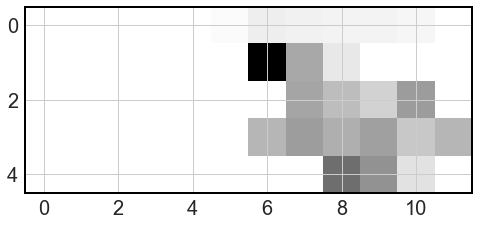

In [67]:
cm = sns.light_palette("green", as_cmap=True)
plt.imshow(matom50)
s2 = dfom75.style.background_gradient(cmap=cm)
s2.set_caption('$m_{UV,AB}$')

In [68]:
#dfom50.style.set_caption('$m_{UV,AB}$').background_gradient(cmap=cm)
dfom50.style.background_gradient(cmap=cm)

In [69]:
len(magBins[:-1]),len(mom75m[:,0]),len(mom75m[0,:])

NameError: name 'mom75m' is not defined

max val = 0.21755725190839695
min val = 0.0033112582781456954


TypeError: Dimensions of C (5, 7) are incompatible with X (8) and/or Y (10); see help(pcolormesh)

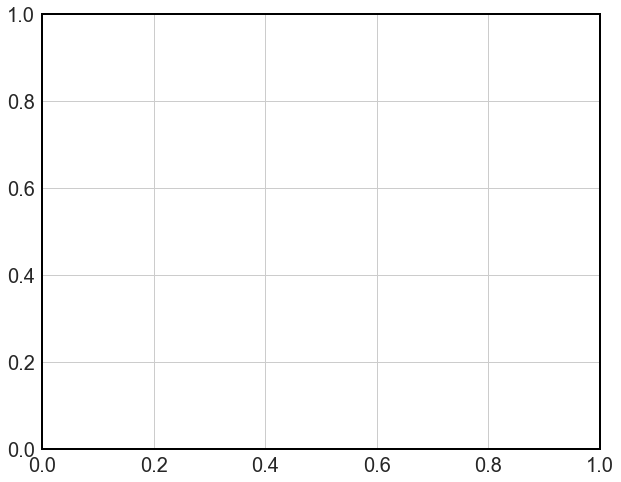

In [70]:
zs = np.arange(7,17)

fig      = plt.figure(figsize=(10, 8))
ax       = plt.axes()

matom75m = np.ma.masked_where(matom75==0, matom75)

X, Y = np.meshgrid(magBins[2:-3], zs)  # Create a grid over the range of bins for the plot

# mom75m = np.log10(matom75m)
print("max val = {}".format(matom75m.max()))
print("min val = {}".format(matom75m.min()))

# im = (ax.pcolormesh(X, Y, m75m, cmap=mpl.cm.YlGnBu, vmin=-2.4, vmax=0) )
im = (ax.pcolormesh(X, Y, matom75m[:,2:-3], cmap=mpl.cm.YlGnBu, vmin=2e-3, vmax=1) )

ax.set_xlabel('$m_{UV,AB}$',fontsize=24)
# ax.set_xticks(magBins)
ax.set_ylabel('redshift',fontsize=24)
ax.set_yticklabels(zs+1)
ax.grid(which='major', axis='y', color='0.75', linestyle=':', linewidth=1.5)
ax.grid(which='both', axis='x', color='0.75', linestyle=':', linewidth=1.5)

# Create the colorbar
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label("P(>0.75)",fontsize=24)

plt.savefig("ProbvsRedshiftObsMag.pdf",dpi=fig.dpi,bbox_inches='tight')


In [158]:
mom75m[:,4:]

masked_array(data =
 [[-- -- -2.682145076373832 -1.9088678258509035 -1.8066175503250896 -1.8370752510408843 -1.756192206422384
  -1.7898370087088382]
 [-1.8789046024734604 -1.9388948175981704 -1.5590775548220595 -2.0601580087341946 -2.423245873936808 -- -- --]
 [-- -2.173186268412274 -1.5902071645329623 -1.6925531793391444 -2.2840545584360687 -2.5010592622177517
  -1.9319661147281726 --]
 [-- -- -1.6989700043360187 -1.8796692056320534 -1.5893480258118247 -1.9375178920173466 -1.919078092376074
  -1.7481880270062005]
 [-- -1.5440680443502757 -1.8228216453031045 -1.3089573640660823 -1.6478174818886375 -- -2.0293837776852097 --]
 [-- -- -- -2.143014800254095 -1.8409420802430991 -1.649334858712142 -1.348953547981164 -1.1583624920952496]
 [-- -- -- -1.5910646070264993 -1.8325089127062364 -1.7745169657285496 -1.3710678622717363 -1.1249387366083]
 [-- -- -- -- -1.5314789170422551 -1.2937307569224816 -1.462397997898956 --]
 [-- -- -- -- -1.5563025007672873 -1.1856365769619117 -- -0.865301426102

In [21]:
fluxes[10].dtype.names

('halo',
 'r_v',
 'ZZsun',
 'ZPZsun',
 'MstarMsun',
 'M3StarMsun',
 'M3YngMsun',
 '1500A',
 '1500A_P3',
 '1500A_NM',
 '1500A_P3NM',
 '1500A_10pc',
 '1500A_P3_10pc')